# Source of this Project:

https://arxiv.org/pdf/1505.00487.pdf

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import sys
import ipdb
import time
import cv2
from keras.preprocessing import sequence
import matplotlib.pyplot as plt
from tensorflow.contrib import rnn
import fire
from elapsedtimer import ElapsedTimer
from pathlib import Path
print('tensorflow version:',tf.__version__)

Using TensorFlow backend.


tensorflow version: 1.13.1


### Initializing the Input Parameters

In [2]:
text_path = r'C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\video_corpus\video_corpus.csv'
feat_path = r'C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features'
path_prj = r'C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project'
feat_dir = 'features'
caption_file = 'video_corpus'

dim_image = 4096
dim_hidden = 512
batch_size = 8
lstm_steps = 80
video_lstm_step=80
caption_lstm_step=20 
mode = 'train'

if mode == 'train':
    train_text_path = text_path
    train_feat_path = feat_path
else:
    test_text_path = text_path
    test_feat_path = feat_path
learning_rate = 0.0001
epochs = 50
frame_step = 80 

model_path=path_prj

# Function to get the inputs of Pickle file of videos on CNN Layer Feature Output

In [5]:
def get_data(text_path,feat_path):
        text_data = pd.read_csv(text_path, sep=',')
        text_data = text_data[text_data['Language'] == 'English']
        text_data['video_path'] = text_data.apply(lambda row: row['VideoID']+'_'+str(int(row['Start']))+'_'+str(int(row['End']))+'.avi.npy', axis=1)
        text_data['video_path'] = text_data['video_path'].map(lambda x: os.path.join(feat_path, x))
        text_data = text_data[text_data['video_path'].map(lambda x: os.path.exists(x))]
        text_data = text_data[text_data['Description'].map(lambda x: isinstance(x, str))]
        
        unique_filenames = sorted(text_data['video_path'].unique())
        data = text_data[text_data['video_path'].map(lambda x: x in unique_filenames)]
        return data

# Test and Train Split

In [6]:
def train_test_split(data,test_frac=0.2):
        indices = np.arange(len(data))
        np.random.shuffle(indices)
        train_indices_rec = int((1 - test_frac)*len(data))
        indices_train = indices[:train_indices_rec]
        indices_test = indices[train_indices_rec:]
        data_train, data_test = data.iloc[indices_train],data.iloc[indices_test]
        print(data_train.head())
        print(data_test.head())
        data_train.reset_index(inplace=True)
        data_test.reset_index(inplace=True)
        return data_train,data_test


![LSTM](Capture1.jpg "LSTM Model")

Building Model consists of 2 LSTM models.

Each video Dimension is 80 * 4096 where as 80 frames are considered for each video.

<B/>Encoder</B>: 
LSTM1: Inputs each image frame and passes the Hidden units to LSTM2. LSTM2 process the output from LSTM1 and generates hidden units for the next processing

<B/>Decoder</B>:
LSTM1 is just rolled forward from where it left on Encoder and hidden units is passed to LSTM2. 
LSTM2 generates the next word caption, based on the Current word captioning along with the Hidden units from LSTM1.

LSTM2 word caption generation runs on propability function across each word to generate the Probability function which runs on SOFTMAX activity function.

Loss Function - Categorical cross entrophy

Optimizer - Adam


In [7]:
def build_model():
        # Defining the weights associated with the Network
        print (n_words)
        with tf.device('/cpu:0'): 
            word_emb = tf.Variable(tf.random_uniform([n_words, dim_hidden], -0.1, 0.1), name='word_emb')

        lstm1 = tf.nn.rnn_cell.BasicLSTMCell(dim_hidden, state_is_tuple=False)
        lstm2 = tf.nn.rnn_cell.BasicLSTMCell(dim_hidden, state_is_tuple=False)
        encode_W = tf.Variable( tf.random_uniform([dim_image,dim_hidden], -0.1, 0.1), name='encode_W')
        encode_b = tf.Variable( tf.zeros([dim_hidden]), name='encode_b')
        
        word_emb_W = tf.Variable(tf.random_uniform([dim_hidden,n_words], -0.1,0.1), name='word_emb_W')
        word_emb_b = tf.Variable(tf.zeros([n_words]), name='word_emb_b')
        
        # Placeholders 
        video = tf.placeholder(tf.float32, [batch_size, video_lstm_step, dim_image])
        video_mask = tf.placeholder(tf.float32, [batch_size, video_lstm_step])

        caption = tf.placeholder(tf.int32, [batch_size, caption_lstm_step+1])
        caption_mask = tf.placeholder(tf.float32, [batch_size, caption_lstm_step+1])

        video_flat = tf.reshape(video, [-1, dim_image])
        image_emb = tf.nn.xw_plus_b( video_flat, encode_W,encode_b )         
        image_emb = tf.reshape(image_emb, [batch_size, lstm_steps, dim_hidden])

        state1 = tf.zeros([batch_size, lstm1.state_size])
        state2 = tf.zeros([batch_size, lstm2.state_size])
        padding = tf.zeros([batch_size, dim_hidden])

        probs = []
        loss = 0.0

        #  Encoding Stage 
        for i in range(0, video_lstm_step):
            if i > 0:
                tf.get_variable_scope().reuse_variables()

            with tf.variable_scope("LSTM1"):
                output1, state1 = lstm1(image_emb[:,i,:], state1)

            with tf.variable_scope("LSTM2"):
                output2, state2 = lstm2(tf.concat([padding, output1],1), state2)

        #  Decoding Stage  to generate Captions 
        for i in range(0, caption_lstm_step):

            with tf.device("/cpu:0"):
                current_embed = tf.nn.embedding_lookup(word_emb, caption[:, i])

            tf.get_variable_scope().reuse_variables()

            with tf.variable_scope("LSTM1"):
                output1, state1 = lstm1(padding, state1)

            with tf.variable_scope("LSTM2"):
                output2, state2 = lstm2(tf.concat([current_embed, output1],1), state2)

            labels = tf.expand_dims(caption[:, i+1], 1)
            indices = tf.expand_dims(tf.range(0, batch_size, 1), 1)
            concated = tf.concat([indices, labels],1)
            onehot_labels = tf.sparse_to_dense(concated, tf.stack([batch_size, n_words]), 1.0, 0.0)

            logit_words = tf.nn.xw_plus_b(output2, word_emb_W, word_emb_b)
        # Computing the loss     
            cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logit_words,labels=onehot_labels)
            cross_entropy = cross_entropy * caption_mask[:,i]
            probs.append(logit_words)

            current_loss = tf.reduce_sum(cross_entropy)/batch_size
            loss = loss + current_loss
        with tf.variable_scope(tf.get_variable_scope(),reuse=tf.AUTO_REUSE):
            train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)    

        return loss, video, video_mask, caption, caption_mask, probs,train_op

Word Tokens are created, introduced 4 additional words. bos(begin of sentence) and eos(End of sentence) is very important as the LSTM2 is running on current and next word captoning, vectorizing the sentence with bos and eos will help in controlling any word loss. 

In [8]:
def create_word_dict(sentence_iterator, word_count_threshold=5):
        
        word_counts = {}
        sent_cnt = 0
        
        for sent in sentence_iterator:
            sent_cnt += 1
            for w in sent.lower().split(' '):
               word_counts[w] = word_counts.get(w, 0) + 1
        vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
        
        idx2word = {}
        idx2word[0] = '<pad>'
        idx2word[1] = '<bos>'
        idx2word[2] = '<eos>'
        idx2word[3] = '<unk>'
    
        word2idx = {}
        word2idx['<pad>'] = 0
        word2idx['<bos>'] = 1
        word2idx['<eos>'] = 2
        word2idx['<unk>'] = 3
    
        for idx, w in enumerate(vocab):
            word2idx[w] = idx+4
            idx2word[idx+4] = w
    
        word_counts['<pad>'] = sent_cnt
        word_counts['<bos>'] = sent_cnt
        word_counts['<eos>'] = sent_cnt
        word_counts['<unk>'] = sent_cnt
    
        return word2idx,idx2word

In [10]:
data

,VideoID,Start,End,WorkerID,Source,AnnotationTime,Language,Description,video_path
18,mv89psg6zh4,33,46,682611,clean,66,English,A bird in a sink keeps getting under the running water from a faucet.,C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\mv89psg6zh4_33_46.avi.npy
19,mv89psg6zh4,33,46,760882,clean,16,English,A bird is bathing in a sink.,C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\mv89psg6zh4_33_46.avi.npy
20,mv89psg6zh4,33,46,878566,clean,76,English,A bird is splashing around under a running faucet.,C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\mv89psg6zh4_33_46.avi.npy
21,mv89psg6zh4,33,46,707318,clean,14,English,A bird is bathing in a sink.,C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\mv89psg6zh4_33_46.avi.npy
22,mv89psg6zh4,33,46,135621,clean,58,English,A bird is standing in a sink drinking water that is pouring out of the facet.,C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\mv89psg6zh4_33_46.avi.npy
23,mv89psg6zh4,33,46,257511,clean,57,English,A faucet is running while a bird stands in the sink below.,C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\mv89psg6zh4_33_46.avi.npy
24,mv89psg6zh4,33,46,435773,clean,25,English,A bird is playing in a sink with running water.,C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\mv89psg6zh4_33_46.avi.npy
25,mv89psg6zh4,33,46,275759,clean,27,English,A bird is playing in tap water.,C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\mv89psg6zh4_33_46.avi.npy
26,mv89psg6zh4,33,46,157374,clean,30,English,A bird is bathing in the sink.,C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\mv89psg6zh4_33_46.avi.npy
27,mv89psg6zh4,33,46,373663,clean,36,English,A bird is taking a bath.,C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\mv89psg6zh4_33_46.avi.npy


In [9]:
data = get_data(text_path,feat_path)

In [11]:
train_data,test_data = train_test_split(data,test_frac=0.2)

            VideoID  Start  End  WorkerID      Source  AnnotationTime  \
102328  QMJY29QMewQ  42     52   600230    unverified  14               
96273   MrMG15y3rWU  5      13   411294    clean       31               
116010  qeKX-N1nKiM  74     77   707318    unverified  19               
48266   PeUHy0A1GF0  28     32   221999    unverified  37               
72616   WFNXwor69-U  33     40   347757    unverified  26               

       Language                                    Description  \
102328  English  A person is whisking an egg.                    
96273   English  The finger is teasing the frog.                 
116010  English  A woman slices cantaloupe.                      
48266   English  The woman is mixing some thing with two bowls   
72616   English  An elephant goes shopping                       

                                                                                                  video_path  
102328  C:\Users\cst2978\OneDrive - The Home Depot\De

In [12]:
train_data.to_csv(f'{path_prj}/train.csv',index=False)
test_data.to_csv(f'{path_prj}/test.csv',index=False)

print(f'Processed train file written to {path_prj}/train_corpus.csv')
print(f'Processed test file written to {path_prj}/test_corpus.csv')

Processed train file written to C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project/train_corpus.csv
Processed test file written to C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project/test_corpus.csv


In [13]:
train_captions = train_data['Description'].values
test_captions = test_data['Description'].values
captions_list = list(train_captions) 
captions = np.asarray(captions_list, dtype=np.object)

captions = list(map(lambda x: x.replace('.', ''), captions))
captions = list(map(lambda x: x.replace(',', ''), captions))
captions = list(map(lambda x: x.replace('"', ''), captions))
captions = list(map(lambda x: x.replace('\n', ''), captions))
captions = list(map(lambda x: x.replace('?', ''), captions))
captions = list(map(lambda x: x.replace('!', ''), captions))
captions = list(map(lambda x: x.replace('\\', ''), captions))
captions = list(map(lambda x: x.replace('/', ''), captions))

In [14]:
word2idx,idx2word = create_word_dict(captions, word_count_threshold=0)

In [15]:
np.save(path_prj+ "\\word2idx",word2idx)
np.save(path_prj+ "\\idx2word" ,idx2word)
n_words = len(word2idx)

In [16]:
n_words

12083

In [17]:
tf_loss, tf_video,tf_video_mask,tf_caption,tf_caption_mask, tf_probs,train_op= build_model()

12083
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Instructions for updating:
Use tf.cast instead.


In [18]:
sess = tf.InteractiveSession()

saver = tf.train.Saver(max_to_keep=100, write_version=1)
tf.global_variables_initializer().run()

In [19]:
loss_out = open('loss.txt', 'w')
val_loss = []

In [20]:
current_train_data = train_data.groupby(['video_path']).first().reset_index()

In [21]:
current_train_data [current_train_data['VideoID']=='-AwoiGR6c8M']

,video_path,index,VideoID,Start,End,WorkerID,Source,AnnotationTime,Language,Description
5,C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\-AwoiGR6c8M_10_14.avi.npy,43998,-AwoiGR6c8M,10,14,965612,unverified,69,English,the girl is playing the nusic


In [22]:
train_data [train_data['VideoID']=='-AwoiGR6c8M'].sort_index()

,index,VideoID,Start,End,WorkerID,Source,AnnotationTime,Language,Description,video_path
179,43998,-AwoiGR6c8M,10,14,965612,unverified,69,English,the girl is playing the nusic,C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\-AwoiGR6c8M_10_14.avi.npy
2908,44015,-AwoiGR6c8M,10,14,977945,unverified,135,English,A girl playing piyano,C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\-AwoiGR6c8M_10_14.avi.npy
6185,43992,-AwoiGR6c8M,10,14,257003,clean,62,English,A youngster is sitting on a piano.,C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\-AwoiGR6c8M_10_14.avi.npy
10086,43980,-AwoiGR6c8M,10,14,275759,clean,22,English,A boy is playing piano.,C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\-AwoiGR6c8M_10_14.avi.npy
10380,44019,-AwoiGR6c8M,10,14,638934,unverified,8,English,A boy is playing the piano.,C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\-AwoiGR6c8M_10_14.avi.npy
12898,43981,-AwoiGR6c8M,10,14,617730,clean,17,English,A boy is playing the piano.,C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\-AwoiGR6c8M_10_14.avi.npy
18342,44010,-AwoiGR6c8M,10,14,169072,unverified,191,English,Somebody is doing something.,C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\-AwoiGR6c8M_10_14.avi.npy
20120,44006,-AwoiGR6c8M,10,14,741585,unverified,14,English,A kid is playing a piano.,C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\-AwoiGR6c8M_10_14.avi.npy
22474,44001,-AwoiGR6c8M,10,14,154335,unverified,97,English,the boy sit and sing very nicely,C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\-AwoiGR6c8M_10_14.avi.npy
22543,43995,-AwoiGR6c8M,10,14,553931,clean,15,English,The boy practiced the piano.,C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\-AwoiGR6c8M_10_14.avi.npy


In [23]:
train_data.shape

(64599, 10)

# An Epoch of 50 has been trained on the data. It took around 15 hours to complete. When ran on less then 10 epochs the video captioning generated is bad

Batch starting index:  0  Epoch:  0  loss:  94.15467  Elapsed time:  7.903829336166382
Batch starting index:  8  Epoch:  0  loss:  92.22983  Elapsed time:  3.3823423385620117
Batch starting index:  16  Epoch:  0  loss:  81.87571  Elapsed time:  3.1660242080688477
Batch starting index:  24  Epoch:  0  loss:  86.7721  Elapsed time:  2.5609309673309326
Batch starting index:  32  Epoch:  0  loss:  76.50627  Elapsed time:  2.4984445571899414
Batch starting index:  40  Epoch:  0  loss:  96.91206  Elapsed time:  2.6073999404907227
Batch starting index:  48  Epoch:  0  loss:  83.87081  Elapsed time:  2.596384048461914
Batch starting index:  56  Epoch:  0  loss:  86.21063  Elapsed time:  2.5701656341552734
Batch starting index:  64  Epoch:  0  loss:  82.70984  Elapsed time:  2.5844814777374268
Batch starting index:  72  Epoch:  0  loss:  87.06324  Elapsed time:  2.544869899749756
Batch starting index:  80  Epoch:  0  loss:  87.30451  Elapsed time:  2.5400004386901855
Batch starting index:  88  

Batch starting index:  736  Epoch:  0  loss:  53.555073  Elapsed time:  2.812694787979126
Batch starting index:  744  Epoch:  0  loss:  49.2146  Elapsed time:  2.7893242835998535
Batch starting index:  752  Epoch:  0  loss:  44.41248  Elapsed time:  2.6994595527648926
Batch starting index:  760  Epoch:  0  loss:  43.282112  Elapsed time:  2.6568539142608643
Batch starting index:  768  Epoch:  0  loss:  42.639538  Elapsed time:  2.6614737510681152
Batch starting index:  776  Epoch:  0  loss:  39.992176  Elapsed time:  2.7282423973083496
Batch starting index:  784  Epoch:  0  loss:  53.87978  Elapsed time:  2.6021535396575928
Batch starting index:  792  Epoch:  0  loss:  44.48655  Elapsed time:  2.6259257793426514
Batch starting index:  800  Epoch:  0  loss:  55.92898  Elapsed time:  2.6711506843566895
Batch starting index:  808  Epoch:  0  loss:  40.410282  Elapsed time:  2.6712262630462646
Batch starting index:  816  Epoch:  0  loss:  55.024353  Elapsed time:  2.7115914821624756
Batch 

Batch starting index:  1464  Epoch:  0  loss:  53.994793  Elapsed time:  2.8691046237945557
Batch starting index:  1472  Epoch:  0  loss:  31.275946  Elapsed time:  2.8257510662078857
Batch starting index:  1480  Epoch:  0  loss:  29.817347  Elapsed time:  2.8825457096099854
Batch starting index:  1488  Epoch:  0  loss:  38.379833  Elapsed time:  2.8766424655914307
Batch starting index:  1496  Epoch:  0  loss:  48.328022  Elapsed time:  2.7220544815063477
Batch starting index:  1504  Epoch:  0  loss:  53.159286  Elapsed time:  2.7883424758911133
Batch starting index:  1512  Epoch:  0  loss:  57.69641  Elapsed time:  2.8169126510620117
Batch starting index:  1520  Epoch:  0  loss:  24.634508  Elapsed time:  2.646355390548706
Batch starting index:  1528  Epoch:  0  loss:  38.127506  Elapsed time:  2.7088000774383545
Batch starting index:  1536  Epoch:  0  loss:  37.326813  Elapsed time:  2.7572882175445557
Batch starting index:  1544  Epoch:  0  loss:  50.41447  Elapsed time:  2.74487972

Batch starting index:  192  Epoch:  1  loss:  33.36672  Elapsed time:  2.6354522705078125
Batch starting index:  200  Epoch:  1  loss:  37.533546  Elapsed time:  2.647446870803833
Batch starting index:  208  Epoch:  1  loss:  48.370052  Elapsed time:  2.6220059394836426
Batch starting index:  216  Epoch:  1  loss:  44.010517  Elapsed time:  2.6040751934051514
Batch starting index:  224  Epoch:  1  loss:  45.739964  Elapsed time:  2.609104633331299
Batch starting index:  232  Epoch:  1  loss:  33.964703  Elapsed time:  3.108372211456299
Batch starting index:  240  Epoch:  1  loss:  42.41761  Elapsed time:  3.012683868408203
Batch starting index:  248  Epoch:  1  loss:  44.862442  Elapsed time:  2.9334042072296143
Batch starting index:  256  Epoch:  1  loss:  37.210842  Elapsed time:  3.0018680095672607
Batch starting index:  264  Epoch:  1  loss:  36.984837  Elapsed time:  2.803666114807129
Batch starting index:  272  Epoch:  1  loss:  53.54982  Elapsed time:  2.770394802093506
Batch st

Batch starting index:  920  Epoch:  1  loss:  34.19161  Elapsed time:  2.6795592308044434
Batch starting index:  928  Epoch:  1  loss:  26.981634  Elapsed time:  2.6542651653289795
Batch starting index:  936  Epoch:  1  loss:  36.754066  Elapsed time:  2.722714424133301
Batch starting index:  944  Epoch:  1  loss:  40.288994  Elapsed time:  2.748178720474243
Batch starting index:  952  Epoch:  1  loss:  38.769928  Elapsed time:  2.669478416442871
Batch starting index:  960  Epoch:  1  loss:  26.424585  Elapsed time:  2.664698600769043
Batch starting index:  968  Epoch:  1  loss:  29.944185  Elapsed time:  2.7343926429748535
Batch starting index:  976  Epoch:  1  loss:  29.44633  Elapsed time:  2.757986307144165
Batch starting index:  984  Epoch:  1  loss:  36.63675  Elapsed time:  2.6269350051879883
Batch starting index:  992  Epoch:  1  loss:  32.998615  Elapsed time:  2.695336103439331
Batch starting index:  1000  Epoch:  1  loss:  36.972794  Elapsed time:  2.692697048187256
Batch st

Batch starting index:  1648  Epoch:  1  loss:  38.87053  Elapsed time:  2.702691078186035
Batch starting index:  1656  Epoch:  1  loss:  45.583225  Elapsed time:  2.773998260498047
Batch starting index:  1664  Epoch:  1  loss:  34.27863  Elapsed time:  2.766007661819458
Batch starting index:  1672  Epoch:  1  loss:  30.515545  Elapsed time:  2.7475810050964355
Batch starting index:  1680  Epoch:  1  loss:  30.363564  Elapsed time:  2.715712070465088
Batch starting index:  1688  Epoch:  1  loss:  43.345722  Elapsed time:  2.5946133136749268
Batch starting index:  1696  Epoch:  1  loss:  34.024574  Elapsed time:  2.5776560306549072
Batch starting index:  1704  Epoch:  1  loss:  41.839275  Elapsed time:  2.7392525672912598
Batch starting index:  1712  Epoch:  1  loss:  58.724052  Elapsed time:  2.7526471614837646
Batch starting index:  1720  Epoch:  1  loss:  69.75245  Elapsed time:  2.69874906539917
Batch starting index:  1728  Epoch:  1  loss:  40.466824  Elapsed time:  2.66322541236877

Batch starting index:  416  Epoch:  2  loss:  41.05088  Elapsed time:  2.9937374591827393
Batch starting index:  424  Epoch:  2  loss:  33.601826  Elapsed time:  2.931501626968384
Batch starting index:  432  Epoch:  2  loss:  29.449757  Elapsed time:  2.8812143802642822
Batch starting index:  440  Epoch:  2  loss:  32.94329  Elapsed time:  2.852546215057373
Batch starting index:  448  Epoch:  2  loss:  34.237003  Elapsed time:  2.8334426879882812
Batch starting index:  456  Epoch:  2  loss:  39.835384  Elapsed time:  2.803454875946045
Batch starting index:  464  Epoch:  2  loss:  34.798965  Elapsed time:  2.76566481590271
Batch starting index:  472  Epoch:  2  loss:  35.687622  Elapsed time:  2.6504600048065186
Batch starting index:  480  Epoch:  2  loss:  47.30353  Elapsed time:  2.7599334716796875
Batch starting index:  488  Epoch:  2  loss:  29.714977  Elapsed time:  2.6414906978607178
Batch starting index:  496  Epoch:  2  loss:  23.43455  Elapsed time:  2.5955095291137695
Batch st

Batch starting index:  1144  Epoch:  2  loss:  39.153923  Elapsed time:  2.6478660106658936
Batch starting index:  1152  Epoch:  2  loss:  39.780964  Elapsed time:  2.632657527923584
Batch starting index:  1160  Epoch:  2  loss:  41.40172  Elapsed time:  2.583754301071167
Batch starting index:  1168  Epoch:  2  loss:  27.306646  Elapsed time:  2.641599416732788
Batch starting index:  1176  Epoch:  2  loss:  41.553642  Elapsed time:  2.685062885284424
Batch starting index:  1184  Epoch:  2  loss:  33.33173  Elapsed time:  2.747303009033203
Batch starting index:  1192  Epoch:  2  loss:  31.466457  Elapsed time:  3.1772444248199463
Batch starting index:  1200  Epoch:  2  loss:  39.997334  Elapsed time:  2.9617555141448975
Batch starting index:  1208  Epoch:  2  loss:  43.776863  Elapsed time:  2.888378620147705
Batch starting index:  1216  Epoch:  2  loss:  52.13436  Elapsed time:  2.937318801879883
Batch starting index:  1224  Epoch:  2  loss:  28.92737  Elapsed time:  2.808236837387085


Batch starting index:  1864  Epoch:  2  loss:  37.744343  Elapsed time:  2.6319189071655273
Batch starting index:  1872  Epoch:  2  loss:  38.428135  Elapsed time:  2.642814874649048
Batch starting index:  1880  Epoch:  2  loss:  37.143177  Elapsed time:  2.7219576835632324
Batch starting index:  1888  Epoch:  2  loss:  31.492828  Elapsed time:  2.6787235736846924
Batch starting index:  1896  Epoch:  2  loss:  40.88148  Elapsed time:  2.636667490005493
Batch starting index:  1904  Epoch:  2  loss:  30.205654  Elapsed time:  2.6962013244628906
Batch starting index:  1912  Epoch:  2  loss:  37.527325  Elapsed time:  2.73775577545166
Batch starting index:  1920  Epoch:  2  loss:  46.194576  Elapsed time:  2.6939656734466553
Batch starting index:  1928  Epoch:  2  loss:  30.613352  Elapsed time:  2.5937600135803223
Batch starting index:  1936  Epoch:  2  loss:  23.301407  Elapsed time:  2.588104724884033
Batch starting index:  1944  Epoch:  2  loss:  70.31127  Elapsed time:  2.608655929565

Batch starting index:  632  Epoch:  3  loss:  37.58637  Elapsed time:  2.5963284969329834
Batch starting index:  640  Epoch:  3  loss:  44.691357  Elapsed time:  2.660792589187622
Batch starting index:  648  Epoch:  3  loss:  37.3336  Elapsed time:  2.608405113220215
Batch starting index:  656  Epoch:  3  loss:  44.953846  Elapsed time:  2.6020686626434326
Batch starting index:  664  Epoch:  3  loss:  35.821285  Elapsed time:  3.0867040157318115
Batch starting index:  672  Epoch:  3  loss:  37.18776  Elapsed time:  3.0289933681488037
Batch starting index:  680  Epoch:  3  loss:  45.71235  Elapsed time:  3.0258772373199463
Batch starting index:  688  Epoch:  3  loss:  38.34181  Elapsed time:  2.8196561336517334
Batch starting index:  696  Epoch:  3  loss:  41.880398  Elapsed time:  2.7872254848480225
Batch starting index:  704  Epoch:  3  loss:  34.014324  Elapsed time:  2.7359495162963867
Batch starting index:  712  Epoch:  3  loss:  27.433994  Elapsed time:  2.6814215183258057
Batch s

Batch starting index:  1360  Epoch:  3  loss:  29.909752  Elapsed time:  2.7059109210968018
Batch starting index:  1368  Epoch:  3  loss:  39.555653  Elapsed time:  2.7345166206359863
Batch starting index:  1376  Epoch:  3  loss:  32.822525  Elapsed time:  2.634357213973999
Batch starting index:  1384  Epoch:  3  loss:  32.922913  Elapsed time:  2.607896089553833
Batch starting index:  1392  Epoch:  3  loss:  21.835829  Elapsed time:  2.596311092376709
Batch starting index:  1400  Epoch:  3  loss:  36.57718  Elapsed time:  2.6078414916992188
Batch starting index:  1408  Epoch:  3  loss:  40.758038  Elapsed time:  2.652529001235962
Batch starting index:  1416  Epoch:  3  loss:  35.510094  Elapsed time:  2.6006829738616943
Batch starting index:  1424  Epoch:  3  loss:  34.188667  Elapsed time:  2.596696138381958
Batch starting index:  1432  Epoch:  3  loss:  43.32881  Elapsed time:  2.5834670066833496
Batch starting index:  1440  Epoch:  3  loss:  46.699707  Elapsed time:  2.899614572525

Batch starting index:  128  Epoch:  4  loss:  49.977585  Elapsed time:  2.5763349533081055
Batch starting index:  136  Epoch:  4  loss:  31.04475  Elapsed time:  2.55706524848938
Batch starting index:  144  Epoch:  4  loss:  32.804447  Elapsed time:  2.567126512527466
Batch starting index:  152  Epoch:  4  loss:  30.064196  Elapsed time:  2.5902438163757324
Batch starting index:  160  Epoch:  4  loss:  34.242718  Elapsed time:  2.6267142295837402
Batch starting index:  168  Epoch:  4  loss:  30.291866  Elapsed time:  2.6150996685028076
Batch starting index:  176  Epoch:  4  loss:  24.924517  Elapsed time:  2.6868765354156494
Batch starting index:  184  Epoch:  4  loss:  41.586735  Elapsed time:  2.847552537918091
Batch starting index:  192  Epoch:  4  loss:  29.04885  Elapsed time:  2.8022069931030273
Batch starting index:  200  Epoch:  4  loss:  32.676323  Elapsed time:  2.745326280593872
Batch starting index:  208  Epoch:  4  loss:  41.248444  Elapsed time:  2.655505895614624
Batch s

Batch starting index:  856  Epoch:  4  loss:  31.005598  Elapsed time:  2.694467782974243
Batch starting index:  864  Epoch:  4  loss:  44.9281  Elapsed time:  2.6506741046905518
Batch starting index:  872  Epoch:  4  loss:  34.144592  Elapsed time:  2.6077263355255127
Batch starting index:  880  Epoch:  4  loss:  45.599796  Elapsed time:  2.6085288524627686
Batch starting index:  888  Epoch:  4  loss:  28.498453  Elapsed time:  2.6075191497802734
Batch starting index:  896  Epoch:  4  loss:  27.776161  Elapsed time:  2.601672649383545
Batch starting index:  904  Epoch:  4  loss:  42.024624  Elapsed time:  2.7852213382720947
Batch starting index:  912  Epoch:  4  loss:  33.002182  Elapsed time:  2.640192747116089
Batch starting index:  920  Epoch:  4  loss:  35.964005  Elapsed time:  2.5663034915924072
Batch starting index:  928  Epoch:  4  loss:  45.362957  Elapsed time:  2.509713649749756
Batch starting index:  936  Epoch:  4  loss:  31.371675  Elapsed time:  2.5108602046966553
Batch

Batch starting index:  1584  Epoch:  4  loss:  35.8508  Elapsed time:  2.610043525695801
Batch starting index:  1592  Epoch:  4  loss:  28.280289  Elapsed time:  2.7076728343963623
Batch starting index:  1600  Epoch:  4  loss:  44.004086  Elapsed time:  2.7834601402282715
Batch starting index:  1608  Epoch:  4  loss:  39.220757  Elapsed time:  2.7685179710388184
Batch starting index:  1616  Epoch:  4  loss:  36.131348  Elapsed time:  2.6307036876678467
Batch starting index:  1624  Epoch:  4  loss:  29.389835  Elapsed time:  2.6858747005462646
Batch starting index:  1632  Epoch:  4  loss:  30.124655  Elapsed time:  2.691992998123169
Batch starting index:  1640  Epoch:  4  loss:  31.768541  Elapsed time:  2.6477696895599365
Batch starting index:  1648  Epoch:  4  loss:  34.38203  Elapsed time:  2.648118257522583
Batch starting index:  1656  Epoch:  4  loss:  36.933144  Elapsed time:  2.5986168384552
Batch starting index:  1664  Epoch:  4  loss:  26.669659  Elapsed time:  2.51908731460571

Batch starting index:  352  Epoch:  5  loss:  38.362465  Elapsed time:  3.326676368713379
Batch starting index:  360  Epoch:  5  loss:  50.664986  Elapsed time:  3.555621862411499
Batch starting index:  368  Epoch:  5  loss:  27.70122  Elapsed time:  3.343762159347534
Batch starting index:  376  Epoch:  5  loss:  31.735077  Elapsed time:  2.9165139198303223
Batch starting index:  384  Epoch:  5  loss:  24.975523  Elapsed time:  2.920840263366699
Batch starting index:  392  Epoch:  5  loss:  29.020828  Elapsed time:  2.811718225479126
Batch starting index:  400  Epoch:  5  loss:  34.994183  Elapsed time:  2.7712271213531494
Batch starting index:  408  Epoch:  5  loss:  41.533684  Elapsed time:  2.7760367393493652
Batch starting index:  416  Epoch:  5  loss:  37.74094  Elapsed time:  2.710238218307495
Batch starting index:  424  Epoch:  5  loss:  31.881437  Elapsed time:  2.6645607948303223
Batch starting index:  432  Epoch:  5  loss:  25.552402  Elapsed time:  2.6464014053344727
Batch s

Batch starting index:  1080  Epoch:  5  loss:  34.100266  Elapsed time:  2.5896427631378174
Batch starting index:  1088  Epoch:  5  loss:  39.95382  Elapsed time:  2.670515537261963
Batch starting index:  1096  Epoch:  5  loss:  23.57837  Elapsed time:  2.639127492904663
Batch starting index:  1104  Epoch:  5  loss:  39.25633  Elapsed time:  2.5795400142669678
Batch starting index:  1112  Epoch:  5  loss:  39.491673  Elapsed time:  2.985743522644043
Batch starting index:  1120  Epoch:  5  loss:  31.349411  Elapsed time:  2.916221857070923
Batch starting index:  1128  Epoch:  5  loss:  28.05773  Elapsed time:  2.8703131675720215
Batch starting index:  1136  Epoch:  5  loss:  28.927229  Elapsed time:  2.7958767414093018
Batch starting index:  1144  Epoch:  5  loss:  24.52084  Elapsed time:  2.729505777359009
Batch starting index:  1152  Epoch:  5  loss:  49.14064  Elapsed time:  2.7076964378356934
Batch starting index:  1160  Epoch:  5  loss:  44.399117  Elapsed time:  2.7794463634490967

Batch starting index:  1800  Epoch:  5  loss:  39.519356  Elapsed time:  2.6207122802734375
Batch starting index:  1808  Epoch:  5  loss:  34.28685  Elapsed time:  2.657486915588379
Batch starting index:  1816  Epoch:  5  loss:  35.122425  Elapsed time:  2.668780565261841
Batch starting index:  1824  Epoch:  5  loss:  35.726776  Elapsed time:  2.5865330696105957
Batch starting index:  1832  Epoch:  5  loss:  28.417974  Elapsed time:  2.549288034439087
Batch starting index:  1840  Epoch:  5  loss:  26.899853  Elapsed time:  2.555737018585205
Batch starting index:  1848  Epoch:  5  loss:  40.58243  Elapsed time:  2.5689666271209717
Batch starting index:  1856  Epoch:  5  loss:  28.183628  Elapsed time:  2.514350414276123
Batch starting index:  1864  Epoch:  5  loss:  34.96669  Elapsed time:  2.5899672508239746
Batch starting index:  1872  Epoch:  5  loss:  38.701397  Elapsed time:  2.7548511028289795
Batch starting index:  1880  Epoch:  5  loss:  26.049646  Elapsed time:  2.6932935714721

Batch starting index:  568  Epoch:  6  loss:  40.099533  Elapsed time:  2.7765612602233887
Batch starting index:  576  Epoch:  6  loss:  24.359314  Elapsed time:  2.706472396850586
Batch starting index:  584  Epoch:  6  loss:  41.96577  Elapsed time:  2.6679508686065674
Batch starting index:  592  Epoch:  6  loss:  29.871372  Elapsed time:  2.6733522415161133
Batch starting index:  600  Epoch:  6  loss:  21.978706  Elapsed time:  2.644871950149536
Batch starting index:  608  Epoch:  6  loss:  48.25221  Elapsed time:  2.6257011890411377
Batch starting index:  616  Epoch:  6  loss:  28.899218  Elapsed time:  2.6874148845672607
Batch starting index:  624  Epoch:  6  loss:  36.78819  Elapsed time:  2.6967673301696777
Batch starting index:  632  Epoch:  6  loss:  34.324684  Elapsed time:  2.6452577114105225
Batch starting index:  640  Epoch:  6  loss:  55.30458  Elapsed time:  2.6163015365600586
Batch starting index:  648  Epoch:  6  loss:  40.21528  Elapsed time:  2.59277081489563
Batch st

Batch starting index:  1296  Epoch:  6  loss:  36.98244  Elapsed time:  2.914748430252075
Batch starting index:  1304  Epoch:  6  loss:  30.406868  Elapsed time:  2.8125364780426025
Batch starting index:  1312  Epoch:  6  loss:  43.058674  Elapsed time:  2.8073267936706543
Batch starting index:  1320  Epoch:  6  loss:  32.98004  Elapsed time:  2.7555603981018066
Batch starting index:  1328  Epoch:  6  loss:  41.410038  Elapsed time:  2.772972583770752
Batch starting index:  1336  Epoch:  6  loss:  39.979168  Elapsed time:  2.65484619140625
Batch starting index:  1344  Epoch:  6  loss:  35.648987  Elapsed time:  2.6338109970092773
Batch starting index:  1352  Epoch:  6  loss:  30.68591  Elapsed time:  2.608020782470703
Batch starting index:  1360  Epoch:  6  loss:  26.651533  Elapsed time:  2.6929192543029785
Batch starting index:  1368  Epoch:  6  loss:  38.017284  Elapsed time:  2.6505820751190186
Batch starting index:  1376  Epoch:  6  loss:  29.416225  Elapsed time:  2.5929601192474

Batch starting index:  56  Epoch:  7  loss:  30.119495  Elapsed time:  2.740784168243408
Batch starting index:  64  Epoch:  7  loss:  28.122627  Elapsed time:  2.681171417236328
Batch starting index:  72  Epoch:  7  loss:  28.800182  Elapsed time:  2.6401913166046143
Batch starting index:  80  Epoch:  7  loss:  33.905518  Elapsed time:  2.7221791744232178
Batch starting index:  88  Epoch:  7  loss:  29.194195  Elapsed time:  2.5799763202667236
Batch starting index:  96  Epoch:  7  loss:  27.473019  Elapsed time:  2.5722928047180176
Batch starting index:  104  Epoch:  7  loss:  26.733553  Elapsed time:  2.5264387130737305
Batch starting index:  112  Epoch:  7  loss:  28.275198  Elapsed time:  2.523104190826416
Batch starting index:  120  Epoch:  7  loss:  25.06527  Elapsed time:  2.5282540321350098
Batch starting index:  128  Epoch:  7  loss:  34.882607  Elapsed time:  2.546382427215576
Batch starting index:  136  Epoch:  7  loss:  29.492506  Elapsed time:  2.529268980026245
Batch start

Batch starting index:  784  Epoch:  7  loss:  27.388783  Elapsed time:  2.669424295425415
Batch starting index:  792  Epoch:  7  loss:  31.104652  Elapsed time:  2.6354894638061523
Batch starting index:  800  Epoch:  7  loss:  29.333225  Elapsed time:  2.5626628398895264
Batch starting index:  808  Epoch:  7  loss:  25.956556  Elapsed time:  2.589029550552368
Batch starting index:  816  Epoch:  7  loss:  35.461918  Elapsed time:  2.5592758655548096
Batch starting index:  824  Epoch:  7  loss:  27.247175  Elapsed time:  2.544421911239624
Batch starting index:  832  Epoch:  7  loss:  39.554935  Elapsed time:  2.55336856842041
Batch starting index:  840  Epoch:  7  loss:  27.656929  Elapsed time:  2.5908405780792236
Batch starting index:  848  Epoch:  7  loss:  42.569023  Elapsed time:  2.6215429306030273
Batch starting index:  856  Epoch:  7  loss:  20.138548  Elapsed time:  2.6725568771362305
Batch starting index:  864  Epoch:  7  loss:  31.17012  Elapsed time:  2.7045705318450928
Batch

Batch starting index:  1512  Epoch:  7  loss:  42.978397  Elapsed time:  2.6753652095794678
Batch starting index:  1520  Epoch:  7  loss:  24.883612  Elapsed time:  2.610628843307495
Batch starting index:  1528  Epoch:  7  loss:  45.0508  Elapsed time:  2.58402419090271
Batch starting index:  1536  Epoch:  7  loss:  25.322666  Elapsed time:  2.584629535675049
Batch starting index:  1544  Epoch:  7  loss:  19.855452  Elapsed time:  2.5921661853790283
Batch starting index:  1552  Epoch:  7  loss:  34.68751  Elapsed time:  2.6281232833862305
Batch starting index:  1560  Epoch:  7  loss:  32.54614  Elapsed time:  2.5940070152282715
Batch starting index:  1568  Epoch:  7  loss:  27.842552  Elapsed time:  2.6010451316833496
Batch starting index:  1576  Epoch:  7  loss:  29.083076  Elapsed time:  2.6485183238983154
Batch starting index:  1584  Epoch:  7  loss:  26.505701  Elapsed time:  2.642547369003296
Batch starting index:  1592  Epoch:  7  loss:  39.120277  Elapsed time:  2.58551692962646

Batch starting index:  280  Epoch:  8  loss:  30.886713  Elapsed time:  2.566307783126831
Batch starting index:  288  Epoch:  8  loss:  28.33869  Elapsed time:  2.5850417613983154
Batch starting index:  296  Epoch:  8  loss:  23.592451  Elapsed time:  2.632467269897461
Batch starting index:  304  Epoch:  8  loss:  40.628983  Elapsed time:  2.661337375640869
Batch starting index:  312  Epoch:  8  loss:  33.545116  Elapsed time:  2.648899555206299
Batch starting index:  320  Epoch:  8  loss:  21.711346  Elapsed time:  2.6684772968292236
Batch starting index:  328  Epoch:  8  loss:  31.593765  Elapsed time:  2.7225918769836426
Batch starting index:  336  Epoch:  8  loss:  24.17965  Elapsed time:  2.639730453491211
Batch starting index:  344  Epoch:  8  loss:  35.72974  Elapsed time:  2.617994546890259
Batch starting index:  352  Epoch:  8  loss:  43.017757  Elapsed time:  2.5843260288238525
Batch starting index:  360  Epoch:  8  loss:  39.630768  Elapsed time:  2.607896566390991
Batch sta

Batch starting index:  1008  Epoch:  8  loss:  29.228899  Elapsed time:  2.6527493000030518
Batch starting index:  1016  Epoch:  8  loss:  18.499556  Elapsed time:  2.622114419937134
Batch starting index:  1024  Epoch:  8  loss:  22.828978  Elapsed time:  2.6337342262268066
Batch starting index:  1032  Epoch:  8  loss:  26.57722  Elapsed time:  2.6666672229766846
Batch starting index:  1040  Epoch:  8  loss:  29.471792  Elapsed time:  2.600585699081421
Batch starting index:  1048  Epoch:  8  loss:  23.286268  Elapsed time:  3.072610378265381
Batch starting index:  1056  Epoch:  8  loss:  32.396618  Elapsed time:  2.89947247505188
Batch starting index:  1064  Epoch:  8  loss:  29.649473  Elapsed time:  2.903449296951294
Batch starting index:  1072  Epoch:  8  loss:  41.072067  Elapsed time:  2.8006205558776855
Batch starting index:  1080  Epoch:  8  loss:  40.243763  Elapsed time:  2.774604320526123
Batch starting index:  1088  Epoch:  8  loss:  44.003063  Elapsed time:  2.7321081161499

Batch starting index:  1728  Epoch:  8  loss:  34.873775  Elapsed time:  2.621039628982544
Batch starting index:  1736  Epoch:  8  loss:  40.03729  Elapsed time:  2.6042370796203613
Batch starting index:  1744  Epoch:  8  loss:  25.49257  Elapsed time:  2.6149797439575195
Batch starting index:  1752  Epoch:  8  loss:  27.270151  Elapsed time:  2.6098501682281494
Batch starting index:  1760  Epoch:  8  loss:  39.660088  Elapsed time:  2.6426444053649902
Batch starting index:  1768  Epoch:  8  loss:  24.965061  Elapsed time:  2.630988836288452
Batch starting index:  1776  Epoch:  8  loss:  27.115538  Elapsed time:  2.60109281539917
Batch starting index:  1784  Epoch:  8  loss:  19.240265  Elapsed time:  2.62986421585083
Batch starting index:  1792  Epoch:  8  loss:  31.346056  Elapsed time:  2.5699520111083984
Batch starting index:  1800  Epoch:  8  loss:  24.235706  Elapsed time:  2.6443440914154053
Batch starting index:  1808  Epoch:  8  loss:  46.945488  Elapsed time:  2.9862749576568

Batch starting index:  496  Epoch:  9  loss:  25.911566  Elapsed time:  2.5911567211151123
Batch starting index:  504  Epoch:  9  loss:  33.217464  Elapsed time:  2.618227958679199
Batch starting index:  512  Epoch:  9  loss:  29.55274  Elapsed time:  2.6351449489593506
Batch starting index:  520  Epoch:  9  loss:  31.128883  Elapsed time:  2.597865343093872
Batch starting index:  528  Epoch:  9  loss:  19.816044  Elapsed time:  2.5622751712799072
Batch starting index:  536  Epoch:  9  loss:  30.174063  Elapsed time:  2.620473861694336
Batch starting index:  544  Epoch:  9  loss:  28.237888  Elapsed time:  2.639122247695923
Batch starting index:  552  Epoch:  9  loss:  30.618555  Elapsed time:  2.6006476879119873
Batch starting index:  560  Epoch:  9  loss:  28.397663  Elapsed time:  2.5742924213409424
Batch starting index:  568  Epoch:  9  loss:  33.79977  Elapsed time:  2.987459421157837
Batch starting index:  576  Epoch:  9  loss:  24.830873  Elapsed time:  2.9432268142700195
Batch 

Batch starting index:  1224  Epoch:  9  loss:  18.54639  Elapsed time:  2.6523208618164062
Batch starting index:  1232  Epoch:  9  loss:  29.292332  Elapsed time:  2.532710552215576
Batch starting index:  1240  Epoch:  9  loss:  26.989948  Elapsed time:  2.54585337638855
Batch starting index:  1248  Epoch:  9  loss:  23.515669  Elapsed time:  2.560405969619751
Batch starting index:  1256  Epoch:  9  loss:  26.41874  Elapsed time:  2.6296939849853516
Batch starting index:  1264  Epoch:  9  loss:  26.609695  Elapsed time:  2.585864782333374
Batch starting index:  1272  Epoch:  9  loss:  25.54973  Elapsed time:  2.575692892074585
Batch starting index:  1280  Epoch:  9  loss:  23.385313  Elapsed time:  2.6156351566314697
Batch starting index:  1288  Epoch:  9  loss:  19.260576  Elapsed time:  2.6890082359313965
Batch starting index:  1296  Epoch:  9  loss:  41.995808  Elapsed time:  2.638563632965088
Batch starting index:  1304  Epoch:  9  loss:  34.7605  Elapsed time:  2.6165809631347656


Batch starting index:  1944  Epoch:  9  loss:  28.16858  Elapsed time:  2.7795023918151855
Batch starting index:  1952  Epoch:  9  loss:  29.020702  Elapsed time:  2.8126909732818604
Epoch  9  is done. Saving the model ...
Batch starting index:  0  Epoch:  10  loss:  33.572308  Elapsed time:  3.5826542377471924
Batch starting index:  8  Epoch:  10  loss:  27.141335  Elapsed time:  2.9588186740875244
Batch starting index:  16  Epoch:  10  loss:  25.647692  Elapsed time:  2.59873104095459
Batch starting index:  24  Epoch:  10  loss:  34.31134  Elapsed time:  2.5936906337738037
Batch starting index:  32  Epoch:  10  loss:  17.649424  Elapsed time:  2.5468509197235107
Batch starting index:  40  Epoch:  10  loss:  30.326195  Elapsed time:  2.5667378902435303
Batch starting index:  48  Epoch:  10  loss:  20.300024  Elapsed time:  2.6087868213653564
Batch starting index:  56  Epoch:  10  loss:  36.502113  Elapsed time:  2.578483819961548
Batch starting index:  64  Epoch:  10  loss:  23.227476

Batch starting index:  672  Epoch:  10  loss:  47.01902  Elapsed time:  2.6164677143096924
Batch starting index:  680  Epoch:  10  loss:  13.236585  Elapsed time:  2.5656065940856934
Batch starting index:  688  Epoch:  10  loss:  28.259396  Elapsed time:  2.6048824787139893
Batch starting index:  696  Epoch:  10  loss:  28.413908  Elapsed time:  3.0342133045196533
Batch starting index:  704  Epoch:  10  loss:  38.608543  Elapsed time:  3.4078996181488037
Batch starting index:  712  Epoch:  10  loss:  28.104641  Elapsed time:  2.9051661491394043
Batch starting index:  720  Epoch:  10  loss:  39.00317  Elapsed time:  2.736485719680786
Batch starting index:  728  Epoch:  10  loss:  37.89493  Elapsed time:  2.768622398376465
Batch starting index:  736  Epoch:  10  loss:  41.892284  Elapsed time:  2.743755578994751
Batch starting index:  744  Epoch:  10  loss:  22.418262  Elapsed time:  2.6860995292663574
Batch starting index:  752  Epoch:  10  loss:  28.6513  Elapsed time:  2.6554985046386

Batch starting index:  1392  Epoch:  10  loss:  26.459791  Elapsed time:  2.5840892791748047
Batch starting index:  1400  Epoch:  10  loss:  24.897453  Elapsed time:  2.62298846244812
Batch starting index:  1408  Epoch:  10  loss:  25.449589  Elapsed time:  2.605577230453491
Batch starting index:  1416  Epoch:  10  loss:  29.02599  Elapsed time:  2.672351360321045
Batch starting index:  1424  Epoch:  10  loss:  42.408096  Elapsed time:  2.6939642429351807
Batch starting index:  1432  Epoch:  10  loss:  23.625748  Elapsed time:  2.614872932434082
Batch starting index:  1440  Epoch:  10  loss:  37.418396  Elapsed time:  2.572032928466797
Batch starting index:  1448  Epoch:  10  loss:  45.109318  Elapsed time:  2.5454823970794678
Batch starting index:  1456  Epoch:  10  loss:  18.062574  Elapsed time:  2.5553112030029297
Batch starting index:  1464  Epoch:  10  loss:  24.396975  Elapsed time:  2.5904457569122314
Batch starting index:  1472  Epoch:  10  loss:  39.04468  Elapsed time:  2.61

Batch starting index:  152  Epoch:  11  loss:  35.20597  Elapsed time:  2.6438915729522705
Batch starting index:  160  Epoch:  11  loss:  38.923866  Elapsed time:  2.6041557788848877
Batch starting index:  168  Epoch:  11  loss:  33.001358  Elapsed time:  2.6085240840911865
Batch starting index:  176  Epoch:  11  loss:  24.904144  Elapsed time:  2.5886497497558594
Batch starting index:  184  Epoch:  11  loss:  28.022486  Elapsed time:  2.5993194580078125
Batch starting index:  192  Epoch:  11  loss:  30.265602  Elapsed time:  2.7431507110595703
Batch starting index:  200  Epoch:  11  loss:  36.958687  Elapsed time:  2.645481586456299
Batch starting index:  208  Epoch:  11  loss:  24.170258  Elapsed time:  2.5730063915252686
Batch starting index:  216  Epoch:  11  loss:  21.500986  Elapsed time:  2.6084494590759277
Batch starting index:  224  Epoch:  11  loss:  38.786205  Elapsed time:  2.9269967079162598
Batch starting index:  232  Epoch:  11  loss:  30.88496  Elapsed time:  2.85230994

Batch starting index:  872  Epoch:  11  loss:  30.86251  Elapsed time:  2.618178129196167
Batch starting index:  880  Epoch:  11  loss:  35.577713  Elapsed time:  2.5936174392700195
Batch starting index:  888  Epoch:  11  loss:  35.47023  Elapsed time:  2.545728921890259
Batch starting index:  896  Epoch:  11  loss:  16.552238  Elapsed time:  2.556288003921509
Batch starting index:  904  Epoch:  11  loss:  35.147297  Elapsed time:  2.5501091480255127
Batch starting index:  912  Epoch:  11  loss:  33.054447  Elapsed time:  2.6574747562408447
Batch starting index:  920  Epoch:  11  loss:  24.82935  Elapsed time:  2.648181915283203
Batch starting index:  928  Epoch:  11  loss:  26.8723  Elapsed time:  2.5948545932769775
Batch starting index:  936  Epoch:  11  loss:  37.425625  Elapsed time:  2.5981669425964355
Batch starting index:  944  Epoch:  11  loss:  36.12952  Elapsed time:  2.559799909591675
Batch starting index:  952  Epoch:  11  loss:  31.417662  Elapsed time:  2.6117613315582275

Batch starting index:  1584  Epoch:  11  loss:  32.310448  Elapsed time:  2.614905834197998
Batch starting index:  1592  Epoch:  11  loss:  28.82871  Elapsed time:  2.6069705486297607
Batch starting index:  1600  Epoch:  11  loss:  23.060293  Elapsed time:  2.611546516418457
Batch starting index:  1608  Epoch:  11  loss:  27.278019  Elapsed time:  2.567112445831299
Batch starting index:  1616  Epoch:  11  loss:  32.475376  Elapsed time:  2.6472549438476562
Batch starting index:  1624  Epoch:  11  loss:  24.367985  Elapsed time:  3.1618294715881348
Batch starting index:  1632  Epoch:  11  loss:  24.489294  Elapsed time:  3.1219515800476074
Batch starting index:  1640  Epoch:  11  loss:  30.361362  Elapsed time:  3.0412819385528564
Batch starting index:  1648  Epoch:  11  loss:  30.880524  Elapsed time:  2.9861721992492676
Batch starting index:  1656  Epoch:  11  loss:  29.096148  Elapsed time:  2.9436166286468506
Batch starting index:  1664  Epoch:  11  loss:  28.112053  Elapsed time:  

Batch starting index:  344  Epoch:  12  loss:  28.586275  Elapsed time:  2.6152660846710205
Batch starting index:  352  Epoch:  12  loss:  42.851746  Elapsed time:  2.57746958732605
Batch starting index:  360  Epoch:  12  loss:  31.85968  Elapsed time:  2.978985071182251
Batch starting index:  368  Epoch:  12  loss:  27.160505  Elapsed time:  2.9933619499206543
Batch starting index:  376  Epoch:  12  loss:  37.81385  Elapsed time:  2.8416519165039062
Batch starting index:  384  Epoch:  12  loss:  26.799013  Elapsed time:  2.8721275329589844
Batch starting index:  392  Epoch:  12  loss:  27.566792  Elapsed time:  2.747762680053711
Batch starting index:  400  Epoch:  12  loss:  31.778894  Elapsed time:  2.6852023601531982
Batch starting index:  408  Epoch:  12  loss:  36.9529  Elapsed time:  2.655975580215454
Batch starting index:  416  Epoch:  12  loss:  41.092457  Elapsed time:  2.6686770915985107
Batch starting index:  424  Epoch:  12  loss:  21.993738  Elapsed time:  2.67788815498352

Batch starting index:  1064  Epoch:  12  loss:  33.555683  Elapsed time:  2.5481679439544678
Batch starting index:  1072  Epoch:  12  loss:  21.977423  Elapsed time:  2.5715811252593994
Batch starting index:  1080  Epoch:  12  loss:  28.111616  Elapsed time:  2.5624101161956787
Batch starting index:  1088  Epoch:  12  loss:  30.36895  Elapsed time:  2.6252541542053223
Batch starting index:  1096  Epoch:  12  loss:  27.20748  Elapsed time:  2.6091442108154297
Batch starting index:  1104  Epoch:  12  loss:  31.734291  Elapsed time:  2.636549711227417
Batch starting index:  1112  Epoch:  12  loss:  33.436638  Elapsed time:  2.5752902030944824
Batch starting index:  1120  Epoch:  12  loss:  21.63927  Elapsed time:  2.671030044555664
Batch starting index:  1128  Epoch:  12  loss:  26.63146  Elapsed time:  2.6694443225860596
Batch starting index:  1136  Epoch:  12  loss:  30.730614  Elapsed time:  2.6424405574798584
Batch starting index:  1144  Epoch:  12  loss:  23.732035  Elapsed time:  2.

Batch starting index:  1776  Epoch:  12  loss:  26.963089  Elapsed time:  2.638300657272339
Batch starting index:  1784  Epoch:  12  loss:  28.32892  Elapsed time:  2.5864667892456055
Batch starting index:  1792  Epoch:  12  loss:  20.8332  Elapsed time:  2.585453510284424
Batch starting index:  1800  Epoch:  12  loss:  50.697285  Elapsed time:  2.535856008529663
Batch starting index:  1808  Epoch:  12  loss:  31.554415  Elapsed time:  2.551504373550415
Batch starting index:  1816  Epoch:  12  loss:  37.12207  Elapsed time:  2.545840263366699
Batch starting index:  1824  Epoch:  12  loss:  21.888916  Elapsed time:  2.5027737617492676
Batch starting index:  1832  Epoch:  12  loss:  18.282755  Elapsed time:  2.548964738845825
Batch starting index:  1840  Epoch:  12  loss:  28.741997  Elapsed time:  2.577171564102173
Batch starting index:  1848  Epoch:  12  loss:  39.86368  Elapsed time:  2.5480868816375732
Batch starting index:  1856  Epoch:  12  loss:  30.153172  Elapsed time:  2.562463

Batch starting index:  536  Epoch:  13  loss:  32.04318  Elapsed time:  2.823674201965332
Batch starting index:  544  Epoch:  13  loss:  37.062706  Elapsed time:  2.719790458679199
Batch starting index:  552  Epoch:  13  loss:  25.4031  Elapsed time:  3.2426085472106934
Batch starting index:  560  Epoch:  13  loss:  21.491968  Elapsed time:  2.640873908996582
Batch starting index:  568  Epoch:  13  loss:  28.691854  Elapsed time:  2.65036678314209
Batch starting index:  576  Epoch:  13  loss:  34.760155  Elapsed time:  2.629434823989868
Batch starting index:  584  Epoch:  13  loss:  32.818863  Elapsed time:  2.6181070804595947
Batch starting index:  592  Epoch:  13  loss:  16.877111  Elapsed time:  2.58622670173645
Batch starting index:  600  Epoch:  13  loss:  26.98891  Elapsed time:  2.5660300254821777
Batch starting index:  608  Epoch:  13  loss:  39.08755  Elapsed time:  2.8657827377319336
Batch starting index:  616  Epoch:  13  loss:  23.464293  Elapsed time:  2.810197591781616
Ba

Batch starting index:  1256  Epoch:  13  loss:  45.704643  Elapsed time:  2.9788658618927
Batch starting index:  1264  Epoch:  13  loss:  27.531294  Elapsed time:  2.9531948566436768
Batch starting index:  1272  Epoch:  13  loss:  41.86154  Elapsed time:  2.95341420173645
Batch starting index:  1280  Epoch:  13  loss:  22.658028  Elapsed time:  2.7990007400512695
Batch starting index:  1288  Epoch:  13  loss:  18.60451  Elapsed time:  2.742715358734131
Batch starting index:  1296  Epoch:  13  loss:  32.921776  Elapsed time:  2.728604793548584
Batch starting index:  1304  Epoch:  13  loss:  43.761562  Elapsed time:  2.6599810123443604
Batch starting index:  1312  Epoch:  13  loss:  29.014692  Elapsed time:  2.6407852172851562
Batch starting index:  1320  Epoch:  13  loss:  26.34567  Elapsed time:  2.621220111846924
Batch starting index:  1328  Epoch:  13  loss:  24.975588  Elapsed time:  2.6026430130004883
Batch starting index:  1336  Epoch:  13  loss:  32.129612  Elapsed time:  2.62400

Batch starting index:  8  Epoch:  14  loss:  27.657574  Elapsed time:  2.8406693935394287
Batch starting index:  16  Epoch:  14  loss:  20.46199  Elapsed time:  2.8017947673797607
Batch starting index:  24  Epoch:  14  loss:  26.37181  Elapsed time:  2.7360990047454834
Batch starting index:  32  Epoch:  14  loss:  25.329988  Elapsed time:  2.718778133392334
Batch starting index:  40  Epoch:  14  loss:  22.407019  Elapsed time:  2.6983747482299805
Batch starting index:  48  Epoch:  14  loss:  15.796897  Elapsed time:  2.699005365371704
Batch starting index:  56  Epoch:  14  loss:  23.581099  Elapsed time:  2.5968329906463623
Batch starting index:  64  Epoch:  14  loss:  24.986055  Elapsed time:  2.608348846435547
Batch starting index:  72  Epoch:  14  loss:  31.366688  Elapsed time:  2.589779853820801
Batch starting index:  80  Epoch:  14  loss:  16.769213  Elapsed time:  2.5634350776672363
Batch starting index:  88  Epoch:  14  loss:  16.782934  Elapsed time:  2.678016424179077
Batch s

Batch starting index:  728  Epoch:  14  loss:  30.612133  Elapsed time:  2.8741631507873535
Batch starting index:  736  Epoch:  14  loss:  55.194473  Elapsed time:  2.836496591567993
Batch starting index:  744  Epoch:  14  loss:  31.399921  Elapsed time:  2.752518892288208
Batch starting index:  752  Epoch:  14  loss:  25.282827  Elapsed time:  2.777191400527954
Batch starting index:  760  Epoch:  14  loss:  40.871674  Elapsed time:  2.7408509254455566
Batch starting index:  768  Epoch:  14  loss:  35.0604  Elapsed time:  2.7146453857421875
Batch starting index:  776  Epoch:  14  loss:  42.720577  Elapsed time:  2.6935505867004395
Batch starting index:  784  Epoch:  14  loss:  28.730356  Elapsed time:  2.6286680698394775
Batch starting index:  792  Epoch:  14  loss:  26.96199  Elapsed time:  2.632507562637329
Batch starting index:  800  Epoch:  14  loss:  27.13481  Elapsed time:  2.626692056655884
Batch starting index:  808  Epoch:  14  loss:  31.383493  Elapsed time:  2.62292242050170

Batch starting index:  1448  Epoch:  14  loss:  36.65407  Elapsed time:  2.7738986015319824
Batch starting index:  1456  Epoch:  14  loss:  28.299257  Elapsed time:  2.736530303955078
Batch starting index:  1464  Epoch:  14  loss:  24.624945  Elapsed time:  2.701775074005127
Batch starting index:  1472  Epoch:  14  loss:  31.707472  Elapsed time:  2.667494535446167
Batch starting index:  1480  Epoch:  14  loss:  28.390844  Elapsed time:  2.655109167098999
Batch starting index:  1488  Epoch:  14  loss:  23.487955  Elapsed time:  2.621089220046997
Batch starting index:  1496  Epoch:  14  loss:  18.953669  Elapsed time:  2.6433773040771484
Batch starting index:  1504  Epoch:  14  loss:  26.652658  Elapsed time:  2.572904109954834
Batch starting index:  1512  Epoch:  14  loss:  31.467794  Elapsed time:  2.5915873050689697
Batch starting index:  1520  Epoch:  14  loss:  21.178493  Elapsed time:  2.56076717376709
Batch starting index:  1528  Epoch:  14  loss:  26.874615  Elapsed time:  2.541

Batch starting index:  208  Epoch:  15  loss:  31.737291  Elapsed time:  2.623955249786377
Batch starting index:  216  Epoch:  15  loss:  24.677586  Elapsed time:  2.6243736743927
Batch starting index:  224  Epoch:  15  loss:  25.234726  Elapsed time:  2.6219382286071777
Batch starting index:  232  Epoch:  15  loss:  32.284775  Elapsed time:  2.614936113357544
Batch starting index:  240  Epoch:  15  loss:  56.226658  Elapsed time:  2.6080076694488525
Batch starting index:  248  Epoch:  15  loss:  25.959694  Elapsed time:  2.659482479095459
Batch starting index:  256  Epoch:  15  loss:  28.921232  Elapsed time:  2.601691722869873
Batch starting index:  264  Epoch:  15  loss:  36.68829  Elapsed time:  2.6050174236297607
Batch starting index:  272  Epoch:  15  loss:  26.992357  Elapsed time:  2.608435869216919
Batch starting index:  280  Epoch:  15  loss:  17.773312  Elapsed time:  2.619680643081665
Batch starting index:  288  Epoch:  15  loss:  30.149162  Elapsed time:  2.543403625488281

Batch starting index:  928  Epoch:  15  loss:  21.303791  Elapsed time:  2.7090532779693604
Batch starting index:  936  Epoch:  15  loss:  25.589449  Elapsed time:  2.6675667762756348
Batch starting index:  944  Epoch:  15  loss:  25.6509  Elapsed time:  2.6516454219818115
Batch starting index:  952  Epoch:  15  loss:  29.60861  Elapsed time:  2.640686273574829
Batch starting index:  960  Epoch:  15  loss:  22.226665  Elapsed time:  2.6001315116882324
Batch starting index:  968  Epoch:  15  loss:  31.592571  Elapsed time:  2.6177687644958496
Batch starting index:  976  Epoch:  15  loss:  27.478655  Elapsed time:  2.610093116760254
Batch starting index:  984  Epoch:  15  loss:  36.224712  Elapsed time:  2.668198347091675
Batch starting index:  992  Epoch:  15  loss:  20.998268  Elapsed time:  2.609288215637207
Batch starting index:  1000  Epoch:  15  loss:  28.4349  Elapsed time:  2.5630156993865967
Batch starting index:  1008  Epoch:  15  loss:  31.075073  Elapsed time:  2.574266433715

Batch starting index:  1648  Epoch:  15  loss:  41.808537  Elapsed time:  2.615920305252075
Batch starting index:  1656  Epoch:  15  loss:  36.860157  Elapsed time:  2.6521637439727783
Batch starting index:  1664  Epoch:  15  loss:  18.037756  Elapsed time:  2.533097743988037
Batch starting index:  1672  Epoch:  15  loss:  26.686718  Elapsed time:  2.5990939140319824
Batch starting index:  1680  Epoch:  15  loss:  31.44475  Elapsed time:  2.572662115097046
Batch starting index:  1688  Epoch:  15  loss:  30.232317  Elapsed time:  2.5550525188446045
Batch starting index:  1696  Epoch:  15  loss:  52.73432  Elapsed time:  2.5727312564849854
Batch starting index:  1704  Epoch:  15  loss:  30.182295  Elapsed time:  2.523602247238159
Batch starting index:  1712  Epoch:  15  loss:  29.399601  Elapsed time:  2.564687490463257
Batch starting index:  1720  Epoch:  15  loss:  35.9842  Elapsed time:  2.579310655593872
Batch starting index:  1728  Epoch:  15  loss:  24.765902  Elapsed time:  2.6224

Batch starting index:  408  Epoch:  16  loss:  28.909893  Elapsed time:  2.580209255218506
Batch starting index:  416  Epoch:  16  loss:  24.357496  Elapsed time:  2.611969470977783
Batch starting index:  424  Epoch:  16  loss:  23.979715  Elapsed time:  2.5729739665985107
Batch starting index:  432  Epoch:  16  loss:  26.995981  Elapsed time:  2.86208438873291
Batch starting index:  440  Epoch:  16  loss:  30.637085  Elapsed time:  2.8079140186309814
Batch starting index:  448  Epoch:  16  loss:  32.70436  Elapsed time:  2.7583987712860107
Batch starting index:  456  Epoch:  16  loss:  36.973877  Elapsed time:  2.7227625846862793
Batch starting index:  464  Epoch:  16  loss:  37.21639  Elapsed time:  2.6842217445373535
Batch starting index:  472  Epoch:  16  loss:  16.656317  Elapsed time:  2.6558640003204346
Batch starting index:  480  Epoch:  16  loss:  37.255756  Elapsed time:  2.62589693069458
Batch starting index:  488  Epoch:  16  loss:  28.313192  Elapsed time:  2.6363339424133

Batch starting index:  1128  Epoch:  16  loss:  25.69026  Elapsed time:  2.6682164669036865
Batch starting index:  1136  Epoch:  16  loss:  23.512215  Elapsed time:  2.564511775970459
Batch starting index:  1144  Epoch:  16  loss:  28.144236  Elapsed time:  2.595568895339966
Batch starting index:  1152  Epoch:  16  loss:  34.57622  Elapsed time:  2.5583295822143555
Batch starting index:  1160  Epoch:  16  loss:  29.181267  Elapsed time:  2.5375380516052246
Batch starting index:  1168  Epoch:  16  loss:  36.189587  Elapsed time:  2.544762134552002
Batch starting index:  1176  Epoch:  16  loss:  40.134937  Elapsed time:  2.4839975833892822
Batch starting index:  1184  Epoch:  16  loss:  38.832966  Elapsed time:  3.026685953140259
Batch starting index:  1192  Epoch:  16  loss:  26.144505  Elapsed time:  2.6059610843658447
Batch starting index:  1200  Epoch:  16  loss:  30.675917  Elapsed time:  2.586272716522217
Batch starting index:  1208  Epoch:  16  loss:  29.046806  Elapsed time:  2.5

Batch starting index:  1840  Epoch:  16  loss:  27.12987  Elapsed time:  2.890256881713867
Batch starting index:  1848  Epoch:  16  loss:  27.133644  Elapsed time:  2.834170341491699
Batch starting index:  1856  Epoch:  16  loss:  18.941837  Elapsed time:  2.7552506923675537
Batch starting index:  1864  Epoch:  16  loss:  29.16262  Elapsed time:  2.7329258918762207
Batch starting index:  1872  Epoch:  16  loss:  22.783258  Elapsed time:  2.662045478820801
Batch starting index:  1880  Epoch:  16  loss:  29.885292  Elapsed time:  2.634235382080078
Batch starting index:  1888  Epoch:  16  loss:  23.39363  Elapsed time:  2.6289477348327637
Batch starting index:  1896  Epoch:  16  loss:  30.154871  Elapsed time:  2.645826578140259
Batch starting index:  1904  Epoch:  16  loss:  32.711754  Elapsed time:  2.572388172149658
Batch starting index:  1912  Epoch:  16  loss:  20.72019  Elapsed time:  2.5244545936584473
Batch starting index:  1920  Epoch:  16  loss:  19.85358  Elapsed time:  2.57548

Batch starting index:  600  Epoch:  17  loss:  20.41821  Elapsed time:  2.565485715866089
Batch starting index:  608  Epoch:  17  loss:  28.858727  Elapsed time:  2.6129655838012695
Batch starting index:  616  Epoch:  17  loss:  23.908892  Elapsed time:  2.542088747024536
Batch starting index:  624  Epoch:  17  loss:  20.756073  Elapsed time:  2.499272584915161
Batch starting index:  632  Epoch:  17  loss:  39.814632  Elapsed time:  2.534898519515991
Batch starting index:  640  Epoch:  17  loss:  34.134556  Elapsed time:  2.512225866317749
Batch starting index:  648  Epoch:  17  loss:  30.986683  Elapsed time:  2.529158115386963
Batch starting index:  656  Epoch:  17  loss:  25.103317  Elapsed time:  2.543208360671997
Batch starting index:  664  Epoch:  17  loss:  29.297483  Elapsed time:  2.5313258171081543
Batch starting index:  672  Epoch:  17  loss:  33.530144  Elapsed time:  2.5705227851867676
Batch starting index:  680  Epoch:  17  loss:  30.962051  Elapsed time:  2.5643537044525

Batch starting index:  1320  Epoch:  17  loss:  17.484362  Elapsed time:  2.959584951400757
Batch starting index:  1328  Epoch:  17  loss:  33.647697  Elapsed time:  2.881686210632324
Batch starting index:  1336  Epoch:  17  loss:  24.292479  Elapsed time:  2.857306718826294
Batch starting index:  1344  Epoch:  17  loss:  23.781218  Elapsed time:  2.7637178897857666
Batch starting index:  1352  Epoch:  17  loss:  31.603325  Elapsed time:  2.7848010063171387
Batch starting index:  1360  Epoch:  17  loss:  37.131927  Elapsed time:  2.758023738861084
Batch starting index:  1368  Epoch:  17  loss:  33.02566  Elapsed time:  2.743316650390625
Batch starting index:  1376  Epoch:  17  loss:  50.530487  Elapsed time:  2.7042441368103027
Batch starting index:  1384  Epoch:  17  loss:  31.341646  Elapsed time:  2.6954336166381836
Batch starting index:  1392  Epoch:  17  loss:  18.262577  Elapsed time:  2.6488378047943115
Batch starting index:  1400  Epoch:  17  loss:  19.634214  Elapsed time:  2.

Batch starting index:  80  Epoch:  18  loss:  29.408474  Elapsed time:  2.6196601390838623
Batch starting index:  88  Epoch:  18  loss:  16.034449  Elapsed time:  2.581486701965332
Batch starting index:  96  Epoch:  18  loss:  23.375433  Elapsed time:  2.5554277896881104
Batch starting index:  104  Epoch:  18  loss:  17.988007  Elapsed time:  2.5628814697265625
Batch starting index:  112  Epoch:  18  loss:  26.775726  Elapsed time:  2.669419050216675
Batch starting index:  120  Epoch:  18  loss:  19.1624  Elapsed time:  2.5924623012542725
Batch starting index:  128  Epoch:  18  loss:  23.917007  Elapsed time:  2.6464860439300537
Batch starting index:  136  Epoch:  18  loss:  22.569427  Elapsed time:  2.5941104888916016
Batch starting index:  144  Epoch:  18  loss:  27.681982  Elapsed time:  2.672403335571289
Batch starting index:  152  Epoch:  18  loss:  39.02655  Elapsed time:  2.6272664070129395
Batch starting index:  160  Epoch:  18  loss:  19.965252  Elapsed time:  2.64057612419128

Batch starting index:  800  Epoch:  18  loss:  39.309525  Elapsed time:  2.5793638229370117
Batch starting index:  808  Epoch:  18  loss:  35.537807  Elapsed time:  2.537216901779175
Batch starting index:  816  Epoch:  18  loss:  18.1038  Elapsed time:  2.5379936695098877
Batch starting index:  824  Epoch:  18  loss:  17.070549  Elapsed time:  2.572143793106079
Batch starting index:  832  Epoch:  18  loss:  36.141136  Elapsed time:  2.9421308040618896
Batch starting index:  840  Epoch:  18  loss:  26.101812  Elapsed time:  2.9057278633117676
Batch starting index:  848  Epoch:  18  loss:  33.28486  Elapsed time:  2.8949265480041504
Batch starting index:  856  Epoch:  18  loss:  28.65137  Elapsed time:  2.8008453845977783
Batch starting index:  864  Epoch:  18  loss:  27.283989  Elapsed time:  2.744544267654419
Batch starting index:  872  Epoch:  18  loss:  33.359566  Elapsed time:  2.705961227416992
Batch starting index:  880  Epoch:  18  loss:  29.825518  Elapsed time:  2.6680855751037

Batch starting index:  1512  Epoch:  18  loss:  23.920078  Elapsed time:  2.6808454990386963
Batch starting index:  1520  Epoch:  18  loss:  24.30463  Elapsed time:  2.625736713409424
Batch starting index:  1528  Epoch:  18  loss:  26.876587  Elapsed time:  2.6016194820404053
Batch starting index:  1536  Epoch:  18  loss:  24.039072  Elapsed time:  2.6324198246002197
Batch starting index:  1544  Epoch:  18  loss:  28.652512  Elapsed time:  2.602733850479126
Batch starting index:  1552  Epoch:  18  loss:  25.157438  Elapsed time:  2.630141019821167
Batch starting index:  1560  Epoch:  18  loss:  27.50646  Elapsed time:  2.6729743480682373
Batch starting index:  1568  Epoch:  18  loss:  37.338547  Elapsed time:  2.6423051357269287
Batch starting index:  1576  Epoch:  18  loss:  35.06475  Elapsed time:  2.6330559253692627
Batch starting index:  1584  Epoch:  18  loss:  17.079487  Elapsed time:  2.573307752609253
Batch starting index:  1592  Epoch:  18  loss:  32.25661  Elapsed time:  2.57

Batch starting index:  232  Epoch:  19  loss:  15.691455  Elapsed time:  2.571333646774292
Batch starting index:  240  Epoch:  19  loss:  22.537382  Elapsed time:  2.5484583377838135
Batch starting index:  248  Epoch:  19  loss:  32.59796  Elapsed time:  2.5495123863220215
Batch starting index:  256  Epoch:  19  loss:  20.14962  Elapsed time:  2.615048885345459
Batch starting index:  264  Epoch:  19  loss:  21.167048  Elapsed time:  2.6326816082000732
Batch starting index:  272  Epoch:  19  loss:  36.09755  Elapsed time:  2.6307120323181152
Batch starting index:  280  Epoch:  19  loss:  24.800106  Elapsed time:  2.603818416595459
Batch starting index:  288  Epoch:  19  loss:  25.088856  Elapsed time:  2.5826637744903564
Batch starting index:  296  Epoch:  19  loss:  20.647451  Elapsed time:  2.605476140975952
Batch starting index:  304  Epoch:  19  loss:  36.440712  Elapsed time:  2.611260175704956
Batch starting index:  312  Epoch:  19  loss:  34.224453  Elapsed time:  2.5709395408630

Batch starting index:  952  Epoch:  19  loss:  19.003906  Elapsed time:  2.564918279647827
Batch starting index:  960  Epoch:  19  loss:  21.07954  Elapsed time:  2.6332521438598633
Batch starting index:  968  Epoch:  19  loss:  18.51635  Elapsed time:  2.6103155612945557
Batch starting index:  976  Epoch:  19  loss:  36.68904  Elapsed time:  2.5430688858032227
Batch starting index:  984  Epoch:  19  loss:  25.501932  Elapsed time:  2.5994129180908203
Batch starting index:  992  Epoch:  19  loss:  24.195099  Elapsed time:  2.5466628074645996
Batch starting index:  1000  Epoch:  19  loss:  26.080053  Elapsed time:  2.642169237136841
Batch starting index:  1008  Epoch:  19  loss:  22.157312  Elapsed time:  2.644289016723633
Batch starting index:  1016  Epoch:  19  loss:  24.803297  Elapsed time:  2.664438009262085
Batch starting index:  1024  Epoch:  19  loss:  14.946952  Elapsed time:  2.6655325889587402
Batch starting index:  1032  Epoch:  19  loss:  18.380358  Elapsed time:  2.7004418

Batch starting index:  1664  Epoch:  19  loss:  21.005737  Elapsed time:  2.7730519771575928
Batch starting index:  1672  Epoch:  19  loss:  17.700277  Elapsed time:  2.737009286880493
Batch starting index:  1680  Epoch:  19  loss:  24.929764  Elapsed time:  2.6904027462005615
Batch starting index:  1688  Epoch:  19  loss:  21.71848  Elapsed time:  2.646190643310547
Batch starting index:  1696  Epoch:  19  loss:  17.47425  Elapsed time:  2.6353442668914795
Batch starting index:  1704  Epoch:  19  loss:  25.165133  Elapsed time:  2.6326396465301514
Batch starting index:  1712  Epoch:  19  loss:  22.453325  Elapsed time:  2.565176248550415
Batch starting index:  1720  Epoch:  19  loss:  22.67948  Elapsed time:  2.5408215522766113
Batch starting index:  1728  Epoch:  19  loss:  30.813047  Elapsed time:  2.5054657459259033
Batch starting index:  1736  Epoch:  19  loss:  25.241405  Elapsed time:  2.5770514011383057
Batch starting index:  1744  Epoch:  19  loss:  30.854784  Elapsed time:  2.

Batch starting index:  424  Epoch:  20  loss:  31.05746  Elapsed time:  2.859304428100586
Batch starting index:  432  Epoch:  20  loss:  22.928286  Elapsed time:  2.5617096424102783
Batch starting index:  440  Epoch:  20  loss:  18.36226  Elapsed time:  2.5571539402008057
Batch starting index:  448  Epoch:  20  loss:  25.645582  Elapsed time:  2.6047964096069336
Batch starting index:  456  Epoch:  20  loss:  29.550692  Elapsed time:  2.6043312549591064
Batch starting index:  464  Epoch:  20  loss:  18.52504  Elapsed time:  3.087063789367676
Batch starting index:  472  Epoch:  20  loss:  23.182924  Elapsed time:  2.9754934310913086
Batch starting index:  480  Epoch:  20  loss:  24.274101  Elapsed time:  2.884030818939209
Batch starting index:  488  Epoch:  20  loss:  32.64178  Elapsed time:  2.779536008834839
Batch starting index:  496  Epoch:  20  loss:  20.988314  Elapsed time:  2.7643392086029053
Batch starting index:  504  Epoch:  20  loss:  22.298098  Elapsed time:  2.7142555713653

Batch starting index:  1144  Epoch:  20  loss:  41.013702  Elapsed time:  2.7650961875915527
Batch starting index:  1152  Epoch:  20  loss:  42.390705  Elapsed time:  2.831498384475708
Batch starting index:  1160  Epoch:  20  loss:  34.998676  Elapsed time:  2.7326793670654297
Batch starting index:  1168  Epoch:  20  loss:  19.73021  Elapsed time:  2.7057149410247803
Batch starting index:  1176  Epoch:  20  loss:  41.21577  Elapsed time:  2.6180977821350098
Batch starting index:  1184  Epoch:  20  loss:  22.513504  Elapsed time:  2.618116855621338
Batch starting index:  1192  Epoch:  20  loss:  29.164307  Elapsed time:  2.5806796550750732
Batch starting index:  1200  Epoch:  20  loss:  35.10754  Elapsed time:  2.544752836227417
Batch starting index:  1208  Epoch:  20  loss:  31.94976  Elapsed time:  2.6442582607269287
Batch starting index:  1216  Epoch:  20  loss:  27.585775  Elapsed time:  2.6126840114593506
Batch starting index:  1224  Epoch:  20  loss:  32.98552  Elapsed time:  2.59

Batch starting index:  1856  Epoch:  20  loss:  35.25056  Elapsed time:  2.5343096256256104
Batch starting index:  1864  Epoch:  20  loss:  26.92273  Elapsed time:  2.5206472873687744
Batch starting index:  1872  Epoch:  20  loss:  25.12668  Elapsed time:  2.580726385116577
Batch starting index:  1880  Epoch:  20  loss:  22.868765  Elapsed time:  2.660001754760742
Batch starting index:  1888  Epoch:  20  loss:  26.292969  Elapsed time:  2.609060764312744
Batch starting index:  1896  Epoch:  20  loss:  23.626791  Elapsed time:  2.6181416511535645
Batch starting index:  1904  Epoch:  20  loss:  27.436972  Elapsed time:  2.8078877925872803
Batch starting index:  1912  Epoch:  20  loss:  22.151047  Elapsed time:  2.600231647491455
Batch starting index:  1920  Epoch:  20  loss:  21.679296  Elapsed time:  2.599468469619751
Batch starting index:  1928  Epoch:  20  loss:  27.468267  Elapsed time:  2.5512678623199463
Batch starting index:  1936  Epoch:  20  loss:  24.038506  Elapsed time:  2.53

Batch starting index:  616  Epoch:  21  loss:  24.902954  Elapsed time:  2.5751519203186035
Batch starting index:  624  Epoch:  21  loss:  19.649742  Elapsed time:  2.5607035160064697
Batch starting index:  632  Epoch:  21  loss:  17.698322  Elapsed time:  2.6115875244140625
Batch starting index:  640  Epoch:  21  loss:  26.674593  Elapsed time:  2.5156455039978027
Batch starting index:  648  Epoch:  21  loss:  25.205992  Elapsed time:  2.5809133052825928
Batch starting index:  656  Epoch:  21  loss:  22.139616  Elapsed time:  2.5997018814086914
Batch starting index:  664  Epoch:  21  loss:  26.442673  Elapsed time:  2.9371800422668457
Batch starting index:  672  Epoch:  21  loss:  23.679768  Elapsed time:  2.813967227935791
Batch starting index:  680  Epoch:  21  loss:  19.250652  Elapsed time:  2.832465410232544
Batch starting index:  688  Epoch:  21  loss:  25.623999  Elapsed time:  2.7789714336395264
Batch starting index:  696  Epoch:  21  loss:  20.136238  Elapsed time:  2.6949319

Batch starting index:  1336  Epoch:  21  loss:  27.10852  Elapsed time:  2.6382694244384766
Batch starting index:  1344  Epoch:  21  loss:  29.722559  Elapsed time:  2.5969603061676025
Batch starting index:  1352  Epoch:  21  loss:  37.294712  Elapsed time:  2.5752036571502686
Batch starting index:  1360  Epoch:  21  loss:  24.3615  Elapsed time:  2.6377615928649902
Batch starting index:  1368  Epoch:  21  loss:  22.585756  Elapsed time:  2.6040356159210205
Batch starting index:  1376  Epoch:  21  loss:  40.96348  Elapsed time:  2.673602819442749
Batch starting index:  1384  Epoch:  21  loss:  26.003525  Elapsed time:  2.7319180965423584
Batch starting index:  1392  Epoch:  21  loss:  17.839388  Elapsed time:  2.620243549346924
Batch starting index:  1400  Epoch:  21  loss:  23.824432  Elapsed time:  2.551469564437866
Batch starting index:  1408  Epoch:  21  loss:  35.003574  Elapsed time:  2.570300340652466
Batch starting index:  1416  Epoch:  21  loss:  18.911043  Elapsed time:  2.92

Batch starting index:  96  Epoch:  22  loss:  30.291174  Elapsed time:  2.6308491230010986
Batch starting index:  104  Epoch:  22  loss:  28.826998  Elapsed time:  3.046217441558838
Batch starting index:  112  Epoch:  22  loss:  27.686428  Elapsed time:  2.953244209289551
Batch starting index:  120  Epoch:  22  loss:  18.208366  Elapsed time:  2.9229443073272705
Batch starting index:  128  Epoch:  22  loss:  47.552185  Elapsed time:  2.8476600646972656
Batch starting index:  136  Epoch:  22  loss:  26.61668  Elapsed time:  2.7779645919799805
Batch starting index:  144  Epoch:  22  loss:  33.94576  Elapsed time:  2.8537583351135254
Batch starting index:  152  Epoch:  22  loss:  20.900991  Elapsed time:  2.7404701709747314
Batch starting index:  160  Epoch:  22  loss:  38.09952  Elapsed time:  2.672987699508667
Batch starting index:  168  Epoch:  22  loss:  25.436443  Elapsed time:  2.661186933517456
Batch starting index:  176  Epoch:  22  loss:  26.514019  Elapsed time:  2.6113421916961

Batch starting index:  816  Epoch:  22  loss:  26.076626  Elapsed time:  2.546236038208008
Batch starting index:  824  Epoch:  22  loss:  26.309698  Elapsed time:  2.5359179973602295
Batch starting index:  832  Epoch:  22  loss:  25.579412  Elapsed time:  2.541933298110962
Batch starting index:  840  Epoch:  22  loss:  33.239788  Elapsed time:  2.894571542739868
Batch starting index:  848  Epoch:  22  loss:  19.726696  Elapsed time:  2.866175889968872
Batch starting index:  856  Epoch:  22  loss:  21.65426  Elapsed time:  2.804185152053833
Batch starting index:  864  Epoch:  22  loss:  20.291265  Elapsed time:  2.804584503173828
Batch starting index:  872  Epoch:  22  loss:  21.840672  Elapsed time:  2.7299602031707764
Batch starting index:  880  Epoch:  22  loss:  32.211803  Elapsed time:  2.7786524295806885
Batch starting index:  888  Epoch:  22  loss:  24.941992  Elapsed time:  2.6452524662017822
Batch starting index:  896  Epoch:  22  loss:  14.003675  Elapsed time:  2.621551752090

Batch starting index:  1536  Epoch:  22  loss:  36.24686  Elapsed time:  2.6148340702056885
Batch starting index:  1544  Epoch:  22  loss:  20.197163  Elapsed time:  2.5820152759552
Batch starting index:  1552  Epoch:  22  loss:  17.368336  Elapsed time:  2.5261542797088623
Batch starting index:  1560  Epoch:  22  loss:  25.128025  Elapsed time:  2.5421600341796875
Batch starting index:  1568  Epoch:  22  loss:  24.764366  Elapsed time:  2.5611164569854736
Batch starting index:  1576  Epoch:  22  loss:  25.070614  Elapsed time:  2.5883140563964844
Batch starting index:  1584  Epoch:  22  loss:  32.789352  Elapsed time:  2.604789972305298
Batch starting index:  1592  Epoch:  22  loss:  34.158077  Elapsed time:  2.5462534427642822
Batch starting index:  1600  Epoch:  22  loss:  28.456844  Elapsed time:  2.526775598526001
Batch starting index:  1608  Epoch:  22  loss:  33.94533  Elapsed time:  2.5719995498657227
Batch starting index:  1616  Epoch:  22  loss:  22.751049  Elapsed time:  2.5

Batch starting index:  296  Epoch:  23  loss:  18.68509  Elapsed time:  2.928739070892334
Batch starting index:  304  Epoch:  23  loss:  19.741447  Elapsed time:  2.9070897102355957
Batch starting index:  312  Epoch:  23  loss:  37.251743  Elapsed time:  2.830101490020752
Batch starting index:  320  Epoch:  23  loss:  18.873022  Elapsed time:  2.7455155849456787
Batch starting index:  328  Epoch:  23  loss:  28.309526  Elapsed time:  2.7268447875976562
Batch starting index:  336  Epoch:  23  loss:  20.127836  Elapsed time:  2.7305164337158203
Batch starting index:  344  Epoch:  23  loss:  22.532082  Elapsed time:  2.665555953979492
Batch starting index:  352  Epoch:  23  loss:  40.198547  Elapsed time:  2.6286516189575195
Batch starting index:  360  Epoch:  23  loss:  23.88096  Elapsed time:  2.5839054584503174
Batch starting index:  368  Epoch:  23  loss:  16.429436  Elapsed time:  2.6026089191436768
Batch starting index:  376  Epoch:  23  loss:  26.602789  Elapsed time:  2.5678787231

Batch starting index:  1016  Epoch:  23  loss:  11.214541  Elapsed time:  2.6749181747436523
Batch starting index:  1024  Epoch:  23  loss:  16.37985  Elapsed time:  2.6525208950042725
Batch starting index:  1032  Epoch:  23  loss:  20.82235  Elapsed time:  2.5836095809936523
Batch starting index:  1040  Epoch:  23  loss:  22.728779  Elapsed time:  2.576040744781494
Batch starting index:  1048  Epoch:  23  loss:  21.324232  Elapsed time:  2.5985090732574463
Batch starting index:  1056  Epoch:  23  loss:  17.83738  Elapsed time:  2.5959010124206543
Batch starting index:  1064  Epoch:  23  loss:  27.10641  Elapsed time:  2.5334973335266113
Batch starting index:  1072  Epoch:  23  loss:  29.979094  Elapsed time:  2.5666801929473877
Batch starting index:  1080  Epoch:  23  loss:  37.670338  Elapsed time:  2.539625406265259
Batch starting index:  1088  Epoch:  23  loss:  38.743237  Elapsed time:  2.5933926105499268
Batch starting index:  1096  Epoch:  23  loss:  26.485441  Elapsed time:  2.

Batch starting index:  1728  Epoch:  23  loss:  26.264757  Elapsed time:  2.5618948936462402
Batch starting index:  1736  Epoch:  23  loss:  32.482113  Elapsed time:  2.529548168182373
Batch starting index:  1744  Epoch:  23  loss:  31.750448  Elapsed time:  2.638498067855835
Batch starting index:  1752  Epoch:  23  loss:  11.447263  Elapsed time:  2.576521873474121
Batch starting index:  1760  Epoch:  23  loss:  26.511635  Elapsed time:  2.576935291290283
Batch starting index:  1768  Epoch:  23  loss:  27.219622  Elapsed time:  2.596867322921753
Batch starting index:  1776  Epoch:  23  loss:  22.856426  Elapsed time:  2.5299580097198486
Batch starting index:  1784  Epoch:  23  loss:  19.86468  Elapsed time:  2.5344913005828857
Batch starting index:  1792  Epoch:  23  loss:  23.070011  Elapsed time:  2.60341215133667
Batch starting index:  1800  Epoch:  23  loss:  29.704025  Elapsed time:  2.585627794265747
Batch starting index:  1808  Epoch:  23  loss:  30.66859  Elapsed time:  2.5460

Batch starting index:  488  Epoch:  24  loss:  22.882334  Elapsed time:  2.6313419342041016
Batch starting index:  496  Epoch:  24  loss:  30.516325  Elapsed time:  2.617762565612793
Batch starting index:  504  Epoch:  24  loss:  24.90552  Elapsed time:  2.5954337120056152
Batch starting index:  512  Epoch:  24  loss:  23.121103  Elapsed time:  2.64709734916687
Batch starting index:  520  Epoch:  24  loss:  30.759542  Elapsed time:  2.6022415161132812
Batch starting index:  528  Epoch:  24  loss:  20.524616  Elapsed time:  2.6200523376464844
Batch starting index:  536  Epoch:  24  loss:  25.135654  Elapsed time:  2.6646409034729004
Batch starting index:  544  Epoch:  24  loss:  34.511265  Elapsed time:  2.652287006378174
Batch starting index:  552  Epoch:  24  loss:  36.97509  Elapsed time:  2.6327314376831055
Batch starting index:  560  Epoch:  24  loss:  27.037565  Elapsed time:  2.5797698497772217
Batch starting index:  568  Epoch:  24  loss:  30.459377  Elapsed time:  2.59695339202

Batch starting index:  1208  Epoch:  24  loss:  32.35163  Elapsed time:  2.665923595428467
Batch starting index:  1216  Epoch:  24  loss:  24.20493  Elapsed time:  2.661393880844116
Batch starting index:  1224  Epoch:  24  loss:  19.700396  Elapsed time:  2.606847047805786
Batch starting index:  1232  Epoch:  24  loss:  27.69925  Elapsed time:  2.5932528972625732
Batch starting index:  1240  Epoch:  24  loss:  34.5555  Elapsed time:  2.5776236057281494
Batch starting index:  1248  Epoch:  24  loss:  14.747126  Elapsed time:  2.6722335815429688
Batch starting index:  1256  Epoch:  24  loss:  33.0277  Elapsed time:  2.7022244930267334
Batch starting index:  1264  Epoch:  24  loss:  28.047974  Elapsed time:  2.6366803646087646
Batch starting index:  1272  Epoch:  24  loss:  24.696985  Elapsed time:  2.788788080215454
Batch starting index:  1280  Epoch:  24  loss:  27.50193  Elapsed time:  2.698758602142334
Batch starting index:  1288  Epoch:  24  loss:  28.758331  Elapsed time:  2.6373271

Batch starting index:  1920  Epoch:  24  loss:  20.209053  Elapsed time:  2.7410244941711426
Batch starting index:  1928  Epoch:  24  loss:  33.945908  Elapsed time:  2.6642391681671143
Batch starting index:  1936  Epoch:  24  loss:  18.718378  Elapsed time:  2.675302505493164
Batch starting index:  1944  Epoch:  24  loss:  42.712975  Elapsed time:  2.594541549682617
Batch starting index:  1952  Epoch:  24  loss:  23.239082  Elapsed time:  2.606722116470337
Batch starting index:  0  Epoch:  25  loss:  34.687355  Elapsed time:  2.737700939178467
Batch starting index:  8  Epoch:  25  loss:  22.719131  Elapsed time:  2.6173675060272217
Batch starting index:  16  Epoch:  25  loss:  24.357307  Elapsed time:  2.593665599822998
Batch starting index:  24  Epoch:  25  loss:  26.821188  Elapsed time:  2.634199380874634
Batch starting index:  32  Epoch:  25  loss:  25.937914  Elapsed time:  2.6806297302246094
Batch starting index:  40  Epoch:  25  loss:  29.345095  Elapsed time:  2.62038540840148

Batch starting index:  680  Epoch:  25  loss:  22.12029  Elapsed time:  2.6621975898742676
Batch starting index:  688  Epoch:  25  loss:  22.490147  Elapsed time:  2.5898661613464355
Batch starting index:  696  Epoch:  25  loss:  24.323511  Elapsed time:  2.601639747619629
Batch starting index:  704  Epoch:  25  loss:  20.28188  Elapsed time:  2.6489086151123047
Batch starting index:  712  Epoch:  25  loss:  25.38352  Elapsed time:  2.6197571754455566
Batch starting index:  720  Epoch:  25  loss:  27.567883  Elapsed time:  2.671333074569702
Batch starting index:  728  Epoch:  25  loss:  24.82653  Elapsed time:  2.6450560092926025
Batch starting index:  736  Epoch:  25  loss:  21.058367  Elapsed time:  2.678823471069336
Batch starting index:  744  Epoch:  25  loss:  26.54303  Elapsed time:  2.616349697113037
Batch starting index:  752  Epoch:  25  loss:  25.677925  Elapsed time:  2.598095178604126
Batch starting index:  760  Epoch:  25  loss:  20.610245  Elapsed time:  2.578844547271728

Batch starting index:  1400  Epoch:  25  loss:  18.507679  Elapsed time:  2.669645309448242
Batch starting index:  1408  Epoch:  25  loss:  29.3612  Elapsed time:  2.6762163639068604
Batch starting index:  1416  Epoch:  25  loss:  23.25352  Elapsed time:  2.6192264556884766
Batch starting index:  1424  Epoch:  25  loss:  24.13924  Elapsed time:  2.5841097831726074
Batch starting index:  1432  Epoch:  25  loss:  30.987774  Elapsed time:  2.632664680480957
Batch starting index:  1440  Epoch:  25  loss:  34.186802  Elapsed time:  2.610250473022461
Batch starting index:  1448  Epoch:  25  loss:  33.67635  Elapsed time:  2.5918614864349365
Batch starting index:  1456  Epoch:  25  loss:  26.02426  Elapsed time:  2.562319755554199
Batch starting index:  1464  Epoch:  25  loss:  26.992256  Elapsed time:  2.5813469886779785
Batch starting index:  1472  Epoch:  25  loss:  22.265392  Elapsed time:  2.661017417907715
Batch starting index:  1480  Epoch:  25  loss:  35.108624  Elapsed time:  2.56044

Batch starting index:  160  Epoch:  26  loss:  21.85298  Elapsed time:  2.742814064025879
Batch starting index:  168  Epoch:  26  loss:  35.26322  Elapsed time:  2.7984299659729004
Batch starting index:  176  Epoch:  26  loss:  17.144403  Elapsed time:  2.683143138885498
Batch starting index:  184  Epoch:  26  loss:  41.435104  Elapsed time:  2.5973966121673584
Batch starting index:  192  Epoch:  26  loss:  19.494919  Elapsed time:  2.6025421619415283
Batch starting index:  200  Epoch:  26  loss:  23.869938  Elapsed time:  2.6295180320739746
Batch starting index:  208  Epoch:  26  loss:  26.117098  Elapsed time:  2.5720672607421875
Batch starting index:  216  Epoch:  26  loss:  32.121513  Elapsed time:  2.6159749031066895
Batch starting index:  224  Epoch:  26  loss:  35.498585  Elapsed time:  2.5867185592651367
Batch starting index:  232  Epoch:  26  loss:  26.001692  Elapsed time:  2.645354986190796
Batch starting index:  240  Epoch:  26  loss:  25.521706  Elapsed time:  2.6544904708

Batch starting index:  880  Epoch:  26  loss:  26.529129  Elapsed time:  2.5835351943969727
Batch starting index:  888  Epoch:  26  loss:  36.10003  Elapsed time:  2.6005473136901855
Batch starting index:  896  Epoch:  26  loss:  19.838327  Elapsed time:  2.637399196624756
Batch starting index:  904  Epoch:  26  loss:  26.35112  Elapsed time:  2.5793840885162354
Batch starting index:  912  Epoch:  26  loss:  21.895824  Elapsed time:  2.6058554649353027
Batch starting index:  920  Epoch:  26  loss:  32.588696  Elapsed time:  3.0187737941741943
Batch starting index:  928  Epoch:  26  loss:  18.525871  Elapsed time:  2.9377658367156982
Batch starting index:  936  Epoch:  26  loss:  28.844553  Elapsed time:  2.9345149993896484
Batch starting index:  944  Epoch:  26  loss:  31.196352  Elapsed time:  2.892824172973633
Batch starting index:  952  Epoch:  26  loss:  15.424669  Elapsed time:  2.8186941146850586
Batch starting index:  960  Epoch:  26  loss:  20.475582  Elapsed time:  2.710891723

Batch starting index:  1592  Epoch:  26  loss:  31.412182  Elapsed time:  2.5955727100372314
Batch starting index:  1600  Epoch:  26  loss:  22.002325  Elapsed time:  2.617312431335449
Batch starting index:  1608  Epoch:  26  loss:  30.79023  Elapsed time:  2.5899996757507324
Batch starting index:  1616  Epoch:  26  loss:  16.18662  Elapsed time:  2.648395299911499
Batch starting index:  1624  Epoch:  26  loss:  27.602436  Elapsed time:  2.55544376373291
Batch starting index:  1632  Epoch:  26  loss:  33.923904  Elapsed time:  2.600337266921997
Batch starting index:  1640  Epoch:  26  loss:  25.600218  Elapsed time:  2.6173036098480225
Batch starting index:  1648  Epoch:  26  loss:  24.769665  Elapsed time:  2.6490368843078613
Batch starting index:  1656  Epoch:  26  loss:  23.037807  Elapsed time:  2.6272828578948975
Batch starting index:  1664  Epoch:  26  loss:  17.009857  Elapsed time:  2.600550413131714
Batch starting index:  1672  Epoch:  26  loss:  20.27879  Elapsed time:  2.624

Batch starting index:  352  Epoch:  27  loss:  23.714901  Elapsed time:  2.565969705581665
Batch starting index:  360  Epoch:  27  loss:  37.789074  Elapsed time:  2.8933827877044678
Batch starting index:  368  Epoch:  27  loss:  14.237196  Elapsed time:  2.862138032913208
Batch starting index:  376  Epoch:  27  loss:  27.232077  Elapsed time:  2.7646477222442627
Batch starting index:  384  Epoch:  27  loss:  25.905416  Elapsed time:  2.8537118434906006
Batch starting index:  392  Epoch:  27  loss:  14.895718  Elapsed time:  2.6878910064697266
Batch starting index:  400  Epoch:  27  loss:  19.84104  Elapsed time:  2.6771199703216553
Batch starting index:  408  Epoch:  27  loss:  33.89206  Elapsed time:  2.637493133544922
Batch starting index:  416  Epoch:  27  loss:  27.434654  Elapsed time:  2.6640427112579346
Batch starting index:  424  Epoch:  27  loss:  21.303946  Elapsed time:  2.5634849071502686
Batch starting index:  432  Epoch:  27  loss:  28.011358  Elapsed time:  2.5870406627

Batch starting index:  1072  Epoch:  27  loss:  24.776989  Elapsed time:  2.5284528732299805
Batch starting index:  1080  Epoch:  27  loss:  22.766  Elapsed time:  2.5329232215881348
Batch starting index:  1088  Epoch:  27  loss:  24.354124  Elapsed time:  2.6604931354522705
Batch starting index:  1096  Epoch:  27  loss:  21.681889  Elapsed time:  2.572805404663086
Batch starting index:  1104  Epoch:  27  loss:  19.137121  Elapsed time:  2.5540928840637207
Batch starting index:  1112  Epoch:  27  loss:  38.654507  Elapsed time:  2.5198326110839844
Batch starting index:  1120  Epoch:  27  loss:  24.167315  Elapsed time:  2.6573238372802734
Batch starting index:  1128  Epoch:  27  loss:  15.163468  Elapsed time:  2.637957811355591
Batch starting index:  1136  Epoch:  27  loss:  16.734585  Elapsed time:  2.5727248191833496
Batch starting index:  1144  Epoch:  27  loss:  26.887716  Elapsed time:  2.5376169681549072
Batch starting index:  1152  Epoch:  27  loss:  29.858112  Elapsed time:  2

Batch starting index:  1784  Epoch:  27  loss:  30.529842  Elapsed time:  2.9181265830993652
Batch starting index:  1792  Epoch:  27  loss:  20.348684  Elapsed time:  2.8558716773986816
Batch starting index:  1800  Epoch:  27  loss:  30.924274  Elapsed time:  2.806057929992676
Batch starting index:  1808  Epoch:  27  loss:  25.217514  Elapsed time:  2.7860445976257324
Batch starting index:  1816  Epoch:  27  loss:  17.259617  Elapsed time:  2.7198517322540283
Batch starting index:  1824  Epoch:  27  loss:  23.423227  Elapsed time:  2.659999132156372
Batch starting index:  1832  Epoch:  27  loss:  21.172215  Elapsed time:  2.7081944942474365
Batch starting index:  1840  Epoch:  27  loss:  20.02929  Elapsed time:  2.6750543117523193
Batch starting index:  1848  Epoch:  27  loss:  35.51628  Elapsed time:  2.6162309646606445
Batch starting index:  1856  Epoch:  27  loss:  21.362873  Elapsed time:  2.6636035442352295
Batch starting index:  1864  Epoch:  27  loss:  33.533497  Elapsed time:  

Batch starting index:  504  Epoch:  28  loss:  21.122976  Elapsed time:  2.66558575630188
Batch starting index:  512  Epoch:  28  loss:  23.195593  Elapsed time:  2.5932390689849854
Batch starting index:  520  Epoch:  28  loss:  22.57976  Elapsed time:  2.5568723678588867
Batch starting index:  528  Epoch:  28  loss:  21.59628  Elapsed time:  2.6282029151916504
Batch starting index:  536  Epoch:  28  loss:  30.81888  Elapsed time:  2.559725284576416
Batch starting index:  544  Epoch:  28  loss:  25.333334  Elapsed time:  2.5596282482147217
Batch starting index:  552  Epoch:  28  loss:  26.188763  Elapsed time:  2.566112518310547
Batch starting index:  560  Epoch:  28  loss:  20.253994  Elapsed time:  2.584399700164795
Batch starting index:  568  Epoch:  28  loss:  26.481941  Elapsed time:  2.632763385772705
Batch starting index:  576  Epoch:  28  loss:  17.72191  Elapsed time:  2.692443370819092
Batch starting index:  584  Epoch:  28  loss:  22.681974  Elapsed time:  2.614386558532715


Batch starting index:  1224  Epoch:  28  loss:  16.35413  Elapsed time:  2.9906322956085205
Batch starting index:  1232  Epoch:  28  loss:  23.752213  Elapsed time:  2.968283176422119
Batch starting index:  1240  Epoch:  28  loss:  24.623186  Elapsed time:  2.8941750526428223
Batch starting index:  1248  Epoch:  28  loss:  21.877405  Elapsed time:  2.8681068420410156
Batch starting index:  1256  Epoch:  28  loss:  20.989746  Elapsed time:  2.8182272911071777
Batch starting index:  1264  Epoch:  28  loss:  30.32965  Elapsed time:  2.863807439804077
Batch starting index:  1272  Epoch:  28  loss:  22.314604  Elapsed time:  2.7774500846862793
Batch starting index:  1280  Epoch:  28  loss:  17.351973  Elapsed time:  2.6082446575164795
Batch starting index:  1288  Epoch:  28  loss:  21.890549  Elapsed time:  2.583763360977173
Batch starting index:  1296  Epoch:  28  loss:  19.590866  Elapsed time:  2.564580202102661
Batch starting index:  1304  Epoch:  28  loss:  28.480278  Elapsed time:  2.

Batch starting index:  1936  Epoch:  28  loss:  17.919132  Elapsed time:  2.661201238632202
Batch starting index:  1944  Epoch:  28  loss:  24.543894  Elapsed time:  2.573068141937256
Batch starting index:  1952  Epoch:  28  loss:  17.008574  Elapsed time:  3.0046918392181396
Batch starting index:  0  Epoch:  29  loss:  27.984045  Elapsed time:  3.532921552658081
Batch starting index:  8  Epoch:  29  loss:  21.264286  Elapsed time:  2.904873847961426
Batch starting index:  16  Epoch:  29  loss:  27.873684  Elapsed time:  2.8843650817871094
Batch starting index:  24  Epoch:  29  loss:  18.110947  Elapsed time:  2.742962598800659
Batch starting index:  32  Epoch:  29  loss:  22.031574  Elapsed time:  2.7191028594970703
Batch starting index:  40  Epoch:  29  loss:  30.647734  Elapsed time:  2.703796625137329
Batch starting index:  48  Epoch:  29  loss:  24.736927  Elapsed time:  2.6962454319000244
Batch starting index:  56  Epoch:  29  loss:  24.889198  Elapsed time:  2.6460769176483154
B

Batch starting index:  696  Epoch:  29  loss:  22.86225  Elapsed time:  2.6498382091522217
Batch starting index:  704  Epoch:  29  loss:  24.75591  Elapsed time:  2.60308575630188
Batch starting index:  712  Epoch:  29  loss:  17.19504  Elapsed time:  2.5935089588165283
Batch starting index:  720  Epoch:  29  loss:  15.098214  Elapsed time:  2.5910818576812744
Batch starting index:  728  Epoch:  29  loss:  24.866112  Elapsed time:  2.613339424133301
Batch starting index:  736  Epoch:  29  loss:  30.287283  Elapsed time:  2.5659193992614746
Batch starting index:  744  Epoch:  29  loss:  25.768469  Elapsed time:  2.9923627376556396
Batch starting index:  752  Epoch:  29  loss:  21.033285  Elapsed time:  2.9318342208862305
Batch starting index:  760  Epoch:  29  loss:  17.684582  Elapsed time:  2.878629684448242
Batch starting index:  768  Epoch:  29  loss:  16.772974  Elapsed time:  2.7870640754699707
Batch starting index:  776  Epoch:  29  loss:  27.322016  Elapsed time:  2.800636768341

Batch starting index:  1416  Epoch:  29  loss:  20.556374  Elapsed time:  2.5973873138427734
Batch starting index:  1424  Epoch:  29  loss:  22.40167  Elapsed time:  2.5737416744232178
Batch starting index:  1432  Epoch:  29  loss:  17.934797  Elapsed time:  2.6274027824401855
Batch starting index:  1440  Epoch:  29  loss:  33.374405  Elapsed time:  3.108168363571167
Batch starting index:  1448  Epoch:  29  loss:  25.729092  Elapsed time:  2.994145154953003
Batch starting index:  1456  Epoch:  29  loss:  17.636312  Elapsed time:  2.9098379611968994
Batch starting index:  1464  Epoch:  29  loss:  30.53103  Elapsed time:  2.845881938934326
Batch starting index:  1472  Epoch:  29  loss:  27.238655  Elapsed time:  2.7906289100646973
Batch starting index:  1480  Epoch:  29  loss:  17.579754  Elapsed time:  2.7343640327453613
Batch starting index:  1488  Epoch:  29  loss:  19.910892  Elapsed time:  2.724266767501831
Batch starting index:  1496  Epoch:  29  loss:  16.5472  Elapsed time:  2.66

Batch starting index:  176  Epoch:  30  loss:  38.399323  Elapsed time:  3.0364091396331787
Batch starting index:  184  Epoch:  30  loss:  18.276865  Elapsed time:  2.984518051147461
Batch starting index:  192  Epoch:  30  loss:  35.545418  Elapsed time:  2.90789532661438
Batch starting index:  200  Epoch:  30  loss:  19.109821  Elapsed time:  2.853919744491577
Batch starting index:  208  Epoch:  30  loss:  24.718794  Elapsed time:  2.819401979446411
Batch starting index:  216  Epoch:  30  loss:  26.13398  Elapsed time:  2.8479535579681396
Batch starting index:  224  Epoch:  30  loss:  20.714186  Elapsed time:  2.7894651889801025
Batch starting index:  232  Epoch:  30  loss:  24.805218  Elapsed time:  2.7016232013702393
Batch starting index:  240  Epoch:  30  loss:  22.938763  Elapsed time:  2.7002339363098145
Batch starting index:  248  Epoch:  30  loss:  26.974216  Elapsed time:  2.6680550575256348
Batch starting index:  256  Epoch:  30  loss:  22.731129  Elapsed time:  2.81216740608

Batch starting index:  896  Epoch:  30  loss:  26.561743  Elapsed time:  2.5950186252593994
Batch starting index:  904  Epoch:  30  loss:  22.80288  Elapsed time:  2.582489013671875
Batch starting index:  912  Epoch:  30  loss:  21.85758  Elapsed time:  2.5534965991973877
Batch starting index:  920  Epoch:  30  loss:  29.889936  Elapsed time:  2.6061782836914062
Batch starting index:  928  Epoch:  30  loss:  24.075624  Elapsed time:  2.652951955795288
Batch starting index:  936  Epoch:  30  loss:  25.547724  Elapsed time:  2.695499897003174
Batch starting index:  944  Epoch:  30  loss:  27.850578  Elapsed time:  2.7147161960601807
Batch starting index:  952  Epoch:  30  loss:  20.417845  Elapsed time:  2.5889339447021484
Batch starting index:  960  Epoch:  30  loss:  20.668564  Elapsed time:  2.6040711402893066
Batch starting index:  968  Epoch:  30  loss:  14.356606  Elapsed time:  2.7046353816986084
Batch starting index:  976  Epoch:  30  loss:  24.987131  Elapsed time:  3.0634784698

Batch starting index:  1608  Epoch:  30  loss:  31.835497  Elapsed time:  2.581840753555298
Batch starting index:  1616  Epoch:  30  loss:  23.873888  Elapsed time:  2.6729273796081543
Batch starting index:  1624  Epoch:  30  loss:  28.41429  Elapsed time:  2.6616549491882324
Batch starting index:  1632  Epoch:  30  loss:  22.828506  Elapsed time:  2.709188938140869
Batch starting index:  1640  Epoch:  30  loss:  23.461056  Elapsed time:  2.63968563079834
Batch starting index:  1648  Epoch:  30  loss:  31.838871  Elapsed time:  2.6052486896514893
Batch starting index:  1656  Epoch:  30  loss:  40.500237  Elapsed time:  2.624389171600342
Batch starting index:  1664  Epoch:  30  loss:  17.376978  Elapsed time:  2.5953750610351562
Batch starting index:  1672  Epoch:  30  loss:  20.075619  Elapsed time:  2.573688268661499
Batch starting index:  1680  Epoch:  30  loss:  23.998579  Elapsed time:  2.625822067260742
Batch starting index:  1688  Epoch:  30  loss:  21.212803  Elapsed time:  2.92

Batch starting index:  368  Epoch:  31  loss:  23.940617  Elapsed time:  2.599461078643799
Batch starting index:  376  Epoch:  31  loss:  17.733334  Elapsed time:  2.609677791595459
Batch starting index:  384  Epoch:  31  loss:  23.915796  Elapsed time:  2.5707662105560303
Batch starting index:  392  Epoch:  31  loss:  13.944944  Elapsed time:  2.5798306465148926
Batch starting index:  400  Epoch:  31  loss:  22.278706  Elapsed time:  2.609346628189087
Batch starting index:  408  Epoch:  31  loss:  25.791393  Elapsed time:  2.611426591873169
Batch starting index:  416  Epoch:  31  loss:  23.339909  Elapsed time:  2.928030252456665
Batch starting index:  424  Epoch:  31  loss:  21.51929  Elapsed time:  2.838222026824951
Batch starting index:  432  Epoch:  31  loss:  25.000328  Elapsed time:  2.8611226081848145
Batch starting index:  440  Epoch:  31  loss:  28.871815  Elapsed time:  2.9023549556732178
Batch starting index:  448  Epoch:  31  loss:  23.997625  Elapsed time:  2.786279678344

Batch starting index:  1088  Epoch:  31  loss:  25.714645  Elapsed time:  2.6713080406188965
Batch starting index:  1096  Epoch:  31  loss:  24.845371  Elapsed time:  2.575664520263672
Batch starting index:  1104  Epoch:  31  loss:  27.209665  Elapsed time:  2.627357006072998
Batch starting index:  1112  Epoch:  31  loss:  46.629017  Elapsed time:  2.6939241886138916
Batch starting index:  1120  Epoch:  31  loss:  20.592691  Elapsed time:  2.571089744567871
Batch starting index:  1128  Epoch:  31  loss:  9.843717  Elapsed time:  2.708505630493164
Batch starting index:  1136  Epoch:  31  loss:  19.084438  Elapsed time:  2.705028533935547
Batch starting index:  1144  Epoch:  31  loss:  27.459753  Elapsed time:  2.61919903755188
Batch starting index:  1152  Epoch:  31  loss:  30.069582  Elapsed time:  2.622257947921753
Batch starting index:  1160  Epoch:  31  loss:  39.446156  Elapsed time:  2.806119918823242
Batch starting index:  1168  Epoch:  31  loss:  16.094658  Elapsed time:  2.6218

Batch starting index:  1800  Epoch:  31  loss:  34.233982  Elapsed time:  2.566498041152954
Batch starting index:  1808  Epoch:  31  loss:  37.961266  Elapsed time:  2.6003472805023193
Batch starting index:  1816  Epoch:  31  loss:  27.693909  Elapsed time:  2.7316675186157227
Batch starting index:  1824  Epoch:  31  loss:  19.652359  Elapsed time:  2.5944082736968994
Batch starting index:  1832  Epoch:  31  loss:  30.340826  Elapsed time:  2.6049160957336426
Batch starting index:  1840  Epoch:  31  loss:  22.699625  Elapsed time:  2.5864336490631104
Batch starting index:  1848  Epoch:  31  loss:  18.555292  Elapsed time:  2.6103978157043457
Batch starting index:  1856  Epoch:  31  loss:  15.366163  Elapsed time:  2.6615724563598633
Batch starting index:  1864  Epoch:  31  loss:  21.864227  Elapsed time:  2.7728073596954346
Batch starting index:  1872  Epoch:  31  loss:  19.138502  Elapsed time:  2.9172379970550537
Batch starting index:  1880  Epoch:  31  loss:  22.21219  Elapsed time:

Batch starting index:  560  Epoch:  32  loss:  17.527431  Elapsed time:  2.790764570236206
Batch starting index:  568  Epoch:  32  loss:  31.889902  Elapsed time:  2.7802393436431885
Batch starting index:  576  Epoch:  32  loss:  24.762072  Elapsed time:  2.7603445053100586
Batch starting index:  584  Epoch:  32  loss:  28.07531  Elapsed time:  2.665428876876831
Batch starting index:  592  Epoch:  32  loss:  18.51955  Elapsed time:  2.629761219024658
Batch starting index:  600  Epoch:  32  loss:  33.471287  Elapsed time:  2.629563331604004
Batch starting index:  608  Epoch:  32  loss:  24.1824  Elapsed time:  2.5636777877807617
Batch starting index:  616  Epoch:  32  loss:  22.202427  Elapsed time:  2.888335704803467
Batch starting index:  624  Epoch:  32  loss:  17.920189  Elapsed time:  2.9522809982299805
Batch starting index:  632  Epoch:  32  loss:  17.322731  Elapsed time:  2.650336980819702
Batch starting index:  640  Epoch:  32  loss:  38.18719  Elapsed time:  2.6262261867523193

Batch starting index:  1280  Epoch:  32  loss:  22.947374  Elapsed time:  2.637296199798584
Batch starting index:  1288  Epoch:  32  loss:  11.333767  Elapsed time:  2.6799123287200928
Batch starting index:  1296  Epoch:  32  loss:  41.498108  Elapsed time:  2.7743399143218994
Batch starting index:  1304  Epoch:  32  loss:  20.983992  Elapsed time:  2.7190704345703125
Batch starting index:  1312  Epoch:  32  loss:  30.371464  Elapsed time:  2.660571575164795
Batch starting index:  1320  Epoch:  32  loss:  23.594143  Elapsed time:  2.5982377529144287
Batch starting index:  1328  Epoch:  32  loss:  23.179903  Elapsed time:  2.8404641151428223
Batch starting index:  1336  Epoch:  32  loss:  23.822102  Elapsed time:  2.726588726043701
Batch starting index:  1344  Epoch:  32  loss:  22.888601  Elapsed time:  2.646301746368408
Batch starting index:  1352  Epoch:  32  loss:  33.057472  Elapsed time:  2.6377975940704346
Batch starting index:  1360  Epoch:  32  loss:  15.771266  Elapsed time:  

Batch starting index:  32  Epoch:  33  loss:  19.020027  Elapsed time:  2.8027570247650146
Batch starting index:  40  Epoch:  33  loss:  20.077047  Elapsed time:  2.834974527359009
Batch starting index:  48  Epoch:  33  loss:  18.145777  Elapsed time:  2.8101513385772705
Batch starting index:  56  Epoch:  33  loss:  21.021868  Elapsed time:  2.749965190887451
Batch starting index:  64  Epoch:  33  loss:  15.171017  Elapsed time:  2.8312880992889404
Batch starting index:  72  Epoch:  33  loss:  24.158447  Elapsed time:  2.710413932800293
Batch starting index:  80  Epoch:  33  loss:  16.167555  Elapsed time:  2.887918710708618
Batch starting index:  88  Epoch:  33  loss:  14.024909  Elapsed time:  2.7229530811309814
Batch starting index:  96  Epoch:  33  loss:  32.178013  Elapsed time:  2.6069071292877197
Batch starting index:  104  Epoch:  33  loss:  17.94617  Elapsed time:  2.562283515930176
Batch starting index:  112  Epoch:  33  loss:  18.970146  Elapsed time:  2.5558292865753174
Bat

Batch starting index:  752  Epoch:  33  loss:  15.212536  Elapsed time:  2.5704939365386963
Batch starting index:  760  Epoch:  33  loss:  20.154156  Elapsed time:  2.6569435596466064
Batch starting index:  768  Epoch:  33  loss:  31.401823  Elapsed time:  2.5974199771881104
Batch starting index:  776  Epoch:  33  loss:  23.464113  Elapsed time:  2.578307867050171
Batch starting index:  784  Epoch:  33  loss:  19.602446  Elapsed time:  2.5484702587127686
Batch starting index:  792  Epoch:  33  loss:  22.106092  Elapsed time:  2.6317951679229736
Batch starting index:  800  Epoch:  33  loss:  21.414198  Elapsed time:  2.9113481044769287
Batch starting index:  808  Epoch:  33  loss:  21.468472  Elapsed time:  2.6910221576690674
Batch starting index:  816  Epoch:  33  loss:  25.573105  Elapsed time:  2.6441032886505127
Batch starting index:  824  Epoch:  33  loss:  23.417671  Elapsed time:  2.61948299407959
Batch starting index:  832  Epoch:  33  loss:  15.904175  Elapsed time:  2.62380933

Batch starting index:  1472  Epoch:  33  loss:  22.055588  Elapsed time:  2.6118438243865967
Batch starting index:  1480  Epoch:  33  loss:  23.838211  Elapsed time:  2.554372787475586
Batch starting index:  1488  Epoch:  33  loss:  19.02294  Elapsed time:  2.5840399265289307
Batch starting index:  1496  Epoch:  33  loss:  17.950993  Elapsed time:  2.6792237758636475
Batch starting index:  1504  Epoch:  33  loss:  20.510279  Elapsed time:  2.6555397510528564
Batch starting index:  1512  Epoch:  33  loss:  19.89501  Elapsed time:  2.784308910369873
Batch starting index:  1520  Epoch:  33  loss:  18.305182  Elapsed time:  2.7417705059051514
Batch starting index:  1528  Epoch:  33  loss:  31.234661  Elapsed time:  2.6279079914093018
Batch starting index:  1536  Epoch:  33  loss:  36.846794  Elapsed time:  2.586014747619629
Batch starting index:  1544  Epoch:  33  loss:  21.167196  Elapsed time:  2.5625383853912354
Batch starting index:  1552  Epoch:  33  loss:  16.077667  Elapsed time:  2

Batch starting index:  232  Epoch:  34  loss:  23.526709  Elapsed time:  2.5139055252075195
Batch starting index:  240  Epoch:  34  loss:  27.18993  Elapsed time:  2.569869041442871
Batch starting index:  248  Epoch:  34  loss:  23.058474  Elapsed time:  2.5798449516296387
Batch starting index:  256  Epoch:  34  loss:  26.885147  Elapsed time:  2.954277753829956
Batch starting index:  264  Epoch:  34  loss:  31.331783  Elapsed time:  3.1973893642425537
Batch starting index:  272  Epoch:  34  loss:  31.92179  Elapsed time:  2.937957286834717
Batch starting index:  280  Epoch:  34  loss:  17.581383  Elapsed time:  2.842487335205078
Batch starting index:  288  Epoch:  34  loss:  19.22942  Elapsed time:  2.861340045928955
Batch starting index:  296  Epoch:  34  loss:  33.620136  Elapsed time:  2.818085193634033
Batch starting index:  304  Epoch:  34  loss:  20.077873  Elapsed time:  2.6719954013824463
Batch starting index:  312  Epoch:  34  loss:  22.323875  Elapsed time:  2.67735052108764

Batch starting index:  952  Epoch:  34  loss:  16.577547  Elapsed time:  2.6888887882232666
Batch starting index:  960  Epoch:  34  loss:  21.227161  Elapsed time:  2.5969390869140625
Batch starting index:  968  Epoch:  34  loss:  25.213156  Elapsed time:  2.8066139221191406
Batch starting index:  976  Epoch:  34  loss:  17.178833  Elapsed time:  2.619680166244507
Batch starting index:  984  Epoch:  34  loss:  32.95005  Elapsed time:  2.598017692565918
Batch starting index:  992  Epoch:  34  loss:  15.674891  Elapsed time:  2.5733652114868164
Batch starting index:  1000  Epoch:  34  loss:  42.354355  Elapsed time:  2.617279291152954
Batch starting index:  1008  Epoch:  34  loss:  18.84156  Elapsed time:  2.658710241317749
Batch starting index:  1016  Epoch:  34  loss:  16.001959  Elapsed time:  2.754716157913208
Batch starting index:  1024  Epoch:  34  loss:  14.054043  Elapsed time:  2.6258702278137207
Batch starting index:  1032  Epoch:  34  loss:  23.972038  Elapsed time:  2.6058597

Batch starting index:  1672  Epoch:  34  loss:  24.397545  Elapsed time:  3.154681921005249
Batch starting index:  1680  Epoch:  34  loss:  18.905212  Elapsed time:  3.1099343299865723
Batch starting index:  1688  Epoch:  34  loss:  21.555342  Elapsed time:  3.102485418319702
Batch starting index:  1696  Epoch:  34  loss:  28.929138  Elapsed time:  2.953829765319824
Batch starting index:  1704  Epoch:  34  loss:  23.481436  Elapsed time:  2.8476345539093018
Batch starting index:  1712  Epoch:  34  loss:  22.00664  Elapsed time:  2.771484136581421
Batch starting index:  1720  Epoch:  34  loss:  18.19117  Elapsed time:  2.731673240661621
Batch starting index:  1728  Epoch:  34  loss:  18.178896  Elapsed time:  2.733781099319458
Batch starting index:  1736  Epoch:  34  loss:  28.33867  Elapsed time:  2.6631641387939453
Batch starting index:  1744  Epoch:  34  loss:  26.956993  Elapsed time:  2.6481006145477295
Batch starting index:  1752  Epoch:  34  loss:  21.514791  Elapsed time:  2.679

Batch starting index:  432  Epoch:  35  loss:  18.740356  Elapsed time:  2.8872742652893066
Batch starting index:  440  Epoch:  35  loss:  11.440776  Elapsed time:  2.7176976203918457
Batch starting index:  448  Epoch:  35  loss:  12.831347  Elapsed time:  2.7173149585723877
Batch starting index:  456  Epoch:  35  loss:  27.838001  Elapsed time:  2.618269681930542
Batch starting index:  464  Epoch:  35  loss:  26.289711  Elapsed time:  2.698270082473755
Batch starting index:  472  Epoch:  35  loss:  21.09179  Elapsed time:  2.6335666179656982
Batch starting index:  480  Epoch:  35  loss:  24.88269  Elapsed time:  2.6105539798736572
Batch starting index:  488  Epoch:  35  loss:  21.047783  Elapsed time:  2.572878360748291
Batch starting index:  496  Epoch:  35  loss:  30.411661  Elapsed time:  2.565504312515259
Batch starting index:  504  Epoch:  35  loss:  19.312334  Elapsed time:  2.582033634185791
Batch starting index:  512  Epoch:  35  loss:  19.694216  Elapsed time:  2.634135961532

Batch starting index:  1152  Epoch:  35  loss:  26.310574  Elapsed time:  2.7118446826934814
Batch starting index:  1160  Epoch:  35  loss:  41.923706  Elapsed time:  2.7193610668182373
Batch starting index:  1168  Epoch:  35  loss:  17.62273  Elapsed time:  2.7222039699554443
Batch starting index:  1176  Epoch:  35  loss:  27.354519  Elapsed time:  2.728505849838257
Batch starting index:  1184  Epoch:  35  loss:  21.859747  Elapsed time:  2.684159994125366
Batch starting index:  1192  Epoch:  35  loss:  14.7557535  Elapsed time:  2.646414041519165
Batch starting index:  1200  Epoch:  35  loss:  19.345852  Elapsed time:  2.5552353858947754
Batch starting index:  1208  Epoch:  35  loss:  19.35836  Elapsed time:  2.6249241828918457
Batch starting index:  1216  Epoch:  35  loss:  27.148527  Elapsed time:  2.603184700012207
Batch starting index:  1224  Epoch:  35  loss:  24.412815  Elapsed time:  2.5402591228485107
Batch starting index:  1232  Epoch:  35  loss:  33.66885  Elapsed time:  2.

Batch starting index:  1864  Epoch:  35  loss:  22.988909  Elapsed time:  2.556004524230957
Batch starting index:  1872  Epoch:  35  loss:  26.804852  Elapsed time:  2.750105619430542
Batch starting index:  1880  Epoch:  35  loss:  22.102821  Elapsed time:  2.6776514053344727
Batch starting index:  1888  Epoch:  35  loss:  16.755114  Elapsed time:  2.6571547985076904
Batch starting index:  1896  Epoch:  35  loss:  21.781403  Elapsed time:  2.571208953857422
Batch starting index:  1904  Epoch:  35  loss:  26.462538  Elapsed time:  2.5918827056884766
Batch starting index:  1912  Epoch:  35  loss:  15.402622  Elapsed time:  2.580676555633545
Batch starting index:  1920  Epoch:  35  loss:  19.415545  Elapsed time:  2.568492889404297
Batch starting index:  1928  Epoch:  35  loss:  23.962717  Elapsed time:  2.7077338695526123
Batch starting index:  1936  Epoch:  35  loss:  19.193043  Elapsed time:  2.677626371383667
Batch starting index:  1944  Epoch:  35  loss:  46.5423  Elapsed time:  2.58

Batch starting index:  624  Epoch:  36  loss:  23.41817  Elapsed time:  2.8979225158691406
Batch starting index:  632  Epoch:  36  loss:  25.510754  Elapsed time:  2.7300326824188232
Batch starting index:  640  Epoch:  36  loss:  23.946177  Elapsed time:  2.635653495788574
Batch starting index:  648  Epoch:  36  loss:  14.085518  Elapsed time:  2.606745481491089
Batch starting index:  656  Epoch:  36  loss:  31.346245  Elapsed time:  2.5693914890289307
Batch starting index:  664  Epoch:  36  loss:  36.891544  Elapsed time:  2.560058832168579
Batch starting index:  672  Epoch:  36  loss:  30.191322  Elapsed time:  2.610827684402466
Batch starting index:  680  Epoch:  36  loss:  21.404406  Elapsed time:  2.948434352874756
Batch starting index:  688  Epoch:  36  loss:  32.178387  Elapsed time:  2.988668441772461
Batch starting index:  696  Epoch:  36  loss:  27.479736  Elapsed time:  2.8847861289978027
Batch starting index:  704  Epoch:  36  loss:  18.93956  Elapsed time:  2.8303709030151

Batch starting index:  1344  Epoch:  36  loss:  18.690374  Elapsed time:  3.6471917629241943
Batch starting index:  1352  Epoch:  36  loss:  19.712309  Elapsed time:  2.8338451385498047
Batch starting index:  1360  Epoch:  36  loss:  34.186848  Elapsed time:  2.767123222351074
Batch starting index:  1368  Epoch:  36  loss:  21.706022  Elapsed time:  2.7399184703826904
Batch starting index:  1376  Epoch:  36  loss:  25.509674  Elapsed time:  2.6844403743743896
Batch starting index:  1384  Epoch:  36  loss:  24.379732  Elapsed time:  2.5997016429901123
Batch starting index:  1392  Epoch:  36  loss:  16.462301  Elapsed time:  2.546950340270996
Batch starting index:  1400  Epoch:  36  loss:  16.877134  Elapsed time:  2.661579132080078
Batch starting index:  1408  Epoch:  36  loss:  31.153748  Elapsed time:  2.9449472427368164
Batch starting index:  1416  Epoch:  36  loss:  21.853014  Elapsed time:  2.679380178451538
Batch starting index:  1424  Epoch:  36  loss:  21.228874  Elapsed time:  

Batch starting index:  56  Epoch:  37  loss:  20.822807  Elapsed time:  2.6240835189819336
Batch starting index:  64  Epoch:  37  loss:  19.649397  Elapsed time:  2.7634973526000977
Batch starting index:  72  Epoch:  37  loss:  22.227884  Elapsed time:  2.623325824737549
Batch starting index:  80  Epoch:  37  loss:  24.13131  Elapsed time:  2.6504018306732178
Batch starting index:  88  Epoch:  37  loss:  21.476  Elapsed time:  2.8931403160095215
Batch starting index:  96  Epoch:  37  loss:  29.33199  Elapsed time:  2.695411205291748
Batch starting index:  104  Epoch:  37  loss:  25.756586  Elapsed time:  2.661522150039673
Batch starting index:  112  Epoch:  37  loss:  26.17924  Elapsed time:  2.5717761516571045
Batch starting index:  120  Epoch:  37  loss:  21.21167  Elapsed time:  2.6131279468536377
Batch starting index:  128  Epoch:  37  loss:  31.285128  Elapsed time:  2.5795655250549316
Batch starting index:  136  Epoch:  37  loss:  15.201116  Elapsed time:  2.6329233646392822
Batc

Batch starting index:  776  Epoch:  37  loss:  25.389313  Elapsed time:  2.7157793045043945
Batch starting index:  784  Epoch:  37  loss:  24.933996  Elapsed time:  2.5742075443267822
Batch starting index:  792  Epoch:  37  loss:  20.681324  Elapsed time:  2.553297281265259
Batch starting index:  800  Epoch:  37  loss:  22.657858  Elapsed time:  2.5932905673980713
Batch starting index:  808  Epoch:  37  loss:  22.959322  Elapsed time:  2.6290104389190674
Batch starting index:  816  Epoch:  37  loss:  19.772877  Elapsed time:  2.7893035411834717
Batch starting index:  824  Epoch:  37  loss:  20.430305  Elapsed time:  2.640024185180664
Batch starting index:  832  Epoch:  37  loss:  17.227077  Elapsed time:  2.5786707401275635
Batch starting index:  840  Epoch:  37  loss:  23.809536  Elapsed time:  2.590590476989746
Batch starting index:  848  Epoch:  37  loss:  19.699436  Elapsed time:  2.546466827392578
Batch starting index:  856  Epoch:  37  loss:  22.148985  Elapsed time:  2.562814712

Batch starting index:  1488  Epoch:  37  loss:  21.738953  Elapsed time:  2.6776015758514404
Batch starting index:  1496  Epoch:  37  loss:  15.691191  Elapsed time:  2.6871590614318848
Batch starting index:  1504  Epoch:  37  loss:  20.280495  Elapsed time:  2.7011256217956543
Batch starting index:  1512  Epoch:  37  loss:  28.1072  Elapsed time:  2.760265827178955
Batch starting index:  1520  Epoch:  37  loss:  16.566694  Elapsed time:  2.6868464946746826
Batch starting index:  1528  Epoch:  37  loss:  29.39237  Elapsed time:  3.129783868789673
Batch starting index:  1536  Epoch:  37  loss:  19.420507  Elapsed time:  2.7474186420440674
Batch starting index:  1544  Epoch:  37  loss:  14.712777  Elapsed time:  2.670724391937256
Batch starting index:  1552  Epoch:  37  loss:  24.759241  Elapsed time:  2.681692123413086
Batch starting index:  1560  Epoch:  37  loss:  19.959301  Elapsed time:  2.647426128387451
Batch starting index:  1568  Epoch:  37  loss:  35.720657  Elapsed time:  2.64

Batch starting index:  248  Epoch:  38  loss:  24.27828  Elapsed time:  2.731995105743408
Batch starting index:  256  Epoch:  38  loss:  20.547506  Elapsed time:  2.7266898155212402
Batch starting index:  264  Epoch:  38  loss:  19.543  Elapsed time:  2.821814775466919
Batch starting index:  272  Epoch:  38  loss:  15.881013  Elapsed time:  2.7138588428497314
Batch starting index:  280  Epoch:  38  loss:  16.528278  Elapsed time:  2.646453619003296
Batch starting index:  288  Epoch:  38  loss:  21.64555  Elapsed time:  2.6528615951538086
Batch starting index:  296  Epoch:  38  loss:  17.36145  Elapsed time:  2.587401866912842
Batch starting index:  304  Epoch:  38  loss:  24.300207  Elapsed time:  2.608811855316162
Batch starting index:  312  Epoch:  38  loss:  22.290514  Elapsed time:  2.7035350799560547
Batch starting index:  320  Epoch:  38  loss:  20.757833  Elapsed time:  2.671140193939209
Batch starting index:  328  Epoch:  38  loss:  25.366837  Elapsed time:  2.5973613262176514


Batch starting index:  968  Epoch:  38  loss:  27.447681  Elapsed time:  2.8173844814300537
Batch starting index:  976  Epoch:  38  loss:  20.790419  Elapsed time:  2.9211931228637695
Batch starting index:  984  Epoch:  38  loss:  25.682348  Elapsed time:  2.691518545150757
Batch starting index:  992  Epoch:  38  loss:  22.411438  Elapsed time:  2.6775028705596924
Batch starting index:  1000  Epoch:  38  loss:  20.623333  Elapsed time:  2.609025478363037
Batch starting index:  1008  Epoch:  38  loss:  18.697145  Elapsed time:  2.676053047180176
Batch starting index:  1016  Epoch:  38  loss:  17.732111  Elapsed time:  2.5938823223114014
Batch starting index:  1024  Epoch:  38  loss:  21.054596  Elapsed time:  2.5816597938537598
Batch starting index:  1032  Epoch:  38  loss:  26.86441  Elapsed time:  2.5513617992401123
Batch starting index:  1040  Epoch:  38  loss:  24.301401  Elapsed time:  2.591256856918335
Batch starting index:  1048  Epoch:  38  loss:  17.933062  Elapsed time:  2.569

Batch starting index:  1680  Epoch:  38  loss:  15.30961  Elapsed time:  2.6122677326202393
Batch starting index:  1688  Epoch:  38  loss:  23.879148  Elapsed time:  2.640836477279663
Batch starting index:  1696  Epoch:  38  loss:  38.31639  Elapsed time:  2.812574863433838
Batch starting index:  1704  Epoch:  38  loss:  34.520218  Elapsed time:  2.587907075881958
Batch starting index:  1712  Epoch:  38  loss:  15.291295  Elapsed time:  2.607369899749756
Batch starting index:  1720  Epoch:  38  loss:  24.523857  Elapsed time:  2.5869460105895996
Batch starting index:  1728  Epoch:  38  loss:  31.22313  Elapsed time:  2.574054479598999
Batch starting index:  1736  Epoch:  38  loss:  22.377907  Elapsed time:  2.5987184047698975
Batch starting index:  1744  Epoch:  38  loss:  14.922092  Elapsed time:  2.679452657699585
Batch starting index:  1752  Epoch:  38  loss:  27.70682  Elapsed time:  2.5614161491394043
Batch starting index:  1760  Epoch:  38  loss:  23.73373  Elapsed time:  2.60256

Batch starting index:  440  Epoch:  39  loss:  13.151711  Elapsed time:  2.8884437084198
Batch starting index:  448  Epoch:  39  loss:  14.874941  Elapsed time:  2.7093255519866943
Batch starting index:  456  Epoch:  39  loss:  13.621857  Elapsed time:  2.628143310546875
Batch starting index:  464  Epoch:  39  loss:  26.697105  Elapsed time:  2.558692455291748
Batch starting index:  472  Epoch:  39  loss:  29.309364  Elapsed time:  2.671410322189331
Batch starting index:  480  Epoch:  39  loss:  33.82143  Elapsed time:  2.580327272415161
Batch starting index:  488  Epoch:  39  loss:  27.734861  Elapsed time:  3.00130033493042
Batch starting index:  496  Epoch:  39  loss:  21.616909  Elapsed time:  2.965552568435669
Batch starting index:  504  Epoch:  39  loss:  27.354143  Elapsed time:  2.9797825813293457
Batch starting index:  512  Epoch:  39  loss:  28.362055  Elapsed time:  2.833665132522583
Batch starting index:  520  Epoch:  39  loss:  17.591211  Elapsed time:  2.7517824172973633


Batch starting index:  1160  Epoch:  39  loss:  33.1807  Elapsed time:  2.5948891639709473
Batch starting index:  1168  Epoch:  39  loss:  18.738  Elapsed time:  2.613130807876587
Batch starting index:  1176  Epoch:  39  loss:  29.415895  Elapsed time:  2.5289037227630615
Batch starting index:  1184  Epoch:  39  loss:  27.728966  Elapsed time:  2.6457223892211914
Batch starting index:  1192  Epoch:  39  loss:  19.445065  Elapsed time:  2.7222483158111572
Batch starting index:  1200  Epoch:  39  loss:  26.081566  Elapsed time:  2.7398314476013184
Batch starting index:  1208  Epoch:  39  loss:  16.192406  Elapsed time:  2.6159400939941406
Batch starting index:  1216  Epoch:  39  loss:  28.894247  Elapsed time:  2.668950080871582
Batch starting index:  1224  Epoch:  39  loss:  30.412605  Elapsed time:  2.8079779148101807
Batch starting index:  1232  Epoch:  39  loss:  23.499844  Elapsed time:  2.737760066986084
Batch starting index:  1240  Epoch:  39  loss:  30.003368  Elapsed time:  2.82

Batch starting index:  1872  Epoch:  39  loss:  22.360222  Elapsed time:  2.857501983642578
Batch starting index:  1880  Epoch:  39  loss:  16.368372  Elapsed time:  2.8809030055999756
Batch starting index:  1888  Epoch:  39  loss:  21.321728  Elapsed time:  2.755432367324829
Batch starting index:  1896  Epoch:  39  loss:  21.872356  Elapsed time:  2.7259185314178467
Batch starting index:  1904  Epoch:  39  loss:  20.348751  Elapsed time:  2.686729669570923
Batch starting index:  1912  Epoch:  39  loss:  36.579712  Elapsed time:  2.6716814041137695
Batch starting index:  1920  Epoch:  39  loss:  17.774925  Elapsed time:  2.6313610076904297
Batch starting index:  1928  Epoch:  39  loss:  22.093784  Elapsed time:  2.6134448051452637
Batch starting index:  1936  Epoch:  39  loss:  25.233942  Elapsed time:  2.588258981704712
Batch starting index:  1944  Epoch:  39  loss:  20.157293  Elapsed time:  2.5840184688568115
Batch starting index:  1952  Epoch:  39  loss:  19.27267  Elapsed time:  2

Batch starting index:  632  Epoch:  40  loss:  22.336172  Elapsed time:  2.5613832473754883
Batch starting index:  640  Epoch:  40  loss:  35.3827  Elapsed time:  2.592904567718506
Batch starting index:  648  Epoch:  40  loss:  23.062286  Elapsed time:  2.576052665710449
Batch starting index:  656  Epoch:  40  loss:  19.96718  Elapsed time:  2.571486234664917
Batch starting index:  664  Epoch:  40  loss:  24.950823  Elapsed time:  2.5871593952178955
Batch starting index:  672  Epoch:  40  loss:  24.0347  Elapsed time:  2.558946132659912
Batch starting index:  680  Epoch:  40  loss:  17.560816  Elapsed time:  2.5781424045562744
Batch starting index:  688  Epoch:  40  loss:  22.36768  Elapsed time:  2.613025426864624
Batch starting index:  696  Epoch:  40  loss:  20.717512  Elapsed time:  2.594971179962158
Batch starting index:  704  Epoch:  40  loss:  29.50714  Elapsed time:  2.6257736682891846
Batch starting index:  712  Epoch:  40  loss:  17.923225  Elapsed time:  2.7498691082000732
B

Batch starting index:  1352  Epoch:  40  loss:  26.828388  Elapsed time:  2.660362720489502
Batch starting index:  1360  Epoch:  40  loss:  26.383772  Elapsed time:  2.6355717182159424
Batch starting index:  1368  Epoch:  40  loss:  20.479702  Elapsed time:  2.6354212760925293
Batch starting index:  1376  Epoch:  40  loss:  21.26002  Elapsed time:  2.598832845687866
Batch starting index:  1384  Epoch:  40  loss:  35.808037  Elapsed time:  2.6440787315368652
Batch starting index:  1392  Epoch:  40  loss:  12.0265  Elapsed time:  2.6762375831604004
Batch starting index:  1400  Epoch:  40  loss:  12.353748  Elapsed time:  2.739645004272461
Batch starting index:  1408  Epoch:  40  loss:  26.405636  Elapsed time:  2.645477771759033
Batch starting index:  1416  Epoch:  40  loss:  22.891148  Elapsed time:  2.61791729927063
Batch starting index:  1424  Epoch:  40  loss:  19.73048  Elapsed time:  3.0000479221343994
Batch starting index:  1432  Epoch:  40  loss:  22.170326  Elapsed time:  2.9438

Batch starting index:  112  Epoch:  41  loss:  18.457098  Elapsed time:  2.621929168701172
Batch starting index:  120  Epoch:  41  loss:  22.517824  Elapsed time:  2.626237630844116
Batch starting index:  128  Epoch:  41  loss:  15.773588  Elapsed time:  2.5775415897369385
Batch starting index:  136  Epoch:  41  loss:  30.02452  Elapsed time:  2.640105724334717
Batch starting index:  144  Epoch:  41  loss:  30.991837  Elapsed time:  2.612388849258423
Batch starting index:  152  Epoch:  41  loss:  24.621502  Elapsed time:  2.986025094985962
Batch starting index:  160  Epoch:  41  loss:  15.373137  Elapsed time:  2.9082674980163574
Batch starting index:  168  Epoch:  41  loss:  25.42055  Elapsed time:  2.848776340484619
Batch starting index:  176  Epoch:  41  loss:  22.567066  Elapsed time:  2.8048577308654785
Batch starting index:  184  Epoch:  41  loss:  18.960629  Elapsed time:  2.7699615955352783
Batch starting index:  192  Epoch:  41  loss:  24.731003  Elapsed time:  2.7135140895843

Batch starting index:  832  Epoch:  41  loss:  16.3935  Elapsed time:  2.723837375640869
Batch starting index:  840  Epoch:  41  loss:  35.354115  Elapsed time:  2.6712098121643066
Batch starting index:  848  Epoch:  41  loss:  23.449907  Elapsed time:  2.6247267723083496
Batch starting index:  856  Epoch:  41  loss:  18.862684  Elapsed time:  2.635909080505371
Batch starting index:  864  Epoch:  41  loss:  21.191763  Elapsed time:  2.616305351257324
Batch starting index:  872  Epoch:  41  loss:  27.05998  Elapsed time:  2.6600167751312256
Batch starting index:  880  Epoch:  41  loss:  19.96156  Elapsed time:  2.561777353286743
Batch starting index:  888  Epoch:  41  loss:  35.07691  Elapsed time:  2.552316427230835
Batch starting index:  896  Epoch:  41  loss:  19.317802  Elapsed time:  2.5656418800354004
Batch starting index:  904  Epoch:  41  loss:  37.103615  Elapsed time:  3.0256693363189697
Batch starting index:  912  Epoch:  41  loss:  20.01535  Elapsed time:  2.998875141143799


Batch starting index:  1552  Epoch:  41  loss:  15.471292  Elapsed time:  2.6331655979156494
Batch starting index:  1560  Epoch:  41  loss:  17.207869  Elapsed time:  2.675978183746338
Batch starting index:  1568  Epoch:  41  loss:  30.703943  Elapsed time:  2.6826395988464355
Batch starting index:  1576  Epoch:  41  loss:  16.392998  Elapsed time:  2.6035523414611816
Batch starting index:  1584  Epoch:  41  loss:  32.59071  Elapsed time:  2.5957424640655518
Batch starting index:  1592  Epoch:  41  loss:  28.713715  Elapsed time:  2.5860002040863037
Batch starting index:  1600  Epoch:  41  loss:  20.054504  Elapsed time:  2.588047504425049
Batch starting index:  1608  Epoch:  41  loss:  31.112684  Elapsed time:  2.568549394607544
Batch starting index:  1616  Epoch:  41  loss:  19.183943  Elapsed time:  2.6046862602233887
Batch starting index:  1624  Epoch:  41  loss:  18.51019  Elapsed time:  2.571457862854004
Batch starting index:  1632  Epoch:  41  loss:  28.29028  Elapsed time:  2.5

Batch starting index:  312  Epoch:  42  loss:  18.537127  Elapsed time:  2.9956369400024414
Batch starting index:  320  Epoch:  42  loss:  11.969154  Elapsed time:  2.7953829765319824
Batch starting index:  328  Epoch:  42  loss:  20.283556  Elapsed time:  2.873497724533081
Batch starting index:  336  Epoch:  42  loss:  17.030096  Elapsed time:  2.9326610565185547
Batch starting index:  344  Epoch:  42  loss:  17.269468  Elapsed time:  2.7985074520111084
Batch starting index:  352  Epoch:  42  loss:  23.295664  Elapsed time:  2.8473541736602783
Batch starting index:  360  Epoch:  42  loss:  27.864826  Elapsed time:  2.779433012008667
Batch starting index:  368  Epoch:  42  loss:  15.10086  Elapsed time:  3.1301157474517822
Batch starting index:  376  Epoch:  42  loss:  20.726511  Elapsed time:  2.972513437271118
Batch starting index:  384  Epoch:  42  loss:  16.438776  Elapsed time:  2.664536476135254
Batch starting index:  392  Epoch:  42  loss:  18.071468  Elapsed time:  2.6109755039

Batch starting index:  1032  Epoch:  42  loss:  14.133261  Elapsed time:  2.5679874420166016
Batch starting index:  1040  Epoch:  42  loss:  18.539276  Elapsed time:  2.621396064758301
Batch starting index:  1048  Epoch:  42  loss:  16.277515  Elapsed time:  2.6142420768737793
Batch starting index:  1056  Epoch:  42  loss:  17.99843  Elapsed time:  2.570040225982666
Batch starting index:  1064  Epoch:  42  loss:  26.467535  Elapsed time:  3.2026758193969727
Batch starting index:  1072  Epoch:  42  loss:  23.500723  Elapsed time:  2.5799455642700195
Batch starting index:  1080  Epoch:  42  loss:  23.054596  Elapsed time:  2.674354076385498
Batch starting index:  1088  Epoch:  42  loss:  35.956432  Elapsed time:  2.8330564498901367
Batch starting index:  1096  Epoch:  42  loss:  18.100904  Elapsed time:  2.5590944290161133
Batch starting index:  1104  Epoch:  42  loss:  19.818296  Elapsed time:  2.5111019611358643
Batch starting index:  1112  Epoch:  42  loss:  36.235756  Elapsed time:  

Batch starting index:  1744  Epoch:  42  loss:  12.914243  Elapsed time:  3.8122758865356445
Batch starting index:  1752  Epoch:  42  loss:  26.363182  Elapsed time:  3.0273895263671875
Batch starting index:  1760  Epoch:  42  loss:  25.531658  Elapsed time:  2.8750524520874023
Batch starting index:  1768  Epoch:  42  loss:  19.778582  Elapsed time:  2.8250653743743896
Batch starting index:  1776  Epoch:  42  loss:  24.769905  Elapsed time:  2.8946826457977295
Batch starting index:  1784  Epoch:  42  loss:  22.054922  Elapsed time:  2.882112979888916
Batch starting index:  1792  Epoch:  42  loss:  20.106754  Elapsed time:  3.0774857997894287
Batch starting index:  1800  Epoch:  42  loss:  30.533558  Elapsed time:  2.88700008392334
Batch starting index:  1808  Epoch:  42  loss:  21.847105  Elapsed time:  2.6266448497772217
Batch starting index:  1816  Epoch:  42  loss:  36.57996  Elapsed time:  2.9079129695892334
Batch starting index:  1824  Epoch:  42  loss:  25.137861  Elapsed time:  

Batch starting index:  504  Epoch:  43  loss:  16.162584  Elapsed time:  2.7778866291046143
Batch starting index:  512  Epoch:  43  loss:  28.853975  Elapsed time:  2.7482964992523193
Batch starting index:  520  Epoch:  43  loss:  17.235579  Elapsed time:  2.7289280891418457
Batch starting index:  528  Epoch:  43  loss:  20.368769  Elapsed time:  2.737704277038574
Batch starting index:  536  Epoch:  43  loss:  24.244648  Elapsed time:  2.6886916160583496
Batch starting index:  544  Epoch:  43  loss:  29.091993  Elapsed time:  2.6248836517333984
Batch starting index:  552  Epoch:  43  loss:  16.685863  Elapsed time:  2.5944271087646484
Batch starting index:  560  Epoch:  43  loss:  17.71246  Elapsed time:  2.639458656311035
Batch starting index:  568  Epoch:  43  loss:  30.96236  Elapsed time:  2.9083893299102783
Batch starting index:  576  Epoch:  43  loss:  18.847654  Elapsed time:  2.877185583114624
Batch starting index:  584  Epoch:  43  loss:  25.210546  Elapsed time:  2.7084145545

Batch starting index:  1224  Epoch:  43  loss:  34.17756  Elapsed time:  2.8936705589294434
Batch starting index:  1232  Epoch:  43  loss:  16.475437  Elapsed time:  3.0126876831054688
Batch starting index:  1240  Epoch:  43  loss:  15.106916  Elapsed time:  3.0133986473083496
Batch starting index:  1248  Epoch:  43  loss:  26.79662  Elapsed time:  2.7453267574310303
Batch starting index:  1256  Epoch:  43  loss:  13.15642  Elapsed time:  3.3295419216156006
Batch starting index:  1264  Epoch:  43  loss:  24.892256  Elapsed time:  2.8785834312438965
Batch starting index:  1272  Epoch:  43  loss:  24.21198  Elapsed time:  2.754042625427246
Batch starting index:  1280  Epoch:  43  loss:  20.1344  Elapsed time:  2.6388885974884033
Batch starting index:  1288  Epoch:  43  loss:  19.808254  Elapsed time:  2.6247706413269043
Batch starting index:  1296  Epoch:  43  loss:  26.322554  Elapsed time:  2.5785326957702637
Batch starting index:  1304  Epoch:  43  loss:  22.733337  Elapsed time:  2.6

Batch starting index:  1936  Epoch:  43  loss:  17.263891  Elapsed time:  2.7172915935516357
Batch starting index:  1944  Epoch:  43  loss:  28.993853  Elapsed time:  2.729860782623291
Batch starting index:  1952  Epoch:  43  loss:  20.302021  Elapsed time:  2.7424230575561523
Batch starting index:  0  Epoch:  44  loss:  23.010387  Elapsed time:  3.0809266567230225
Batch starting index:  8  Epoch:  44  loss:  24.250456  Elapsed time:  2.7342138290405273
Batch starting index:  16  Epoch:  44  loss:  26.4713  Elapsed time:  2.5796852111816406
Batch starting index:  24  Epoch:  44  loss:  27.212957  Elapsed time:  2.580387592315674
Batch starting index:  32  Epoch:  44  loss:  13.190018  Elapsed time:  2.5916244983673096
Batch starting index:  40  Epoch:  44  loss:  32.585503  Elapsed time:  2.6450376510620117
Batch starting index:  48  Epoch:  44  loss:  17.588755  Elapsed time:  2.5801339149475098
Batch starting index:  56  Epoch:  44  loss:  27.516552  Elapsed time:  2.5890896320343018

Batch starting index:  696  Epoch:  44  loss:  29.869398  Elapsed time:  2.7931067943573
Batch starting index:  704  Epoch:  44  loss:  21.43485  Elapsed time:  2.8523497581481934
Batch starting index:  712  Epoch:  44  loss:  14.846822  Elapsed time:  2.6910345554351807
Batch starting index:  720  Epoch:  44  loss:  14.738667  Elapsed time:  2.8175201416015625
Batch starting index:  728  Epoch:  44  loss:  23.730135  Elapsed time:  2.555119037628174
Batch starting index:  736  Epoch:  44  loss:  28.770605  Elapsed time:  2.5961966514587402
Batch starting index:  744  Epoch:  44  loss:  20.305847  Elapsed time:  3.00801157951355
Batch starting index:  752  Epoch:  44  loss:  15.311686  Elapsed time:  2.658001184463501
Batch starting index:  760  Epoch:  44  loss:  15.243252  Elapsed time:  2.609745979309082
Batch starting index:  768  Epoch:  44  loss:  31.562716  Elapsed time:  3.007018566131592
Batch starting index:  776  Epoch:  44  loss:  33.43735  Elapsed time:  2.772160053253174


Batch starting index:  1416  Epoch:  44  loss:  13.121427  Elapsed time:  2.78869891166687
Batch starting index:  1424  Epoch:  44  loss:  17.998655  Elapsed time:  2.5605483055114746
Batch starting index:  1432  Epoch:  44  loss:  26.360764  Elapsed time:  2.715033769607544
Batch starting index:  1440  Epoch:  44  loss:  29.272102  Elapsed time:  2.60355806350708
Batch starting index:  1448  Epoch:  44  loss:  19.49458  Elapsed time:  2.8281452655792236
Batch starting index:  1456  Epoch:  44  loss:  14.489278  Elapsed time:  2.6990609169006348
Batch starting index:  1464  Epoch:  44  loss:  17.81108  Elapsed time:  2.784367561340332
Batch starting index:  1472  Epoch:  44  loss:  16.435783  Elapsed time:  2.841980457305908
Batch starting index:  1480  Epoch:  44  loss:  24.523155  Elapsed time:  3.000683546066284
Batch starting index:  1488  Epoch:  44  loss:  26.580875  Elapsed time:  3.328648805618286
Batch starting index:  1496  Epoch:  44  loss:  15.494949  Elapsed time:  3.15511

Batch starting index:  176  Epoch:  45  loss:  19.110249  Elapsed time:  4.631371736526489
Batch starting index:  184  Epoch:  45  loss:  17.157495  Elapsed time:  4.703216791152954
Batch starting index:  192  Epoch:  45  loss:  24.49787  Elapsed time:  4.708012580871582
Batch starting index:  200  Epoch:  45  loss:  16.149862  Elapsed time:  4.867605686187744
Batch starting index:  208  Epoch:  45  loss:  27.70865  Elapsed time:  4.7829060554504395
Batch starting index:  216  Epoch:  45  loss:  27.64052  Elapsed time:  4.631683826446533
Batch starting index:  224  Epoch:  45  loss:  26.478733  Elapsed time:  4.731913089752197
Batch starting index:  232  Epoch:  45  loss:  11.996322  Elapsed time:  4.514301538467407
Batch starting index:  240  Epoch:  45  loss:  19.107075  Elapsed time:  4.53190803527832
Batch starting index:  248  Epoch:  45  loss:  22.618359  Elapsed time:  4.547095537185669
Batch starting index:  256  Epoch:  45  loss:  18.151983  Elapsed time:  5.218033313751221
Ba

Batch starting index:  904  Epoch:  45  loss:  25.256994  Elapsed time:  4.860464811325073
Batch starting index:  912  Epoch:  45  loss:  24.2885  Elapsed time:  4.7332763671875
Batch starting index:  920  Epoch:  45  loss:  20.424501  Elapsed time:  4.530882358551025
Batch starting index:  928  Epoch:  45  loss:  18.971212  Elapsed time:  4.851228475570679
Batch starting index:  936  Epoch:  45  loss:  34.954903  Elapsed time:  4.974509000778198
Batch starting index:  944  Epoch:  45  loss:  19.13156  Elapsed time:  4.78745436668396
Batch starting index:  952  Epoch:  45  loss:  19.941015  Elapsed time:  5.15870213508606
Batch starting index:  960  Epoch:  45  loss:  20.75568  Elapsed time:  5.389546155929565
Batch starting index:  968  Epoch:  45  loss:  19.599451  Elapsed time:  5.744982481002808
Batch starting index:  976  Epoch:  45  loss:  15.001076  Elapsed time:  5.337165594100952
Batch starting index:  984  Epoch:  45  loss:  17.091953  Elapsed time:  5.6851584911346436
Batch 

Batch starting index:  1624  Epoch:  45  loss:  14.489571  Elapsed time:  3.437732696533203
Batch starting index:  1632  Epoch:  45  loss:  24.791784  Elapsed time:  2.9360997676849365
Batch starting index:  1640  Epoch:  45  loss:  18.346453  Elapsed time:  2.993678092956543
Batch starting index:  1648  Epoch:  45  loss:  24.886108  Elapsed time:  5.219921112060547
Batch starting index:  1656  Epoch:  45  loss:  36.42083  Elapsed time:  5.135676860809326
Batch starting index:  1664  Epoch:  45  loss:  18.46804  Elapsed time:  4.722975730895996
Batch starting index:  1672  Epoch:  45  loss:  16.418442  Elapsed time:  4.656655311584473
Batch starting index:  1680  Epoch:  45  loss:  20.96275  Elapsed time:  4.981877326965332
Batch starting index:  1688  Epoch:  45  loss:  24.66362  Elapsed time:  5.4854536056518555
Batch starting index:  1696  Epoch:  45  loss:  16.392162  Elapsed time:  4.852919578552246
Batch starting index:  1704  Epoch:  45  loss:  20.527454  Elapsed time:  5.330750

Batch starting index:  344  Epoch:  46  loss:  16.64512  Elapsed time:  5.6548755168914795
Batch starting index:  352  Epoch:  46  loss:  18.732597  Elapsed time:  5.310753107070923
Batch starting index:  360  Epoch:  46  loss:  32.039303  Elapsed time:  5.585552453994751
Batch starting index:  368  Epoch:  46  loss:  18.239079  Elapsed time:  5.2485671043396
Batch starting index:  376  Epoch:  46  loss:  24.395597  Elapsed time:  5.168725967407227
Batch starting index:  384  Epoch:  46  loss:  17.502419  Elapsed time:  4.992161512374878
Batch starting index:  392  Epoch:  46  loss:  27.384401  Elapsed time:  4.9028379917144775
Batch starting index:  400  Epoch:  46  loss:  18.863516  Elapsed time:  5.39273476600647
Batch starting index:  408  Epoch:  46  loss:  30.896929  Elapsed time:  5.5028769969940186
Batch starting index:  416  Epoch:  46  loss:  16.352232  Elapsed time:  5.250955581665039
Batch starting index:  424  Epoch:  46  loss:  19.530258  Elapsed time:  5.573137521743774


Batch starting index:  1072  Epoch:  46  loss:  27.333952  Elapsed time:  4.605522394180298
Batch starting index:  1080  Epoch:  46  loss:  25.621868  Elapsed time:  4.549832820892334
Batch starting index:  1088  Epoch:  46  loss:  21.366146  Elapsed time:  4.65716814994812
Batch starting index:  1096  Epoch:  46  loss:  23.67789  Elapsed time:  4.494536638259888
Batch starting index:  1104  Epoch:  46  loss:  23.661415  Elapsed time:  4.391048192977905
Batch starting index:  1112  Epoch:  46  loss:  18.984201  Elapsed time:  4.615907669067383
Batch starting index:  1120  Epoch:  46  loss:  14.79095  Elapsed time:  4.714169979095459
Batch starting index:  1128  Epoch:  46  loss:  21.796423  Elapsed time:  4.801259517669678
Batch starting index:  1136  Epoch:  46  loss:  15.592972  Elapsed time:  4.714627504348755
Batch starting index:  1144  Epoch:  46  loss:  15.983771  Elapsed time:  4.7695677280426025
Batch starting index:  1152  Epoch:  46  loss:  20.360762  Elapsed time:  4.599303

Batch starting index:  1792  Epoch:  46  loss:  17.768179  Elapsed time:  2.7315943241119385
Batch starting index:  1800  Epoch:  46  loss:  33.888462  Elapsed time:  3.0561130046844482
Batch starting index:  1808  Epoch:  46  loss:  39.836124  Elapsed time:  2.998182535171509
Batch starting index:  1816  Epoch:  46  loss:  20.586445  Elapsed time:  2.927506446838379
Batch starting index:  1824  Epoch:  46  loss:  22.7981  Elapsed time:  2.880617618560791
Batch starting index:  1832  Epoch:  46  loss:  18.786253  Elapsed time:  2.816567897796631
Batch starting index:  1840  Epoch:  46  loss:  33.12511  Elapsed time:  2.788311719894409
Batch starting index:  1848  Epoch:  46  loss:  22.34888  Elapsed time:  2.7611377239227295
Batch starting index:  1856  Epoch:  46  loss:  14.532678  Elapsed time:  2.721478223800659
Batch starting index:  1864  Epoch:  46  loss:  38.743706  Elapsed time:  2.7319233417510986
Batch starting index:  1872  Epoch:  46  loss:  19.461334  Elapsed time:  2.6285

Batch starting index:  552  Epoch:  47  loss:  13.084017  Elapsed time:  2.8070991039276123
Batch starting index:  560  Epoch:  47  loss:  31.836176  Elapsed time:  2.9112884998321533
Batch starting index:  568  Epoch:  47  loss:  35.907898  Elapsed time:  2.966106653213501
Batch starting index:  576  Epoch:  47  loss:  23.579569  Elapsed time:  2.884620428085327
Batch starting index:  584  Epoch:  47  loss:  19.982515  Elapsed time:  2.95613956451416
Batch starting index:  592  Epoch:  47  loss:  19.242096  Elapsed time:  3.150041341781616
Batch starting index:  600  Epoch:  47  loss:  15.154237  Elapsed time:  3.5511672496795654
Batch starting index:  608  Epoch:  47  loss:  24.027332  Elapsed time:  3.2909250259399414
Batch starting index:  616  Epoch:  47  loss:  20.785263  Elapsed time:  3.0724849700927734
Batch starting index:  624  Epoch:  47  loss:  14.2604885  Elapsed time:  3.1631624698638916
Batch starting index:  632  Epoch:  47  loss:  17.232203  Elapsed time:  3.019756317

Batch starting index:  1272  Epoch:  47  loss:  30.695934  Elapsed time:  2.926635980606079
Batch starting index:  1280  Epoch:  47  loss:  41.45839  Elapsed time:  3.2094407081604004
Batch starting index:  1288  Epoch:  47  loss:  16.238739  Elapsed time:  3.163088798522949
Batch starting index:  1296  Epoch:  47  loss:  19.944359  Elapsed time:  3.490847587585449
Batch starting index:  1304  Epoch:  47  loss:  14.681918  Elapsed time:  3.4349865913391113
Batch starting index:  1312  Epoch:  47  loss:  17.759953  Elapsed time:  3.866109609603882
Batch starting index:  1320  Epoch:  47  loss:  18.75389  Elapsed time:  3.8823659420013428
Batch starting index:  1328  Epoch:  47  loss:  20.65301  Elapsed time:  3.5022647380828857
Batch starting index:  1336  Epoch:  47  loss:  38.9928  Elapsed time:  3.328855514526367
Batch starting index:  1344  Epoch:  47  loss:  14.024825  Elapsed time:  3.436579465866089
Batch starting index:  1352  Epoch:  47  loss:  20.544445  Elapsed time:  4.02020

Batch starting index:  32  Epoch:  48  loss:  12.350282  Elapsed time:  2.597313642501831
Batch starting index:  40  Epoch:  48  loss:  21.29518  Elapsed time:  2.5590381622314453
Batch starting index:  48  Epoch:  48  loss:  25.193604  Elapsed time:  2.618807077407837
Batch starting index:  56  Epoch:  48  loss:  17.184362  Elapsed time:  2.5378971099853516
Batch starting index:  64  Epoch:  48  loss:  35.018757  Elapsed time:  2.9700725078582764
Batch starting index:  72  Epoch:  48  loss:  20.655333  Elapsed time:  2.9997823238372803
Batch starting index:  80  Epoch:  48  loss:  19.881536  Elapsed time:  2.8813135623931885
Batch starting index:  88  Epoch:  48  loss:  16.135904  Elapsed time:  2.771505355834961
Batch starting index:  96  Epoch:  48  loss:  17.051615  Elapsed time:  2.8335626125335693
Batch starting index:  104  Epoch:  48  loss:  18.307886  Elapsed time:  2.8147730827331543
Batch starting index:  112  Epoch:  48  loss:  39.20453  Elapsed time:  2.6668519973754883
Ba

Batch starting index:  752  Epoch:  48  loss:  20.053572  Elapsed time:  2.663942813873291
Batch starting index:  760  Epoch:  48  loss:  14.370131  Elapsed time:  2.729825973510742
Batch starting index:  768  Epoch:  48  loss:  21.397495  Elapsed time:  2.7594215869903564
Batch starting index:  776  Epoch:  48  loss:  29.929619  Elapsed time:  2.841508388519287
Batch starting index:  784  Epoch:  48  loss:  23.725342  Elapsed time:  2.8279659748077393
Batch starting index:  792  Epoch:  48  loss:  23.747156  Elapsed time:  2.906562566757202
Batch starting index:  800  Epoch:  48  loss:  25.249783  Elapsed time:  2.912630796432495
Batch starting index:  808  Epoch:  48  loss:  20.613483  Elapsed time:  3.428832769393921
Batch starting index:  816  Epoch:  48  loss:  21.39795  Elapsed time:  3.2957284450531006
Batch starting index:  824  Epoch:  48  loss:  22.702957  Elapsed time:  2.946516990661621
Batch starting index:  832  Epoch:  48  loss:  17.68597  Elapsed time:  2.98806619644165

Batch starting index:  1472  Epoch:  48  loss:  11.52648  Elapsed time:  2.7421016693115234
Batch starting index:  1480  Epoch:  48  loss:  21.11229  Elapsed time:  2.703259229660034
Batch starting index:  1488  Epoch:  48  loss:  15.328192  Elapsed time:  2.788675546646118
Batch starting index:  1496  Epoch:  48  loss:  18.71617  Elapsed time:  2.8102731704711914
Batch starting index:  1504  Epoch:  48  loss:  28.32214  Elapsed time:  2.9988677501678467
Batch starting index:  1512  Epoch:  48  loss:  18.98044  Elapsed time:  3.0198984146118164
Batch starting index:  1520  Epoch:  48  loss:  17.212234  Elapsed time:  3.213783025741577
Batch starting index:  1528  Epoch:  48  loss:  25.68143  Elapsed time:  3.209599256515503
Batch starting index:  1536  Epoch:  48  loss:  24.693281  Elapsed time:  3.103581190109253
Batch starting index:  1544  Epoch:  48  loss:  15.422588  Elapsed time:  2.973186731338501
Batch starting index:  1552  Epoch:  48  loss:  19.165949  Elapsed time:  2.902247

Batch starting index:  232  Epoch:  49  loss:  21.656084  Elapsed time:  3.824315309524536
Batch starting index:  240  Epoch:  49  loss:  24.16071  Elapsed time:  3.313365936279297
Batch starting index:  248  Epoch:  49  loss:  27.84802  Elapsed time:  3.134479522705078
Batch starting index:  256  Epoch:  49  loss:  21.01897  Elapsed time:  3.0574445724487305
Batch starting index:  264  Epoch:  49  loss:  21.350573  Elapsed time:  3.683903932571411
Batch starting index:  272  Epoch:  49  loss:  22.61141  Elapsed time:  3.47322678565979
Batch starting index:  280  Epoch:  49  loss:  10.609903  Elapsed time:  3.995265245437622
Batch starting index:  288  Epoch:  49  loss:  17.537523  Elapsed time:  4.581803321838379
Batch starting index:  296  Epoch:  49  loss:  13.924717  Elapsed time:  4.2784059047698975
Batch starting index:  304  Epoch:  49  loss:  16.012444  Elapsed time:  4.534770488739014
Batch starting index:  312  Epoch:  49  loss:  21.186157  Elapsed time:  4.4247119426727295
B

Batch starting index:  952  Epoch:  49  loss:  20.990835  Elapsed time:  2.604485273361206
Batch starting index:  960  Epoch:  49  loss:  17.368235  Elapsed time:  3.3142573833465576
Batch starting index:  968  Epoch:  49  loss:  20.03843  Elapsed time:  3.0695838928222656
Batch starting index:  976  Epoch:  49  loss:  26.891945  Elapsed time:  2.8795392513275146
Batch starting index:  984  Epoch:  49  loss:  27.284004  Elapsed time:  3.307302713394165
Batch starting index:  992  Epoch:  49  loss:  14.013377  Elapsed time:  2.735917329788208
Batch starting index:  1000  Epoch:  49  loss:  20.52482  Elapsed time:  2.919019937515259
Batch starting index:  1008  Epoch:  49  loss:  19.838299  Elapsed time:  2.9064676761627197
Batch starting index:  1016  Epoch:  49  loss:  23.309782  Elapsed time:  2.7205982208251953
Batch starting index:  1024  Epoch:  49  loss:  17.581676  Elapsed time:  2.6986358165740967
Batch starting index:  1032  Epoch:  49  loss:  15.318337  Elapsed time:  2.904350

Batch starting index:  1664  Epoch:  49  loss:  16.832127  Elapsed time:  2.9062418937683105
Batch starting index:  1672  Epoch:  49  loss:  20.665155  Elapsed time:  2.840984582901001
Batch starting index:  1680  Epoch:  49  loss:  16.954504  Elapsed time:  2.8651657104492188
Batch starting index:  1688  Epoch:  49  loss:  14.30135  Elapsed time:  2.86484694480896
Batch starting index:  1696  Epoch:  49  loss:  16.518902  Elapsed time:  3.0439929962158203
Batch starting index:  1704  Epoch:  49  loss:  28.100267  Elapsed time:  2.807832717895508
Batch starting index:  1712  Epoch:  49  loss:  21.104631  Elapsed time:  2.7166216373443604
Batch starting index:  1720  Epoch:  49  loss:  36.376137  Elapsed time:  3.368826389312744
Batch starting index:  1728  Epoch:  49  loss:  20.972162  Elapsed time:  3.71697735786438
Batch starting index:  1736  Epoch:  49  loss:  22.672821  Elapsed time:  3.582185983657837
Batch starting index:  1744  Epoch:  49  loss:  17.773685  Elapsed time:  3.085

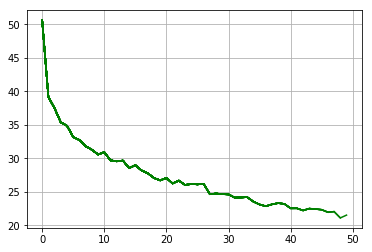

In [24]:
for epoch in range(0,epochs):
    val_loss_epoch = []
    index = np.arange(len(train_data))

    train_data.reset_index()
    np.random.shuffle(index)
    train_data = train_data.loc[index]
    
    current_train_data = train_data.groupby(['video_path']).first().reset_index()

    
    for start, end in zip(
                    range(0, len(current_train_data),batch_size),
                    range(batch_size,len(current_train_data),batch_size)):
    
        start_time = time.time()
        
        current_batch = current_train_data[start:end]
        current_videos = current_batch['video_path'].values
        
        current_feats = np.zeros((batch_size, video_lstm_step,dim_image))
        current_feats_vals = list(map(lambda vid: np.load(vid),current_videos))
        current_feats_vals = np.array(current_feats_vals) 
    
        current_video_masks = np.zeros((batch_size,video_lstm_step))
    
        for ind,feat in enumerate(current_feats_vals):
                    current_feats[ind][:len(current_feats_vals[ind])] = feat
                    current_video_masks[ind][:len(current_feats_vals[ind])] = 1
    
        current_captions = current_batch['Description'].values
        current_captions = list(map(lambda x: '<bos> ' + x, current_captions))
        current_captions = list(map(lambda x: x.replace('.', ''), current_captions))
        current_captions = list(map(lambda x: x.replace(',', ''), current_captions))
        current_captions = list(map(lambda x: x.replace('"', ''), current_captions))
        current_captions = list(map(lambda x: x.replace('\n', ''), current_captions))
        current_captions = list(map(lambda x: x.replace('?', ''), current_captions))
        current_captions = list(map(lambda x: x.replace('!', ''), current_captions))
        current_captions = list(map(lambda x: x.replace('\\', ''), current_captions))
        current_captions = list(map(lambda x: x.replace('/', ''), current_captions))

    
        for idx, each_cap in enumerate(current_captions):
            word = each_cap.lower().split(' ')
            if len(word) < caption_lstm_step:
                current_captions[idx] = current_captions[idx] + ' <eos>'
            else:
                new_word = ''
                for i in range(caption_lstm_step-1):
                    new_word = new_word + word[i] + ' '
                current_captions[idx] = new_word + '<eos>'
    
        current_caption_ind = []
        for cap in current_captions:
            current_word_ind = []
            for word in cap.lower().split(' '):
                if word in word2idx:
                    current_word_ind.append(word2idx[word])
                else:
                    current_word_ind.append(word2idx['<unk>'])
            current_caption_ind.append(current_word_ind)
    
        current_caption_matrix = sequence.pad_sequences(current_caption_ind, padding='post', maxlen=caption_lstm_step)
        current_caption_matrix = np.hstack( [current_caption_matrix, np.zeros( [len(current_caption_matrix), 1] ) ] ).astype(int)
        current_caption_masks = np.zeros( (current_caption_matrix.shape[0], current_caption_matrix.shape[1]) )
        nonzeros = np.array( list(map(lambda x: (x != 0).sum() + 1, current_caption_matrix ) ))
    
        for ind, row in enumerate(current_caption_masks):
            row[:nonzeros[ind]] = 1
    
        probs_val = sess.run(tf_probs, feed_dict={
                    tf_video:current_feats,
                    tf_caption: current_caption_matrix
                    })
    
        _, loss_val = sess.run(
                        [train_op, tf_loss],
                        feed_dict={
                            tf_video: current_feats,
                            tf_video_mask : current_video_masks,
                            tf_caption: current_caption_matrix,
                            tf_caption_mask: current_caption_masks
                            })
        val_loss_epoch.append(loss_val)
    
        print('Batch starting index: ', start, " Epoch: ", epoch, " loss: ", loss_val, ' Elapsed time: ', str((time.time() - start_time)))
        loss_out.write('epoch ' + str(epoch) + ' loss ' + str(loss_val) + '\n')
    
            # draw loss curve every epoch
    val_loss.append(np.mean(val_loss_epoch))
    plt_save_dir = path_prj
    plt_save_img_name = str(epoch) + '.png'
    plt.plot(range(len(val_loss)),val_loss, color='g')
    plt.grid(True)
    plt.savefig(os.path.join(plt_save_dir, plt_save_img_name))
    
    if np.mod(epoch,9) == 0:
        print ("Epoch ", epoch, " is done. Saving the model ...")
        saver.save(sess, os.path.join(path_prj, 'model'), global_step=epoch)
    
loss_out.close()

# Genrating Test data

In [4]:

def get_test_data(text_path,feat_path):
        text_data = pd.read_csv(text_path, sep=',')
        text_data = text_data[text_data['Language'] == 'English']
        text_data['video_path'] = text_data.apply(lambda row: row['VideoID']+'_'+str(int(row['Start']))+'_'+str(int(row['End']))+'.avi.npy', axis=1)
        text_data['video_path'] = text_data['video_path'].map(lambda x: os.path.join(feat_path, x))
        text_data = text_data[text_data['video_path'].map(lambda x: os.path.exists( x ))]
        text_data = text_data[text_data['Description'].map(lambda x: isinstance(x, str))]
    
        unique_filenames = sorted(text_data['video_path'].unique())
        test_data = text_data[text_data['video_path'].map(lambda x: x in unique_filenames)]
        return test_data       
        

# Replicates the Build_Model to derive and define all the tensorflow inputs

In [5]:
def build_generator():
        with tf.device('/cpu:0'):
            word_emb = tf.Variable(tf.random_uniform([n_words, dim_hidden], -0.1, 0.1), name='word_emb')


        lstm1 = tf.nn.rnn_cell.BasicLSTMCell(dim_hidden, state_is_tuple=False)
        lstm2 = tf.nn.rnn_cell.BasicLSTMCell(dim_hidden, state_is_tuple=False)

        encode_W = tf.Variable( tf.random_uniform([dim_image,dim_hidden], -0.1, 0.1), name='encode_W')
        encode_b = tf.Variable( tf.zeros([dim_hidden]), name='encode_b')

        word_emb_W = tf.Variable(tf.random_uniform([dim_hidden,n_words], -0.1,0.1), name='word_emb_W')
        word_emb_b = tf.Variable(tf.zeros([n_words]), name='word_emb_b')
        video = tf.placeholder(tf.float32, [1, video_lstm_step, dim_image])
        video_mask = tf.placeholder(tf.float32, [1, video_lstm_step])

        video_flat = tf.reshape(video, [-1, dim_image])
        image_emb = tf.nn.xw_plus_b(video_flat, encode_W, encode_b)
        image_emb = tf.reshape(image_emb, [1, video_lstm_step, dim_hidden])

        state1 = tf.zeros([1, lstm1.state_size])
        state2 = tf.zeros([1, lstm2.state_size])
        padding = tf.zeros([1, dim_hidden])

        generated_words = []

        probs = []
        embeds = []

        for i in range(0, video_lstm_step):
            if i > 0:
                tf.get_variable_scope().reuse_variables()

            with tf.variable_scope("LSTM1"):
                output1, state1 = lstm1(image_emb[:, i, :], state1)

            with tf.variable_scope("LSTM2"):
                output2, state2 = lstm2(tf.concat([padding, output1],1), state2)

        for i in range(0, caption_lstm_step):
            tf.get_variable_scope().reuse_variables()

            if i == 0:
                with tf.device('/cpu:0'):
                    current_embed = tf.nn.embedding_lookup(word_emb, tf.ones([1], dtype=tf.int64))

            with tf.variable_scope("LSTM1"):
                output1, state1 = lstm1(padding, state1)

            with tf.variable_scope("LSTM2"):
                output2, state2 = lstm2(tf.concat([current_embed, output1],1), state2)

            logit_words = tf.nn.xw_plus_b( output2, word_emb_W, word_emb_b)
            max_prob_index = tf.argmax(logit_words, 1)[0]
            generated_words.append(max_prob_index)
            probs.append(logit_words)

            with tf.device("/cpu:0"):
                current_embed = tf.nn.embedding_lookup(word_emb, max_prob_index)
                current_embed = tf.expand_dims(current_embed, 0)

            embeds.append(current_embed)

        return video, video_mask, generated_words, probs, embeds

In [6]:
test_text_path = text_path
test_feat_path = feat_path
test_data = get_test_data(test_text_path,test_feat_path)
test_videos = test_data['video_path'].unique()

In [7]:
test_data

,VideoID,Start,End,WorkerID,Source,AnnotationTime,Language,Description,video_path
18,mv89psg6zh4,33,46,682611,clean,66,English,A bird in a sink keeps getting under the runni...,C:\Users\cst2978\OneDrive - The Home Depot\Des...
19,mv89psg6zh4,33,46,760882,clean,16,English,A bird is bathing in a sink.,C:\Users\cst2978\OneDrive - The Home Depot\Des...
20,mv89psg6zh4,33,46,878566,clean,76,English,A bird is splashing around under a running fau...,C:\Users\cst2978\OneDrive - The Home Depot\Des...
21,mv89psg6zh4,33,46,707318,clean,14,English,A bird is bathing in a sink.,C:\Users\cst2978\OneDrive - The Home Depot\Des...
22,mv89psg6zh4,33,46,135621,clean,58,English,A bird is standing in a sink drinking water th...,C:\Users\cst2978\OneDrive - The Home Depot\Des...
23,mv89psg6zh4,33,46,257511,clean,57,English,A faucet is running while a bird stands in the...,C:\Users\cst2978\OneDrive - The Home Depot\Des...
24,mv89psg6zh4,33,46,435773,clean,25,English,A bird is playing in a sink with running water.,C:\Users\cst2978\OneDrive - The Home Depot\Des...
25,mv89psg6zh4,33,46,275759,clean,27,English,A bird is playing in tap water.,C:\Users\cst2978\OneDrive - The Home Depot\Des...
26,mv89psg6zh4,33,46,157374,clean,30,English,A bird is bathing in the sink.,C:\Users\cst2978\OneDrive - The Home Depot\Des...
27,mv89psg6zh4,33,46,373663,clean,36,English,A bird is taking a bath.,C:\Users\cst2978\OneDrive - The Home Depot\Des...


In [8]:
idx2word = pd.Series(np.load(path_prj + "\\idx2word.npy").tolist())
n_words = len(idx2word)

In [9]:
video_tf, video_mask_tf, caption_tf, probs_tf, last_embed_tf = build_generator()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.


# Loading the Model-45 (Latest saved Model) 

In [10]:
model_path = 'C:\\Users\\cst2978\\OneDrive - The Home Depot\\Desktop\\AI\\qsb\\Project\\model-45'
sess = tf.InteractiveSession()
saver = tf.train.Saver()
saver.restore(sess,model_path)

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\model-45


In [11]:
f = open(f'{path_prj}/video_captioning_results_Final.txt', 'w',encoding='utf-8')

for idx, video_feat_path in enumerate(test_videos):
            video_feat = np.load(video_feat_path)[None,...]
            if video_feat.shape[1] == frame_step:
                video_mask = np.ones((video_feat.shape[0], video_feat.shape[1]))
            else:
                continue
            gen_word_idx = sess.run(caption_tf, feed_dict={video_tf:video_feat, video_mask_tf:video_mask})
            print (idx)
            gen_words = idx2word[gen_word_idx]
    
            punct = np.argmax(np.array(gen_words) == '<eos>') + 1
            gen_words = gen_words[:punct]
            print (idx)
            gen_sent = ' '.join(gen_words)
            gen_sent = gen_sent.replace('<bos> ', '')
            gen_sent = gen_sent.replace(' <eos>', '')
            print(f'Video path {video_feat_path} : Generated Caption: {gen_sent}')
            print(gen_sent,'\n')
            f.write(video_feat_path + '\n')
            f.write(gen_sent + '\n\n')

0
0
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\mv89psg6zh4_33_46.avi.npy : Generated Caption: a bird is playing in a sink
a bird is playing in a sink 

1
1
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\ZbzDGXEwtGc_6_15.avi.npy : Generated Caption: a plane is flying
a plane is flying 

2
2
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\g36ho6UrBz0_5_20.avi.npy : Generated Caption: a man is playing a guitar
a man is playing a guitar 

3
3
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\04Gt01vatkk_248_265.avi.npy : Generated Caption: a woman is slicing an onion
a woman is slicing an onion 

4
4
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\buJ5HDCinrM_150_166.avi.npy : Generated Caption: a woman is applying makeup
a woman is applying makeup 

5
5
Video path C:\Users\cst2978\OneDrive - The Ho

43
43
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\j2Dhf-xFUxU_13_20.avi.npy : Generated Caption: a person is cutting a piece of paper
a person is cutting a piece of paper 

44
44
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\_txL575S_OA_13_23.avi.npy : Generated Caption: a group of zebras are playing
a group of zebras are playing 

45
45
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\E6sqA9QtV5I_195_201.avi.npy : Generated Caption: a man and woman are kissing
a man and woman are kissing 

46
46
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\XzCcRzEa83U_1_8.avi.npy : Generated Caption: a monkey is walking
a monkey is walking 

47
47
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\8jP8CC2rKj4_80_88.avi.npy : Generated Caption: a man is jumping
a man is jumping 

48
48
Video path C:\Users\cst29

85
85
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\ywMLb2VfHbI_13_20.avi.npy : Generated Caption: a small animal is running
a small animal is running 

86
86
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\XZ0Ch_ClBfo_120_127.avi.npy : Generated Caption: a group of men are playing
a group of men are playing 

87
87
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\gMqKUPeTAkg_17_30.avi.npy : Generated Caption: a cat is drinking water
a cat is drinking water 

88
88
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\PmrTDZy3f2M_35_39.avi.npy : Generated Caption: a man is playing with a ball
a man is playing with a ball 

89
89
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\S-Civm_fbK8_20_26.avi.npy : Generated Caption: a boy is playing a ball
a boy is playing a ball 

90
90
Video path C:\Users\cst2978

129
129
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\O06WXS_XZN0_0_6.avi.npy : Generated Caption: a man is playing with a dog
a man is playing with a dog 

130
130
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\47D9-U8hn5I_11_16.avi.npy : Generated Caption: a cat is walking on a table
a cat is walking on a table 

131
131
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\-_hbPLsZvvo_18_25.avi.npy : Generated Caption: a woman is slicing a cucumber
a woman is slicing a cucumber 

132
132
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\c51L6ZxZGjQ_137_154.avi.npy : Generated Caption: a woman is cooking
a woman is cooking 

133
133
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\-vKO3uSG6Do_3_14.avi.npy : Generated Caption: a group of people are dancing
a group of people are dancing 

134
134
Video pa

171
171
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\cs33MNhpRNw_16_21.avi.npy : Generated Caption: a man is taking a door
a man is taking a door 

172
172
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\uqVCk2oDpSE_194_200.avi.npy : Generated Caption: a man is cutting a loaf of bread
a man is cutting a loaf of bread 

173
173
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\rwHT2SuNOi8_195_201.avi.npy : Generated Caption: a man is cutting a piece of meat
a man is cutting a piece of meat 

174
174
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\q3I3R_gqy8M_73_79.avi.npy : Generated Caption: a man is doing a woman
a man is doing a woman 

175
175
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\6sKdTbRkahM_6_12.avi.npy : Generated Caption: a man is cutting a potato
a man is cutting a potato 

176
17

213
213
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\MJoxGpEswOI_9_16.avi.npy : Generated Caption: a basketball is playing basketball
a basketball is playing basketball 

214
214
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\ngHDYzhDBk4_5_14.avi.npy : Generated Caption: a group of people are dancing
a group of people are dancing 

215
215
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\6t0BpjwYKco_53_59.avi.npy : Generated Caption: a woman is slicing a potato
a woman is slicing a potato 

216
216
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\KPPCwmU5OHQ_480_486.avi.npy : Generated Caption: a man is pouring some food
a man is pouring some food 

217
217
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\V--abChiVVc_30_40.avi.npy : Generated Caption: a group of people are dancing
a group of people

257
257
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\edqyq4Q-7uU_103_109.avi.npy : Generated Caption: a man is dancing
a man is dancing 

258
258
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\xxHx6s_DbUo_32_36.avi.npy : Generated Caption: a man is running
a man is running 

259
259
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\BnJUWwSx1kE_11_22.avi.npy : Generated Caption: a wombat is walking
a wombat is walking 

260
260
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\nd0ToNwccl4_12_17.avi.npy : Generated Caption: a man is playing with a football
a man is playing with a football 

261
261
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\ggic669elLM_200_215.avi.npy : Generated Caption: a man is singing
a man is singing 

262
262
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\

300
300
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\kNHivduxQWg_0_14.avi.npy : Generated Caption: two pigs are eating
two pigs are eating 

301
301
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\qeKX-N1nKiM_68_72.avi.npy : Generated Caption: a woman is slicing a potato
a woman is slicing a potato 

302
302
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\9Wr48VFhZH8_45_50.avi.npy : Generated Caption: a tiger is walking
a tiger is walking 

303
303
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\n_Z0-giaspE_270_278.avi.npy : Generated Caption: a man is driving a boat
a man is driving a boat 

304
304
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\_KMoC6ZdeXs_10_16.avi.npy : Generated Caption: a man is playing a guitar
a man is playing a guitar 

305
305
Video path C:\Users\cst2978\OneDrive - The

343
343
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\WTf5EgVY5uU_100_104.avi.npy : Generated Caption: a woman is cracking eggs
a woman is cracking eggs 

344
344
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\97JhYpoWxzY_0_4.avi.npy : Generated Caption: a baby is eating
a baby is eating 

345
345
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\PiyoeFC31kE_9_27.avi.npy : Generated Caption: a man is riding a horse
a man is riding a horse 

346
346
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\-wa0umYJVGg_271_276.avi.npy : Generated Caption: a woman is slicing a piece of meat
a woman is slicing a piece of meat 

347
347
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\OIjsSu_I4So_6_10.avi.npy : Generated Caption: a car is driving a car
a car is driving a car 

348
348
Video path C:\Users\cst2978\O

386
386
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\EjAoBKagWQA_132_145.avi.npy : Generated Caption: a group of people are kissing
a group of people are kissing 

387
387
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\IhwPQL9dFYc_143_147.avi.npy : Generated Caption: a woman is cooking
a woman is cooking 

388
388
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\BVy9SQI5R68_0_7.avi.npy : Generated Caption: a baby is crying
a baby is crying 

389
389
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\QVSt5USMkMg_43_50.avi.npy : Generated Caption: a woman is feeding a baby
a woman is feeding a baby 

390
390
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\DLcuZ-HnHZc_0_10.avi.npy : Generated Caption: a kangaroo is eating
a kangaroo is eating 

391
391
Video path C:\Users\cst2978\OneDrive - The Home De

429
429
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\cCmnN96zIeQ_14_24.avi.npy : Generated Caption: a man is dancing
a man is dancing 

430
430
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\xXlWsBhFvis_6_10.avi.npy : Generated Caption: a woman is doing exercise
a woman is doing exercise 

431
431
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\hWhKdXcqYeU_3_12.avi.npy : Generated Caption: a man is dancing
a man is dancing 

432
432
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\b_BuSVZwq6M_1_9.avi.npy : Generated Caption: a man is playing a ball
a man is playing a ball 

433
433
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\xPR0xFgCAZY_17_27.avi.npy : Generated Caption: a person is slicing a tomato
a person is slicing a tomato 

434
434
Video path C:\Users\cst2978\OneDrive - The Home Depot\D

473
473
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\NaX51emUDn4_0_20.avi.npy : Generated Caption: a cat is drinking water
a cat is drinking water 

474
474
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\ao-9B8IV9_E_87_95.avi.npy : Generated Caption: a man is walking
a man is walking 

475
475
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\gWRRHV7DLV0_21_31.avi.npy : Generated Caption: a man is cutting a man
a man is cutting a man 

476
476
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\PHDmVhShE80_82_86.avi.npy : Generated Caption: a woman is cooking
a woman is cooking 

477
477
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\e3XkmpNcSt4_8_19.avi.npy : Generated Caption: a man is writing on a computer
a man is writing on a computer 

478
478
Video path C:\Users\cst2978\OneDrive - The Home Dep

516
516
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\-wa0umYJVGg_23_41.avi.npy : Generated Caption: a man is cooking
a man is cooking 

517
517
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\rNSAmHPYHjA_60_73.avi.npy : Generated Caption: a woman is cutting meat
a woman is cutting meat 

518
518
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\PQbkdRbir0M_45_53.avi.npy : Generated Caption: a girl is making a tomato
a girl is making a tomato 

519
519
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\gvVsgOK1iJw_32_38.avi.npy : Generated Caption: a man is doing a woman
a man is doing a woman 

520
520
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\kWLNZzuo3do_17_23.avi.npy : Generated Caption: a woman is slicing a green green green onion
a woman is slicing a green green green onion 

521
521
Video p

558
558
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\1dfR0A_BXjw_545_560.avi.npy : Generated Caption: a man is cutting a bread
a man is cutting a bread 

559
559
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\0piwbTivpDg_10_40.avi.npy : Generated Caption: a man is talking
a man is talking 

560
560
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\puineN1UMto_25_29.avi.npy : Generated Caption: a squirrel is dancing
a squirrel is dancing 

561
561
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\mHv4iJ9Yr1g_10_16.avi.npy : Generated Caption: a cat is eating a cat
a cat is eating a cat 

562
562
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\HVR7KpItLfA_62_70.avi.npy : Generated Caption: a man is speaking
a man is speaking 

563
563
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qs

601
601
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\xBW_uR3kGr4_42_55.avi.npy : Generated Caption: a woman is kissing
a woman is kissing 

602
602
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\RX6NSOuCCAE_13_27.avi.npy : Generated Caption: a man is cutting a tree
a man is cutting a tree 

603
603
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\gHyXstpe_N8_95_100.avi.npy : Generated Caption: a man is opening a box
a man is opening a box 

604
604
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\WTf5EgVY5uU_15_19.avi.npy : Generated Caption: a woman is cutting a piece of meat
a woman is cutting a piece of meat 

605
605
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\PqSZ89FqpiY_65_75.avi.npy : Generated Caption: a man is cooking
a man is cooking 

606
606
Video path C:\Users\cst2978\OneDrive - T

643
643
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\aN0WsBcja_E_0_15.avi.npy : Generated Caption: a cat is playing with a toy
a cat is playing with a toy 

644
644
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\77iDIp40m9E_159_181.avi.npy : Generated Caption: a man is walking
a man is walking 

645
645
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\4Tn5S48sCwg_110_118.avi.npy : Generated Caption: a woman is sitting on a baby
a woman is sitting on a baby 

646
646
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\mfJjIOfj6D8_3_10.avi.npy : Generated Caption: a lion is eating grass
a lion is eating grass 

647
647
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\s20OlIRK340_147_174.avi.npy : Generated Caption: a woman is cutting a potato
a woman is cutting a potato 

648
648
Video path C:\Users\cst

685
685
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\TPhpsIK7pDc_25_32.avi.npy : Generated Caption: a hedgehog is licking a hedgehog
a hedgehog is licking a hedgehog 

686
686
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\-8y1Q0rA3n8_95_102.avi.npy : Generated Caption: a man is playing a sword
a man is playing a sword 

687
687
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\2YhDTpzxd3c_223_232.avi.npy : Generated Caption: a man is running a truck
a man is running a truck 

688
688
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\AX38yo7Wuws_81_91.avi.npy : Generated Caption: a man is cutting a piece of paper
a man is cutting a piece of paper 

689
689
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\v7iIZXtpIb8_5_15.avi.npy : Generated Caption: a boy is playing a piano
a boy is playing a piano 


728
728
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\WG0J2B19ZT8_1_33.avi.npy : Generated Caption: a man is cutting a woman
a man is cutting a woman 

729
729
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\iarsmqA3dck_19_25.avi.npy : Generated Caption: a cheetah is running
a cheetah is running 

730
730
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\tqxRDVKtkSY_30_45.avi.npy : Generated Caption: a man is kissing a woman
a man is kissing a woman 

731
731
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\Z-An1QQ66f0_13_25.avi.npy : Generated Caption: a woman is riding a motorcycle
a woman is riding a motorcycle 

732
732
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\POv7JaE3vJ8_40_50.avi.npy : Generated Caption: a man is playing a harp
a man is playing a harp 

733
733
Video path C:\Users\cst297

772
772
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\s20OlIRK340_125_138.avi.npy : Generated Caption: a woman is peeling a potato
a woman is peeling a potato 

773
773
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\Okg8QYhdtvU_48_53.avi.npy : Generated Caption: a man is peeling a potato
a man is peeling a potato 

774
774
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\UbmZAe5u5FI_111_115.avi.npy : Generated Caption: a person is cooking a fish
a person is cooking a fish 

775
775
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\-_hbPLsZvvo_49_55.avi.npy : Generated Caption: a woman is slicing a carrot
a woman is slicing a carrot 

776
776
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\rw9h_574HxE_127_133.avi.npy : Generated Caption: a man and woman are walking in a woman
a man and woman are walk

816
816
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\f_CvW22Eauc_16_23.avi.npy : Generated Caption: a man is walking on a wall
a man is walking on a wall 

817
817
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\D9I1Z6O_mbw_112_119.avi.npy : Generated Caption: a man and woman are riding a motorcycle
a man and woman are riding a motorcycle 

818
818
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\nULE40HEWpA_5_11.avi.npy : Generated Caption: a kitten is playing with a toy
a kitten is playing with a toy 

819
819
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\Je3V7U5Ctj4_997_1004.avi.npy : Generated Caption: a man is pouring sauce into a pan
a man is pouring sauce into a pan 

820
820
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\iTA0rWPE4nY_17_23.avi.npy : Generated Caption: a man is doing a ha

859
859
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\sFExO_PW22s_10_18.avi.npy : Generated Caption: a fish is swimming
a fish is swimming 

860
860
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\-vg3vR86fu0_1_6.avi.npy : Generated Caption: a man is riding a motorcycle
a man is riding a motorcycle 

861
861
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\0lh_UWF9ZP4_215_226.avi.npy : Generated Caption: a woman is cutting a potato
a woman is cutting a potato 

862
862
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\pGsU4FekJQM_10_18.avi.npy : Generated Caption: a dog is lying on the floor
a dog is lying on the floor 

863
863
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\05gNigkqfNU_25_34.avi.npy : Generated Caption: a man is cutting a potato
a man is cutting a potato 

864
864
Video path C:\Use

902
902
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\WTf5EgVY5uU_32_52.avi.npy : Generated Caption: a woman is slicing a vegetable
a woman is slicing a vegetable 

903
903
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\3qqEKTPxLNs_1_15.avi.npy : Generated Caption: a baby is playing with a toy
a baby is playing with a toy 

904
904
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\-_aaMGK6GGw_57_61.avi.npy : Generated Caption: a man is talking
a man is talking 

905
905
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\UXs3eq68ZjE_194_200.avi.npy : Generated Caption: a man is mixing a bowl
a man is mixing a bowl 

906
906
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\rVFJzN20jhQ_27_32.avi.npy : Generated Caption: a man is doing a boy
a man is doing a boy 

907
907
Video path C:\Users\cst2978\OneDri

944
944
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\eTnlw7v8ea0_36_50.avi.npy : Generated Caption: a person is cooking
a person is cooking 

945
945
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\-bjOB4zS0uE_100_105.avi.npy : Generated Caption: a woman is pouring a glass
a woman is pouring a glass 

946
946
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\PeUHy0A1GF0_51_55.avi.npy : Generated Caption: a woman is pouring some food into a bowl
a woman is pouring some food into a bowl 

947
947
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\haJn6k5zVnE_1_23.avi.npy : Generated Caption: a man is playing a keyboard
a man is playing a keyboard 

948
948
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\88p7U5CnoYU_1_10.avi.npy : Generated Caption: a panda is walking
a panda is walking 

949
949
Video p

987
987
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\Rq_VfjGH7kg_104_110.avi.npy : Generated Caption: a man and woman are riding a motorcycle
a man and woman are riding a motorcycle 

988
988
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\qLwgb3F0aPU_298_305.avi.npy : Generated Caption: a group of men are running
a group of men are running 

989
989
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\pRpeEdMmmQ0_1_18.avi.npy : Generated Caption: a boy is playing a soccer ball
a boy is playing a soccer ball 

990
990
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\fKqBnl8D1Qo_5_44.avi.npy : Generated Caption: a group of people are singing
a group of people are singing 

991
991
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\EA-J-Y6QjUo_40_61.avi.npy : Generated Caption: a cat is playing with a box
a

1028
1028
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\OIg10Bl7urs_0_10.avi.npy : Generated Caption: a cat is eating food
a cat is eating food 

1029
1029
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\pRpeEdMmmQ0_65_70.avi.npy : Generated Caption: a woman is dancing
a woman is dancing 

1030
1030
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\QqYWLR47eLI_10_18.avi.npy : Generated Caption: a animal is eating
a animal is eating 

1031
1031
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\CcvJs77L-e8_15_22.avi.npy : Generated Caption: a man is walking
a man is walking 

1032
1032
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\Ya-MkA187c8_36_45.avi.npy : Generated Caption: a woman is playing a guitar
a woman is playing a guitar 

1033
1033
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desk

1071
1071
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\gqxpGOHUH9k_113_119.avi.npy : Generated Caption: a group of people are dancing
a group of people are dancing 

1072
1072
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\lSnWhsmlGec_5_10.avi.npy : Generated Caption: a man is playing a guitar
a man is playing a guitar 

1073
1073
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\UgUFP5baQ9Y_0_10.avi.npy : Generated Caption: three women are dancing
three women are dancing 

1074
1074
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\nCtZFOYAlvQ_44_49.avi.npy : Generated Caption: a man is riding a hill
a man is riding a hill 

1075
1075
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\c2a0GcoJAjw_52_73.avi.npy : Generated Caption: a man is breaking a woman
a man is breaking a woman 

1076
1076
Video p

1114
1114
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\6BrHPMdyVtU_1_10.avi.npy : Generated Caption: a man is playing a piano
a man is playing a piano 

1115
1115
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\kk3TIio1-Uw_5_14.avi.npy : Generated Caption: a man is playing a violin
a man is playing a violin 

1116
1116
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\0bSz70pYAP0_5_15.avi.npy : Generated Caption: a plane is flying
a plane is flying 

1117
1117
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\kI6MWZrl8v8_149_161.avi.npy : Generated Caption: a man is playing a guitar
a man is playing a guitar 

1118
1118
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\MrQd1zUVRUM_103_110.avi.npy : Generated Caption: two women are kissing
two women are kissing 

1119
1119
Video path C:\Users\cst2978\On

1156
1156
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\BApIQn69EVE_10_16.avi.npy : Generated Caption: a woman is eating
a woman is eating 

1157
1157
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\s-XjRDsYuzU_0_12.avi.npy : Generated Caption: a man is slicing a piece of meat
a man is slicing a piece of meat 

1158
1158
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\VahnQw2gTQY_315_320.avi.npy : Generated Caption: a person is slicing an onion
a person is slicing an onion 

1159
1159
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\6gQu8PWhFoQ_30_35.avi.npy : Generated Caption: a man is riding a motorcycle
a man is riding a motorcycle 

1160
1160
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\1dfR0A_BXjw_524_532.avi.npy : Generated Caption: a man is cutting a bread
a man is cutting a bread 

1161

1199
1199
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\Je3V7U5Ctj4_768_773.avi.npy : Generated Caption: a man is cooking chicken
a man is cooking chicken 

1200
1200
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\HkpUWzNNVt4_20_30.avi.npy : Generated Caption: a man is talking
a man is talking 

1201
1201
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\LEz0puaKNTk_38_48.avi.npy : Generated Caption: a man is making a bowl
a man is making a bowl 

1202
1202
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\4VLrxtf7Z_8_0_7.avi.npy : Generated Caption: a woman is riding a horse
a woman is riding a horse 

1203
1203
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\tPkZK-PzeQE_10_28.avi.npy : Generated Caption: a person is cutting a tomato
a person is cutting a tomato 

1204
1204
Video path C:\Users\cst29

1241
1241
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\RieF9wrFd8s_1_8.avi.npy : Generated Caption: a man is shooting
a man is shooting 

1242
1242
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\HypgcCT1r68_38_46.avi.npy : Generated Caption: a man is reading a woman
a man is reading a woman 

1243
1243
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\Z19zFlPah-o_6_11.avi.npy : Generated Caption: a car is flying
a car is flying 

1244
1244
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\JIoiUNOXGaI_98_104.avi.npy : Generated Caption: a woman is taking a woman
a woman is taking a woman 

1245
1245
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\Rf0TUCA3XNs_3_16.avi.npy : Generated Caption: a girl is playing a guitar
a girl is playing a guitar 

1246
1246
Video path C:\Users\cst2978\OneDrive - The H

1283
1283
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\TjLCJKoot4U_43_65.avi.npy : Generated Caption: a bear is walking
a bear is walking 

1284
1284
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\x_7BrCQdVUs_172_177.avi.npy : Generated Caption: a girl is feeding a man
a girl is feeding a man 

1285
1285
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\HO_ovIrLWfQ_1_11.avi.npy : Generated Caption: a man is playing a boat
a man is playing a boat 

1286
1286
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\YwmUgVrUJ4I_0_15.avi.npy : Generated Caption: a woman is doing exercise
a woman is doing exercise 

1287
1287
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\yId1rg5-ac0_40_50.avi.npy : Generated Caption: two women are fighting
two women are fighting 

1288
1288
Video path C:\Users\cst2978\OneDriv

1325
1325
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\RjpbFlOHFps_8_25.avi.npy : Generated Caption: a group of people are running
a group of people are running 

1326
1326
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\rw9h_574HxE_161_166.avi.npy : Generated Caption: a woman is doing a woman
a woman is doing a woman 

1327
1327
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\4_WZN7uW0NY_140_145.avi.npy : Generated Caption: a man is climbing a wall
a man is climbing a wall 

1328
1328
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\0lh_UWF9ZP4_199_207.avi.npy : Generated Caption: a woman is cutting a piece of meat
a woman is cutting a piece of meat 

1329
1329
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\VyBXcQ1v_cw_7_15.avi.npy : Generated Caption: a man is lifting weights
a man is lifting w

1367
1367
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\umjc1CkO4JA_290_305.avi.npy : Generated Caption: a man is walking
a man is walking 

1368
1368
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\9LHg5RUGukI_58_63.avi.npy : Generated Caption: a man is taking a package of water
a man is taking a package of water 

1369
1369
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\k9Brw_0gncU_14_33.avi.npy : Generated Caption: a man is playing a guitar
a man is playing a guitar 

1370
1370
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\ficwZQYmRLE_5_20.avi.npy : Generated Caption: a dog is playing with a dog
a dog is playing with a dog 

1371
1371
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\hNPZmTlY_3Q_0_8.avi.npy : Generated Caption: a man is walking
a man is walking 

1372
1372
Video path C:\Users\

1409
1409
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\FeTaKOPVaJg_15_25.avi.npy : Generated Caption: a group of girls are dancing
a group of girls are dancing 

1410
1410
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\kWLNZzuo3do_25_32.avi.npy : Generated Caption: a woman is cutting a vegetable
a woman is cutting a vegetable 

1411
1411
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\PeUHy0A1GF0_105_112.avi.npy : Generated Caption: a woman is cutting a piece of meat
a woman is cutting a piece of meat 

1412
1412
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\b4FM9OLBGyM_37_49.avi.npy : Generated Caption: a woman is applying eye makeup
a woman is applying eye makeup 

1413
1413
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\02Z-kuB3IaM_2_13.avi.npy : Generated Caption: a man is running
a man i

1451
1451
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\DvYN53KBDr0_51_62.avi.npy : Generated Caption: a man is driving a car
a man is driving a car 

1452
1452
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\JsD6uEZsIsU_1_47.avi.npy : Generated Caption: a man is playing a guitar
a man is playing a guitar 

1453
1453
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\4xVGpDmA4lE_23_33.avi.npy : Generated Caption: a man is walking on a woman
a man is walking on a woman 

1454
1454
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\4cgzdXlJksU_83_90.avi.npy : Generated Caption: a woman is peeling a potato
a woman is peeling a potato 

1455
1455
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\xxHx6s_DbUo_216_222.avi.npy : Generated Caption: a man is climbing a rope
a man is climbing a rope 

1456
1456
Vide

1494
1494
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\-s4-6QTT7HE_235_241.avi.npy : Generated Caption: a group of people are dancing
a group of people are dancing 

1495
1495
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\UXs3eq68ZjE_382_387.avi.npy : Generated Caption: a person is pouring rice into a pot
a person is pouring rice into a pot 

1496
1496
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\z0zb--BOhDY_16_22.avi.npy : Generated Caption: a man is making dough
a man is making dough 

1497
1497
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\aDjNl5gs4nM_18_47.avi.npy : Generated Caption: a woman is slicing an onion
a woman is slicing an onion 

1498
1498
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\4eJJF11bIxM_1_9.avi.npy : Generated Caption: a girl is talking on the phone
a girl is ta

1536
1536
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\WinaH9SkW9c_11_38.avi.npy : Generated Caption: a man is riding a horse
a man is riding a horse 

1537
1537
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\MrMG15y3rWU_5_13.avi.npy : Generated Caption: a frog is playing with a frog
a frog is playing with a frog 

1538
1538
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\nTasT5h0LEg_12_14.avi.npy : Generated Caption: a cat is walking on a couch
a cat is walking on a couch 

1539
1539
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\eVSQiPbepXg_44_49.avi.npy : Generated Caption: a woman is reading a banana
a woman is reading a banana 

1540
1540
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\_JorUS-8Nlg_63_73.avi.npy : Generated Caption: people are riding a bus
people are riding a bus 

1541
154

1578
1578
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\CGllPWAwmUo_1_15.avi.npy : Generated Caption: a man is playing a violin
a man is playing a violin 

1579
1579
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\0lh_UWF9ZP4_183_190.avi.npy : Generated Caption: a woman is slicing a piece of meat
a woman is slicing a piece of meat 

1580
1580
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\FAD8CbQuvco_35_45.avi.npy : Generated Caption: a man is peeling a potato
a man is peeling a potato 

1581
1581
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\4wT7zM8XgXQ_5_11.avi.npy : Generated Caption: a car is driving a car
a car is driving a car 

1582
1582
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\pfQPRXcihkI_127_138.avi.npy : Generated Caption: a man is cutting a potato
a man is cutting a potato 

1

1620
1620
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\4D1o4FC8YbA_29_39.avi.npy : Generated Caption: a woman is dancing
a woman is dancing 

1621
1621
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\IhwPQL9dFYc_130_136.avi.npy : Generated Caption: a woman is slicing a tomato
a woman is slicing a tomato 

1622
1622
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\IhwPQL9dFYc_50_59.avi.npy : Generated Caption: a woman is slicing a potato
a woman is slicing a potato 

1623
1623
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\WPG-BIWOrG4_635_640.avi.npy : Generated Caption: a man is cutting a loaf of bread
a man is cutting a loaf of bread 

1624
1624
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\OfgSCMxttCc_86_92.avi.npy : Generated Caption: a man is showing a t-shirt
a man is showing a t-shirt 

1

1663
1663
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\qvg9eM4Hmzk_4_10.avi.npy : Generated Caption: a man is lifting a car
a man is lifting a car 

1664
1664
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\5fDBl1wT2Lk_34_39.avi.npy : Generated Caption: a man is playing with a ball
a man is playing with a ball 

1665
1665
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\bnN_o0Hkn3M_73_80.avi.npy : Generated Caption: a man is shooting
a man is shooting 

1666
1666
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\FvfjDQj5sOY_1_10.avi.npy : Generated Caption: a man is playing a guitar
a man is playing a guitar 

1667
1667
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\UXs3eq68ZjE_320_325.avi.npy : Generated Caption: a man is pouring rice into a pot
a man is pouring rice into a pot 

1668
1668
Video p

1704
1704
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\Mutb8BHFvzk_15_20.avi.npy : Generated Caption: a man is peeling an apple
a man is peeling an apple 

1705
1705
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\hJFBXHtxKIc_310_315.avi.npy : Generated Caption: a man is pouring food
a man is pouring food 

1706
1706
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\PqvKNqkGI9o_47_52.avi.npy : Generated Caption: a group of people are fighting
a group of people are fighting 

1707
1707
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\V6Fxclwdfxc_1_11.avi.npy : Generated Caption: a bird is playing with a dead
a bird is playing with a dead 

1708
1708
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\nBFhvrAOFqY_23_29.avi.npy : Generated Caption: a monkey is riding a bike
a monkey is riding a bike 

1709

1746
1746
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\0hyZ__3YhZc_388_394.avi.npy : Generated Caption: a man is pouring sauce into a pan
a man is pouring sauce into a pan 

1747
1747
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\06CbMa0kDr8_3_13.avi.npy : Generated Caption: a panda is eating food
a panda is eating food 

1748
1748
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\fd7Ky1lEPT8_40_50.avi.npy : Generated Caption: a person is slicing a potato
a person is slicing a potato 

1749
1749
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\BefkDBj5gSw_104_109.avi.npy : Generated Caption: a man is walking down a road
a man is walking down a road 

1750
1750
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\ZnLgsasu82g_71_81.avi.npy : Generated Caption: a man is riding a bike
a man is riding a bik

1788
1788
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\jTnrm338_KY_34_42.avi.npy : Generated Caption: a man is doing a hole
a man is doing a hole 

1789
1789
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\akXjIEoecNs_2_12.avi.npy : Generated Caption: a man is playing a keyboard
a man is playing a keyboard 

1790
1790
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\c2MwqFYVE7A_40_45.avi.npy : Generated Caption: a man is shooting a gun
a man is shooting a gun 

1791
1791
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\jPBxl9gFqNY_110_117.avi.npy : Generated Caption: a man is pouring oil into a pan
a man is pouring oil into a pan 

1792
1792
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\64Xn9edeWRA_0_11.avi.npy : Generated Caption: a cat is watching a cat
a cat is watching a cat 

1793
1793
Video

1831
1831
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\C9LHk0AJI7U_196_205.avi.npy : Generated Caption: a man is making a dough
a man is making a dough 

1832
1832
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\hJFBXHtxKIc_225_230.avi.npy : Generated Caption: a man is pouring sauce into a pan
a man is pouring sauce into a pan 

1833
1833
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\EwTZ2xpQwpA_14_21.avi.npy : Generated Caption: a man is singing
a man is singing 

1834
1834
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\bSIjZ75a50s_286_304.avi.npy : Generated Caption: a person is making a piece of meat
a person is making a piece of meat 

1835
1835
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\DBvSfds3FH4_84_88.avi.npy : Generated Caption: a woman is rolling dough
a woman is rolling dough 


1874
1874
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\4yYapi-5QYQ_33_57.avi.npy : Generated Caption: a man is doing a card
a man is doing a card 

1875
1875
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\0M-PyX2DbZc_25_31.avi.npy : Generated Caption: a man is singing
a man is singing 

1876
1876
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\1Sp2__RCT0c_11_15.avi.npy : Generated Caption: a jet is running
a jet is running 

1877
1877
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\cUW_bXll6YM_462_469.avi.npy : Generated Caption: a man is cutting a tomato
a man is cutting a tomato 

1878
1878
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\t8Nf1MK7lts_0_10.avi.npy : Generated Caption: a man is talking
a man is talking 

1879
1879
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\q

1917
1917
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\nq4hG6qgyPs_370_377.avi.npy : Generated Caption: a man is cooking
a man is cooking 

1918
1918
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\6FmN22YcVVE_11_18.avi.npy : Generated Caption: a girl is playing a flute
a girl is playing a flute 

1919
1919
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\dmyz_f8Sx14_56_66.avi.npy : Generated Caption: a group of people are swimming in a pool
a group of people are swimming in a pool 

1920
1920
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\O_Pst-uryQI_1_14.avi.npy : Generated Caption: a man is singing
a man is singing 

1921
1921
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\xGdoi3W3Z4o_2_40.avi.npy : Generated Caption: a boy is dancing
a boy is dancing 

1922
1922
Video path C:\Users\cst2978\O

1959
1959
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\uO7Eysrs8_k_106_114.avi.npy : Generated Caption: a man is riding a motorcycle
a man is riding a motorcycle 

1960
1960
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\lc9bA-hvqHU_1_6.avi.npy : Generated Caption: a man is doing a car
a man is doing a car 

1961
1961
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\2YhDTpzxd3c_166_170.avi.npy : Generated Caption: a man is climbing a rope
a man is climbing a rope 

1962
1962
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\6t0BpjwYKco_230_240.avi.npy : Generated Caption: a woman is cutting a piece of meat
a woman is cutting a piece of meat 

1963
1963
Video path C:\Users\cst2978\OneDrive - The Home Depot\Desktop\AI\qsb\Project\features\0lh_UWF9ZP4_103_110.avi.npy : Generated Caption: a person is cooking
a person is cooking 

1964
1964